# Установка библиотек

In [2]:
!pip install gitpython


   -------------------------- ------------- 2/3 [gitpython]
   -------------------------- ------------- 2/3 [gitpython]
   ---------------------------------------- 3/3 [gitpython]



In [ ]:
!pip install SurvivalEVAL

In [ ]:
!pip install lifelines

In [1]:
!pip install git+https://github.com/soda-inria/hazardous
!pip install pycox
!pip install scikit-survival==0.23.0
!pip install scikit-learn==1.4
!pip install torch
!pip install seaborn

  Cloning https://github.com/soda-inria/hazardous to c:\users\pridanova\appdata\local\temp\104\pip-req-build-90m3snk8


  ERROR: Error [WinError 2] The system cannot find the file specified while executing command git version
ERROR: Cannot find command 'git' - do you have 'git' installed and in your PATH?


In [161]:
np.linspace(1, 309, 100)

array([  1.        ,   4.11111111,   7.22222222,  10.33333333,
        13.44444444,  16.55555556,  19.66666667,  22.77777778,
        25.88888889,  29.        ,  32.11111111,  35.22222222,
        38.33333333,  41.44444444,  44.55555556,  47.66666667,
        50.77777778,  53.88888889,  57.        ,  60.11111111,
        63.22222222,  66.33333333,  69.44444444,  72.55555556,
        75.66666667,  78.77777778,  81.88888889,  85.        ,
        88.11111111,  91.22222222,  94.33333333,  97.44444444,
       100.55555556, 103.66666667, 106.77777778, 109.88888889,
       113.        , 116.11111111, 119.22222222, 122.33333333,
       125.44444444, 128.55555556, 131.66666667, 134.77777778,
       137.88888889, 141.        , 144.11111111, 147.22222222,
       150.33333333, 153.44444444, 156.55555556, 159.66666667,
       162.77777778, 165.88888889, 169.        , 172.11111111,
       175.22222222, 178.33333333, 181.44444444, 184.55555556,
       187.66666667, 190.77777778, 193.88888889, 197.  

In [3]:
from datetime import datetime
from functools import reduce
# from hazardous import SurvivalBoost
# from hazardous.metrics import integrated_brier_score_survival, integrated_brier_score_incidence
from lifelines import AalenJohansenFitter
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from pycox.evaluation import EvalSurv
from pycox.models import DeepHit
from pycox.preprocessing.label_transforms import LabTransDiscreteTime
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sksurv.ensemble import GradientBoostingSurvivalAnalysis, RandomSurvivalForest
from sksurv.metrics import check_y_survival, CensoringDistributionEstimator
from sksurv.metrics import cumulative_dynamic_auc
from sksurv.util import Surv
from types import NoneType
from typing import List
from zipfile import ZipFile
import copy
import io
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import os
import pandas as pd
import pandas as pd
import re
import seaborn as sns
import torch
import torchtuples as tt
import warnings

# Подготовка данных

In [4]:
warnings.filterwarnings('ignore')

In [8]:
dtypes = {'credit_score': 'Int16', 'first_payment_date': 'str', 'first_time_homebuyer_flag': 'str',
        'maturity_date': 'str', 'MSA': 'Int32', 'MI_%': 'Int16', 'units_numb': 'Int8', 'occupancy_status': 'str',
        'CLTV': 'Int16', 'DTI_ratio': 'Int16', 'orig_UPB': 'Int64', 'LTV': 'Int16', 'orig_interest_rate': 'str',
        'channel': 'str', 'PPM_flag': 'str', 'amortization_type': 'str',
        'property_state': 'str', 'property_type': 'str', 'postal_code': 'Int32', 'id_loan': 'str',
        'loan_purpose': 'str', 'orig_loan_term': 'Int16', 'borrowers_num': 'Int8', 'seller_name': 'str',
        'service_name': 'str', 'super_conf_flag': 'str', 'id_loan_preharp': 'str',
        'program_ind': 'str', 'HARP_ind': 'str', 'property_val_method': 'Int64',
        'int_only_flag': 'str', 'MI_cancel_flag': 'str', 'orig_interest_rate':'float32'}

static = ['credit_score', 'first_time_homebuyer_flag', 'units_numb', 'MSA', 'MI_%', 'occupancy_status', 'CLTV', 'DTI_ratio', 'orig_UPB',
       'LTV', 'orig_interest_rate', 'channel', 'PPM_flag', 'amortization_type',
       'property_state', 'property_type', 'loan_purpose', 'orig_loan_term', 'borrowers_num', 'super_conf_flag',
       'int_only_flag', 'property_val_method']

categ = ['occupancy_status', 'first_time_homebuyer_flag', 'channel', 'PPM_flag', 'amortization_type',
       'property_state', 'borrowers_num', 'int_only_flag', 'property_val_method', 'modification_flag', 'step_mod_flag', 'deferred_payment_plan',
         'ELTV', 'delinq_due_disaster', 'borrowe_asistance_stat_code', 'property_type', 'loan_purpose', 'super_conf_flag']

def get_y(cens, time):
    cens, time = np.array(cens), np.array(time)
    y = np.empty(dtype=[('event', int), ('duration', np.float64)], shape=cens.shape[0])
    y['event'] = cens
    y['duration'] = time
    return y

def get_y_arr(y):
    cens, time = np.array(y.event), np.array(y.duration)
    y = np.empty(dtype=[('event', bool), ('duration', np.float64)], shape=cens.shape[0])
    y['event'] = cens
    y['duration'] = time
    return y


def get_y_arr_int(y):
    cens, time = np.array(y.event), np.array(y.duration)
    y = np.empty(dtype=[('event', int), ('duration', np.float64)], shape=cens.shape[0])
    y['event'] = cens
    y['duration'] = time
    return y


def get_y_event(y_, events: List=[]):
    y = np.empty(dtype=[('event', bool), ('duration', np.float64)], shape=y_.shape[0])
    y['event'] = y_.event.isin(events)
    y['duration'] = y_.duration
    return y

def case1(X_, y_, events: List=[]):
    y, X = y_.copy(), X_.copy()
    mask = y_.event.isin(events)
    y.event = mask.astype('int')
    return X, y

def case2(X_, y_, events: List=[]):
    y, X = y_.copy(), X_.copy()
    mask = y_.event.isin(events)
    y.event = mask
    y = y[mask]
    X = X[mask]
    return X, y

def case3(X_, y_, events: List=[], ):
    y, X = y_.copy(), X_.copy()
    mask = y_.event.isin(events)
    maxm = y_.duration[mask].max()
    y.event = mask
    X = X[y.duration<=maxm]
    y = y[y.duration<=maxm]
    return X, y



def transform_timegrid(curves, time, grid):
    if time.max() < grid.max():
        time = np.hstack([time, np.array([grid.max()+1])])
        if len(curves.shape)==1:
            curves = np.hstack([curves, np.array([0])])
        elif len(curves.shape)==2:
            curves = np.hstack([curves, np.zeros(shape=(curves.shape[0], 1))])
    ind = np.searchsorted(time, grid)
    if len(curves.shape)==1:
      return curves[ind]
    elif len(curves.shape)==2:
      return curves[:, ind]
    else:
      return None


def transform_curves(curves): # noninc
  """
    - curves - current survvial_function(s)
    -------
    Returns:
    - array of nonincreasing survival function(s)
  """
  if len(curves.shape) == 1: curves = curves[None, :]
  return np.array(list(map(lambda tmp:
                           reduce(lambda c, x: (c[0], c[1]+[c[0]])
                           if x > c[0] else (x, c[1]+[x]),
                           tmp[1:], (tmp[0], [tmp[0]]))[1],
                       curves)))

def transform_events(y):
  events = sorted(y.event.unique())
  d = {events[i]:i for i in range(len(events))}
  return y.replace({"event": d}), d

def step_to_array(step_functions):
    shape_=(step_functions.shape[0], step_functions[0].x.shape[0])
    arr = np.empty(shape=shape_)
    for i in range(len(step_functions)):
        arr[i] = step_functions[i].y
    return arr, step_functions[0].x


def str_to_categ(df_col):
    uniq = df_col.unique()
    return df_col.map(dict(zip(uniq, range(len(uniq)))))


class Scaler():
    def __init__(self):
        self.constant_cols=['int_only_flag', 'property_val_method', 'super_conf_flag', 'amortization_type']
        self.categs = list((set(static) & set(categ) - set(self.constant_cols)))
        self.enc = ColumnTransformer(transformers=[('ohe', OneHotEncoder(sparse_output=False).set_output(transform="pandas"), self.categs)], remainder='passthrough')
   
    def fit(self, list_of_df):
        X = pd.concat(list_of_df, axis=0)
        X.drop(self.constant_cols, inplace=True, axis=1)
        self.enc.fit(X)
    
    def transform(self, X):
        X.MSA.fillna(X.MSA.median(), inplace=True)
        X.drop(self.constant_cols, inplace=True, axis=1)
        X = self.enc.transform(X)  
        scaler = StandardScaler().set_output(transform="pandas")
        X = scaler.fit_transform(X)
        return X



def bal21_sample():
    file = r"D:\SurvivalAnalysis\CompetingRisk\result_short.csv"
    df = pd.read_csv(file, dtype=dtypes)
    df['event'] = df.zero_balance_code.astype('int')*(df.cens.astype('int'))
    df = df[static+['time', 'event']]
    df = df.apply(lambda x: str_to_categ(x) if x.name in categ else x, axis=0)
    sign = sorted(list(set(df.columns) - {'time', 'event'}))
    y = get_y(df['event'], df['time'] + 1)
    X = df.loc[:, sign]
    return y, X, sign, categ, df

def rand21_sample():
    file = r"D:\SurvivalAnalysis\CompetingRisk\files\random_sample3.csv"
    df = pd.read_csv(file, dtype=dtypes)
    df['event'] = df.zero_balance_code.astype('int')*(df.cens.astype('int'))
    df = df[static+['time', 'event']]
    df = df.apply(lambda x: str_to_categ(x) if x.name in categ else x, axis=0)
    sign = sorted(list(set(df.columns) - {'time', 'event'}))
    y = get_y(df['event'], df['time'] + 1)
    X = df.loc[:, sign]
    return y, X, sign, categ, df

def bal280_sample():
    file = r"D:\SurvivalAnalysis\CompetingRisk\result_280bal.csv"
    df = pd.read_csv(file, dtype=dtypes)
    df['event'] = df.zero_balance_code.astype('int')*(df.cens.astype('int'))
    df = df[static+['time', 'event']]
    df = df.apply(lambda x: str_to_categ(x) if x.name in categ else x, axis=0)
    sign = sorted(list(set(df.columns) - {'time', 'event'}))
    y = get_y(df['event'], df['time'] + 1)
    X = df.loc[:, sign]
    return y, X, sign, categ, df

In [68]:
y_large, x_large, _, _, _ = bal21_sample()

In [71]:
data = {'X': x_large, 'y': y_large}

# сохраняем в файл
with open(r'D:\SurvivalAnalysis\CompetingRisk\batch_train.pkl', 'wb') as f:
    pickle.dump(data, f)

In [69]:
y_large, x_large, _, _, _ = bal21_sample()
sc = Scaler()
sc.fit([x_large])
x_large = sc.transform(x_large)

y_large = pd.DataFrame(y_large)
y_large, dct = transform_events(y_large)
x_train, x_test, y_train, y_test = train_test_split(x_large, y_large, test_size=0.2, stratify=y_large.event, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, stratify=y_train.event, random_state = 1)
TIME_GRID = np.linspace(y_train['duration'].min(), y_train['duration'].max(), 100)

In [70]:
y_large = get_y_arr_int(y_large)

In [159]:
np.array('[1, 2, 3]')

array('[1, 2, 3]', dtype='<U9')

<Axes: xlabel='duration', ylabel='Density'>

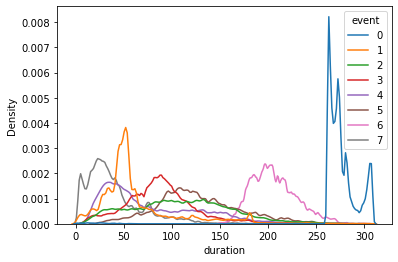

In [6]:
sns.kdeplot(data=y_train_l, x="duration", hue="event", bw_adjust=0.25, palette="tab10")

In [657]:
y_bal, x_bal, sign, categ, df = bal21_sample()
y_rand, x_rand, _, _, rd = rand21_sample()

sc = Scaler()
sc.fit([x_rand, x_bal])
x_rand = sc.transform(x_rand)
x_bal = sc.transform(x_bal)

y_rand = pd.DataFrame(y_rand)
y_rand, _ = transform_events(y_rand)
y_bal = pd.DataFrame(y_bal)
y_bal, dct = transform_events(y_bal)

In [427]:
x_train, x_test, y_train, y_test = train_test_split(x_bal, y_bal, test_size=0.2, stratify=y_bal.event, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, stratify=y_train.event, random_state = 1)

x_train_rand, x_test_rand, y_train_rand, y_test_rand = train_test_split(x_rand, y_rand, test_size=0.2, stratify=y_rand.event, random_state = 1)
x_train_rand, x_val_rand, y_train_rand, y_val_rand = train_test_split(x_train_rand, y_train_rand, test_size=0.25, stratify=y_train_rand.event, random_state = 1)


TIME_GRID = np.linspace(y_train['duration'].min(), y_train['duration'].max(), 100)

In [643]:
plt.figure(figsize=(7, 4))

<Figure size 700x400 with 0 Axes>

<Figure size 700x400 with 0 Axes>

<Axes: xlabel='duration', ylabel='Density'>

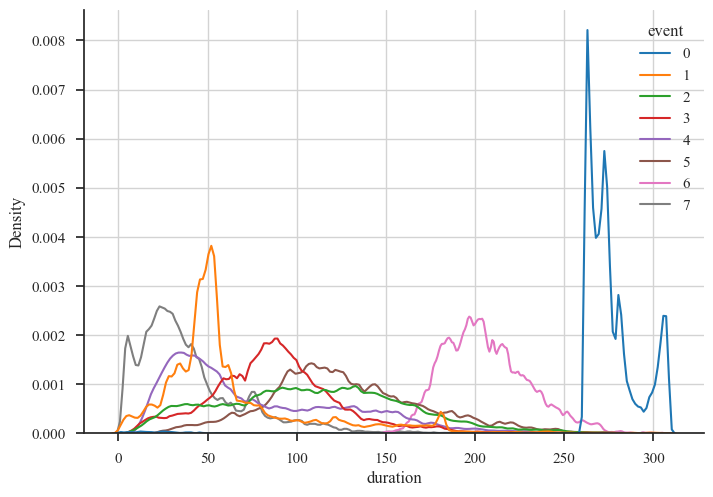

In [34]:
sns.kdeplot(data=y_train_l, x="duration", hue="event", bw_adjust=0.25, palette="tab10")

<Axes: xlabel='duration', ylabel='Density'>

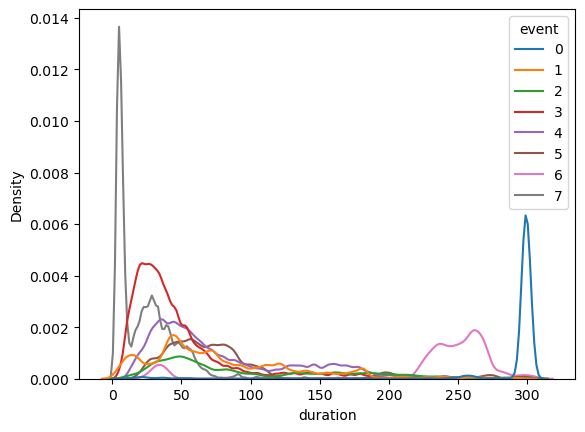

In [658]:
sns.kdeplot(data=y_rand, x="duration", hue="event", bw_adjust=0.25, palette="tab10")

## Анализ событий

In [9]:
df.groupby(by='event').time.agg(['min',
                                    ('Q1', lambda x: np.quantile(x, 0.25)),
                                    ('Q2', lambda x: np.quantile(x, 0.5)),
                                    ('Q3', lambda x: np.quantile(x, 0.75)),
                                    'max'])
# количество у всех одинаковое - 3000

,min,Q1,Q2,Q3,max
event,,,,,
0,1,283.00,286.0,290.0,296
1,0,12.00,19.0,29.0,287
2,6,40.75,78.0,156.0,285
3,4,34.00,95.0,128.0,281
9,7,33.00,50.0,90.0,289
15,33,155.00,171.0,212.0,286
16,178,218.00,231.0,242.0,290
96,0,17.00,26.0,35.0,276


# Модели

## AalenJohansenFitter (lifelines)



In [172]:
def AalenJohansenModel(y_train, y_test):
    events = sorted(y_train.event.unique())
    ibs = np.empty(shape=(len(y_train.event.unique())-1,))
    aj = AalenJohansenFitter()
    for i in events:
      if i>0:
#         print(i)
        T = y_train.duration[y_train.event.isin([i])]
        E = y_train.event[y_train.event.isin([i])]
        aj.fit(T, E, event_of_interest=i)
        curve = 1-aj.cumulative_density_[f'CIF_{i}']
        new_curve = transform_timegrid(curve.values, aj.cumulative_density_.index, TIME_GRID).T.astype(float)

        ibs_self = ibs_remain(
                        get_y_self_event(y_train, [i]),
                        get_y_self_event(y_test, [i]),
                        np.repeat(new_curve[np.newaxis, :], y_test.shape[0], axis=0)[y_test.event == i, :],
                        times=TIME_GRID, axis=-1)
        ibs[i-1] = ibs_self
#         print(ibs_self)
    return ibs
#         print(f"ibs {i:<2}:   {ibs_self:<4.4f}")

NameError: name 'ibs_remain' is not defined

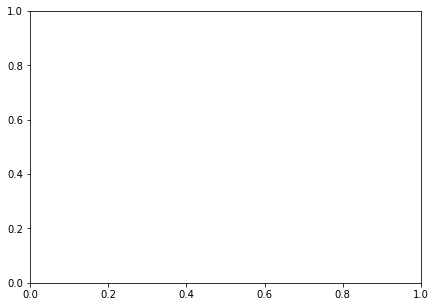

In [10]:
aj = AalenJohansenFitter()
fig, ax = plt.subplots(figsize=(7, 5))

for i in df.event.unique():
  if i:
    T = y_train.duration[y_train.event.isin([dct[i]])]
    E = y_train.event[y_train.event.isin([dct[i]])]
    aj.fit(T, E, event_of_interest=dct[i])
    curve = 1-aj.cumulative_density_[f'CIF_{dct[i]}']
    new_curve = transform_timegrid(curve.values, aj.cumulative_density_.index, TIME_GRID).T.astype(float)
    
    ibs_self = ibs_remain(
                    get_y_self_event(y_train, [dct[i]]),
                    get_y_self_event(y_test, [dct[i]]),
                    np.repeat(new_curve[np.newaxis, :], y_test.shape[0], axis=0)[y_test.event == dct[i], :],
                    times=TIME_GRID, axis=-1)
    print(f"ibs {i:<2}:   {ibs_self:<4.4f}")
    ax.plot(TIME_GRID,
                new_curve,
                label=f"event {i}")
ax.legend()
ax.set_title(f"Survival function by events")
ax.set_xlabel("Months")
ax.set_ylabel("Estimated Survival Probability")
plt.show()
# ibs 1 :   0.2223
# ibs 9 :   0.2035
# ibs 96:   0.2213
# ibs 16:   0.0996
# ibs 3 :   0.1942
# ibs 2 :   0.1917
# ibs 15:   0.1401

## SurvivalBoost (hazardous)

In [269]:
survival_boost = SurvivalBoost(show_progressbar=True).fit(x_train, y_train)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.46it/s]


1. **predict_survival_function** - предсказывает вероятность ненаступления любого из событий (т.е. функция выживания для любого события). Вычисляется на основе (2): predict_cumulative_incidence[:, 0, :]
2.**predict_cumulative_incidence** - кумулятивная функция риска для каждого типа событий, возвращает массив (n_samples, n_events + 1, n_times):
    *  array[:, 0, :] - вероятность отсутствия события( функция выживания для любого события (формула (*)))
    *   array[:, i, :] - cif_i, i=(0, 1, 2, 3, 9, 15, 16, 96)



(*) $$ S(t) = 1 - \sum_{k} cif_k$$

#### **predict_cumulative_incidence**

In [270]:
cif_sb = survival_boost.predict_cumulative_incidence(x_test, times=TIME_GRID)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.04it/s]


In [ ]:
cif_sb.shape

(4800, 8, 100)

Text(0, 0.5, 'Estimated Survival Probability')

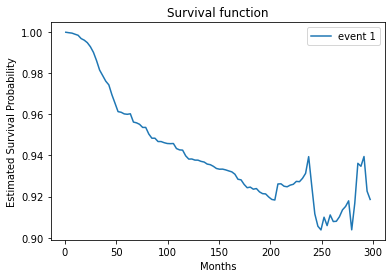

In [ ]:
fig, axs = plt.subplots(figsize=(6, 4))
axs.plot(TIME_GRID, 1-cif_sb[0][2], label=(f"event 1"))
axs.legend()
axs.set_title(f"Survival function")
axs.set_xlabel("Months")
axs.set_ylabel("Estimated Survival Probability")
#plt.plot(1-cif_sb[0][1])

In [177]:
def SurvivalBoostModel(x_train, y_train, x_test, y_test):
    ibs = np.empty(shape=(2, len(y_train.event.unique())-1))
    survival_boost = SurvivalBoost(show_progressbar=False).fit(x_train, y_train)
    cif_sb = survival_boost.predict_cumulative_incidence(x_test, times=TIME_GRID)
    for i in sorted(y_test.event.unique()):
      if i:
        sf = 1-cif_sb[:, i, :]
        ibs_old =  ibs_remain(get_y_self_event(y_train, [i]),
                           get_y_self_event(y_test, [i]), 
                           sf[y_test.event == i, :],
                           times=TIME_GRID, axis=-1)
        ibs[0][i-1] = ibs_old
        sf = transform_curves(sf)
        ibs_noninc =  ibs_remain(get_y_self_event(y_train, [i]),
                           get_y_self_event(y_test, [i]),
                           sf[y_test.event == i, :],
                           times=TIME_GRID, axis=-1)
        ibs[1][i-1] = ibs_noninc
    return ibs

In [247]:
SurvivalBoostModel(x_bal, y_bal, x_rand, y_rand)

array([[0.35027245, 0.63133113, 0.58859772, 0.54803743, 0.51348826,
        0.31185865, 0.40527567],
       [0.34287028, 0.62701322, 0.58197017, 0.54290013, 0.510594  ,
        0.30962794, 0.39333423]])

        noninc       old
1 ibs 1 :   0.2744     0.2804
2 ibs 2 :   0.4468     0.4549
3 ibs 3 :   0.3927     0.4041
4 ibs 9 :   0.3943     0.3994
5 ibs 15:   0.1454     0.1466
6 ibs 16:   0.1346     0.1381
7 ibs 96:   0.4784     0.4971


Text(0, 0.5, 'Estimated Survival Probability')

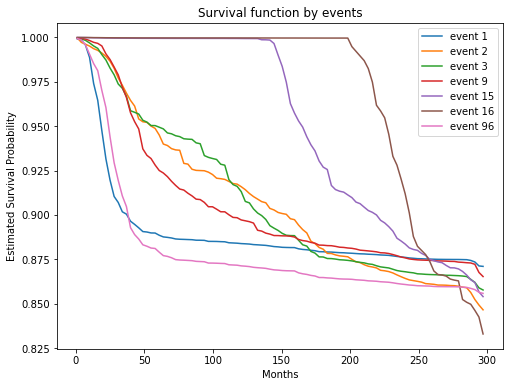

In [283]:
fig, axs = plt.subplots(figsize=(8, 6))
print('        noninc       old')
for i in sorted(df.event.unique()):
  if i:
    sf = 1-cif_sb[:, dct[i], :]
    #sf = transform_timegrid(sf, survival_boost.time_grid_, TIME_GRID)
    ibs_old =  ibs_remain(get_y_self_event(y_train, [dct[i]]),
                       get_y_self_event(y_test, [dct[i]]), 
                       sf[y_test.event == dct[i], :],
                       times=TIME_GRID, axis=-1)
    sf = transform_curves(sf)
    ibs =  ibs_remain(get_y_self_event(y_train, [dct[i]]),
                       get_y_self_event(y_test, [dct[i]]),
                       sf[y_test.event == dct[i], :],
                       times=TIME_GRID, axis=-1)
    print(f"{dct[i]} ibs {i:<2}:   {ibs:<4.4f}     {ibs_old:<4.4f}")
    axs.plot(TIME_GRID, sf.mean(axis=0), label=(f"event {i}"))
axs.legend()
axs.set_title(f"Survival function by events")
axs.set_xlabel("Months")
axs.set_ylabel("Estimated Survival Probability")

#### **predict_survival_function**

        old time_grid      new time_grid
ibs 1 :   0.06                 0.06    
ibs 9 :   0.07                 0.06    
ibs 96:   0.06                 0.06    
ibs 16:   0.08                 0.08    
ibs 3 :   0.07                 0.07    
ibs 2 :   0.08                 0.07    
ibs 15:   0.08                 0.08    
---------
 ibs: 0.06


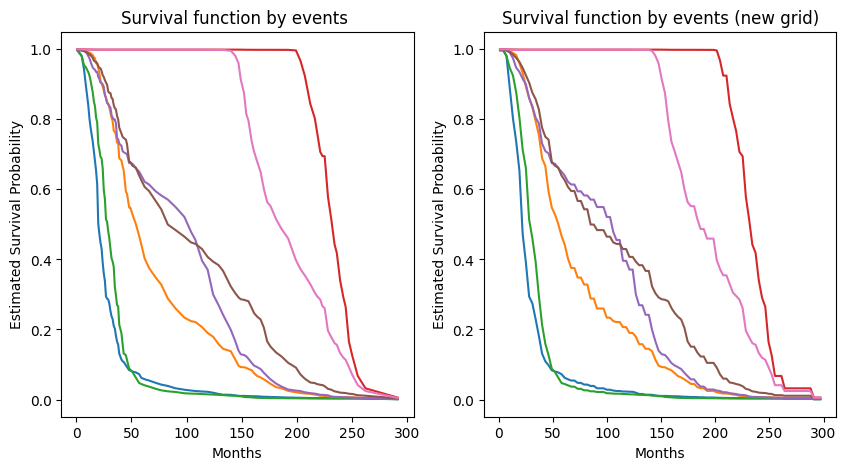

In [ ]:
curves = survival_boost.predict_survival_function(x_)
curves = transform_curves(curves)
curves_new = transform_timegrid(curves, survival_boost.time_grid_, TIME_GRID)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
scores=[]
print('        old time_grid      new time_grid')
for i in df.event.unique():
  if i:
    mask = y_test["event"] == dct[i]
    mean_survival = curves[mask].mean(axis=0)
    sf = transform_timegrid(mean_survival, survival_boost.time_grid_, TIME_GRID)
    sf = transform_curves(sf)

    ibs_1 = ibs_remain(get_y_event(y_train, [dct[i]]),
                       get_y_event(y_test, [dct[i]]), curves,
                       times=survival_boost.time_grid_, axis=-1)

    ibs_2 = ibs_remain(get_y_event(y_train, [dct[i]]),
                       get_y_event(y_test, [dct[i]]), curves_new,
                       times=TIME_GRID, axis=-1)
    print(f"{dct[i]} ibs {ev:<2}:   {ibs_1:<4.2f}                 {ibs_2:<8.2f}")

    #scores.append(ibs_)
    #print(f"ibs {ev}: {ibs_}")
    axs[0].plot(
        survival_boost.time_grid_,
        mean_survival,
        label=(f"event {i}"),
    )

    axs[1].plot(TIME_GRID, sf, label=(f"event {ev}"))
# ibs_ = ibs_remain(get_y_event(y_train, sorted(df.event.unique())[1:]),
#                   get_y_event(y_test, sorted(df.event.unique())[1:]), curves_new, times=TIME_GRID, axis=-1)
# scores.append(ibs_)
# print('---------\n', f"ibs: {ibs_:.2f}")
# ibs['SurvivalBoost']=scores
for i in (0, 1):
  axs[i].set_title(f"Survival function by events {i*'(new grid)'}")
  axs[i].set_xlabel("Months")
  axs[i].set_ylabel("Estimated Survival Probability")

plt.show()

## DeepHit (pycox)

In [272]:
get_x = lambda df: (df.values.astype('float32'))
get_target = lambda df: (df['duration'].values, df['event'].values)


class LabTransform(LabTransDiscreteTime):
    def transform(self, durations, events):
        durations, is_event = super().transform(durations, events > 0)
        events[is_event == 0] = 0
        return durations, events.astype('int64')


class CauseSpecificNet(torch.nn.Module):
    """Network structure similar to the DeepHit paper, but without the residual
    connections (for simplicity).
    """
    def __init__(self, in_features, num_nodes_shared, num_nodes_indiv, num_risks,
                 out_features, batch_norm=True, dropout=None):
        super().__init__()
        self.shared_net = tt.practical.MLPVanilla(
            in_features, num_nodes_shared[:-1], num_nodes_shared[-1],
            batch_norm, dropout,
        )
        self.risk_nets = torch.nn.ModuleList()
        for _ in range(num_risks):
            net = tt.practical.MLPVanilla(
                num_nodes_shared[-1], num_nodes_indiv, out_features,
                batch_norm, dropout,
            )
            self.risk_nets.append(net)

    def forward(self, input):
        out = self.shared_net(input)
        out = [net(out) for net in self.risk_nets]
        out = torch.stack(out, dim=1)
        return out

In [275]:
labtrans = LabTransform(100)
get_target = lambda df: (df['duration'].values, df['event'].values)

y_train_dh = labtrans.fit_transform(*get_target(y_train.sort_values(by='duration')))
y_val_dh = labtrans.transform(*get_target(y_val))
durations_test, events_test = get_target(y_test)
x_train_dh = get_x(x_train)
x_val_dh = get_x(x_val)
x_test_dh = get_x(x_test)
val = (x_val_dh, y_val_dh)
train = (x_train_dh, y_train_dh)

in_features = x_train_dh.shape[1]
num_nodes_shared = [64, 64]
num_nodes_indiv = [32]
num_risks = y_train_dh[1].max()
out_features = len(labtrans.cuts)
batch_norm = True
dropout = 0.1

# net = SimpleMLP(in_features, num_nodes_shared, num_risks, out_features)
net = CauseSpecificNet(in_features, num_nodes_shared, num_nodes_indiv, num_risks,
                       out_features, batch_norm, dropout)
optimizer = tt.optim.AdamWR(lr=0.01, decoupled_weight_decay=0.01,
                            cycle_eta_multiplier=0.8)
model = DeepHit(net, optimizer, alpha=0.2, sigma=0.1,
                duration_index=labtrans.cuts)

In [ ]:
import numpy as np
from sklearn.model_selection import ParameterSampler

N = 100
param_grid = {
    'batch_size': [128, 256, 512],
    'num_nodes_shared': [[64, 64], [128, 128], [256, 256]],
    'num_nodes_indiv': [[32], [64], [128]],
    'batch_norm': [True, False],
    'dropout': [0.1, 0.2, 0.3, 0.5],
    'lr': [0.01, 0.001, 0.0001],
    'decoupled_weight_decay': [0.01, 0.001, 0.0001],
    'alpha': [0.2, 0.4, 0.6],
    'sigma': [0.1, 0.2, 0.3]
}

param_list = list(ParameterSampler(param_grid, n_iter=N, random_state=42))

best_score = 100
best_params = None
best_model = None

for i, params in enumerate(param_list):
    print(i)
    in_features = x_train_dh.shape[1]
    num_nodes_shared = params['num_nodes_shared']
    num_nodes_indiv = params['num_nodes_indiv']
    num_risks = y_train_dh[1].max()
    out_features = len(labtrans.cuts)
    batch_norm = params['batch_norm']
    dropout = params['dropout']


    net = CauseSpecificNet(in_features, num_nodes_shared, num_nodes_indiv, num_risks,
                       out_features, batch_norm, dropout)

    lr_ = params['lr']
    dwd = params['decoupled_weight_decay']
    cem = 0.8

    optimizer = tt.optim.AdamWR(lr=lr_, decoupled_weight_decay=dwd, cycle_eta_multiplier=cem)

    model = DeepHit(net, optimizer, alpha=params['alpha'], sigma=params['sigma'], duration_index=labtrans.cuts)

    epochs = 512
    batch_size = params['batch_size']
    callbacks = [tt.callbacks.EarlyStoppingCycle()]
    verbose = False

    log = model.fit(x_train_dh, y_train_dh, batch_size, epochs, callbacks, verbose, val_data=val)

    score = model.log.to_pandas().val_loss.min()

    if score < best_score:
        best_score = score
        best_params = params
        best_model = model

print(best_score)
print('------------------')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
1.4327294826507568
------------------


{'sigma': 0.3, 'num_nodes_shared': [64, 64], 'num_nodes_indiv': [32], 'lr': 0.001, 'dropout': 0.3, 'decoupled_weight_decay': 0.01, 'batch_size': 512, 'batch_norm': False, 'alpha': 0.2}


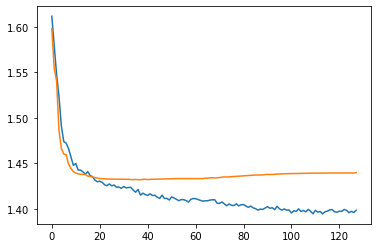

In [ ]:
print(best_params)
plt.plot(best_model.log.to_pandas())

In [276]:
best_params_ = {'sigma': 0.3, 'num_nodes_shared': [64, 64], 'num_nodes_indiv': [32], 'lr': 0.001, 'dropout': 0.3, 'decoupled_weight_decay': 0.01, 'batch_size': 512, 'batch_norm': False, 'alpha': 0.2}

in_features = x_train_dh.shape[1]
num_nodes_shared = best_params_['num_nodes_shared']
num_nodes_indiv = best_params_['num_nodes_indiv']
num_risks = y_train_dh[1].max()
out_features = len(labtrans.cuts)
batch_norm = best_params_['batch_norm']
dropout = best_params_['dropout']


net = CauseSpecificNet(in_features, num_nodes_shared, num_nodes_indiv, num_risks,
                       out_features, batch_norm, dropout)

lr_ = best_params_['lr']
dwd = best_params_['decoupled_weight_decay']
cem = 0.8

optimizer = tt.optim.AdamWR(lr=lr_, decoupled_weight_decay=dwd, cycle_eta_multiplier=cem)

model = DeepHit(net, optimizer, alpha=best_params_['alpha'], sigma=best_params_['sigma'], duration_index=labtrans.cuts)

epochs = 512
batch_size = best_params_['batch_size']
callbacks = [tt.callbacks.EarlyStoppingCycle()]
verbose = False

log = model.fit(x_train_dh, y_train_dh, batch_size, epochs, callbacks, verbose, val_data=val)
cif_dh = model.predict_cif(x_test_dh)

In [6]:
from pycox.models import DeepHit

class DeepHitWrapper:

    class LabTransform(LabTransDiscreteTime):
        def transform(self, durations, events):
            durations, is_event = super().transform(durations, events > 0)
            events[is_event == 0] = 0
            return durations, events.astype('int64')


    class CauseSpecificNet(torch.nn.Module):
        """Network structure similar to the DeepHit paper, but without the residual
        connections (for simplicity).
        """
        def __init__(self, in_features, num_nodes_shared, num_nodes_indiv, num_risks,
                     out_features, batch_norm=True, dropout=None):
            super().__init__()
            self.shared_net = tt.practical.MLPVanilla(
                in_features, num_nodes_shared[:-1], num_nodes_shared[-1],
                batch_norm, dropout,
            )
            self.risk_nets = torch.nn.ModuleList()
            for _ in range(num_risks):
                net = tt.practical.MLPVanilla(
                    num_nodes_shared[-1], num_nodes_indiv, out_features,
                    batch_norm, dropout,
                )
                self.risk_nets.append(net)

        def forward(self, input):
            out = self.shared_net(input)
            out = [net(out) for net in self.risk_nets]
            out = torch.stack(out, dim=1)
            return out
    
    @staticmethod
    def _get_x(df):
        return df.values.astype('float32')

    @staticmethod
    def _get_target(df):
        return df['duration'].values, df['event'].values

    def __init__(self):
        self.labtrans = DeepHitWrapper.LabTransform(100)
        self.best_params_ = {'sigma': 0.3, 'num_nodes_shared': [64, 64],
                            'num_nodes_indiv': [32], 'lr': 0.001, 'dropout': 0.3, 
                            'decoupled_weight_decay': 0.01, 'batch_size': 512,
                            'batch_norm': False, 'alpha': 0.2}
        self.model=None

    def fit(self, x_train, y_train, x_val, y_val):
        y_train_dh = self.labtrans.fit_transform(*self._get_target(y_train.sort_values(by='duration')))
        y_val_dh = self.labtrans.transform(*self._get_target(y_val))
        x_train_dh = self._get_x(x_train)
        x_val_dh = self._get_x(x_val)

        val = (x_val_dh, y_val_dh)
        train = (x_train_dh, y_train_dh)
        
        in_features = x_train_dh.shape[1]
        num_nodes_shared = self.best_params_['num_nodes_shared']
        num_nodes_indiv = self.best_params_['num_nodes_indiv']
        num_risks = y_train_dh[1].max()
        out_features = len(self.labtrans.cuts)
        batch_norm = self.best_params_['batch_norm']
        dropout = self.best_params_['dropout']


        net = DeepHitWrapper.CauseSpecificNet(in_features, num_nodes_shared, num_nodes_indiv, num_risks,
                               out_features, batch_norm, dropout)


        optimizer = tt.optim.AdamWR(lr=self.best_params_['lr'],
                                    decoupled_weight_decay=self.best_params_['decoupled_weight_decay'],
                                    cycle_eta_multiplier=0.8)

        self.model = DeepHit(net, optimizer, 
                        alpha=self.best_params_['alpha'], 
                        sigma=self.best_params_['sigma'], 
                        duration_index=self.labtrans.cuts)

        epochs = 512
        batch_size = self.best_params_['batch_size']
        callbacks = [tt.callbacks.EarlyStoppingCycle()]
        verbose = False

        log = self.model.fit(x_train_dh, y_train_dh, batch_size, epochs, callbacks, verbose, val_data=val)
        
        
        
       # cif_dh = model.predict_cif(x_test_dh)
       

    def predict(self, x_test):
        x_test_dh = self._get_x(x_test)
        return self.model.predict_cif(x_test_dh)


In [5]:
def DeepHitModel(x_train, y_train, x_val, y_val, x_test, y_test):
    ibs = np.empty(shape=(len(y_train.event.unique())-1, ))
    dh = DeepHitWrapper()
    dh.fit(x_train, y_train, x_val, y_val)
    cif = dh.predict(x_test)
    for i in y_train.event.unique():
      if i:
        sf1 = transform_timegrid((1-cif)[i-1], dh.model.duration_index, TIME_GRID)

        ibs_ = ibs_remain(get_y_self_event(y_train, [i]),
                          get_y_self_event(y_test, [i]),
                          sf1[y_test.event == i, :],
                          times=TIME_GRID, axis=-1)
        ibs[i-1] = ibs_
    return ibs
        

cif - трехмерный массив размера (96, 100, 4800), где

*   axis=0 - тип события, от 0 до 95 (используется только 8, zero_code -1 соотв.)
*   axis=1 - временная шкала
*   axis=2 - соответствующие наблюдения



In [279]:
def surv_func_1(cif, event_of_interest=1):
  return 1-(cif.transpose()[..., event_of_interest-1])

def surv_func_2(cif, event_of_interest=1):
  return 1 - (cif[df.event.unique()-1].sum(axis=0).T - (cif.transpose()[..., event_of_interest-1]))

def surv_func_3(cif, event_of_interest=1):
  return 1 - (cif.sum(axis=0).T - (cif.transpose()[..., event_of_interest-1]))

1. sf 1:  $$ S_k(t) = 1 - cif_k$$
1. sf 2:  $$ S_k(t) = 1 - \sum_{i!=k} cif_k, i\in (1, 2, 3, 9, 15, 16, 96)$$
1. sf 3:  $$ S_k(t) = 1 - \sum_{i=0, i!=k}^{95} cif_k$$

1 ibs 1 :   0.7240
4 ibs 9 :   0.5940
7 ibs 96:   0.7097
6 ibs 16:   0.1794
3 ibs 3 :   0.5401
2 ibs 2 :   0.5299
5 ibs 15:   0.3068
---------
 ibs: 0.4839


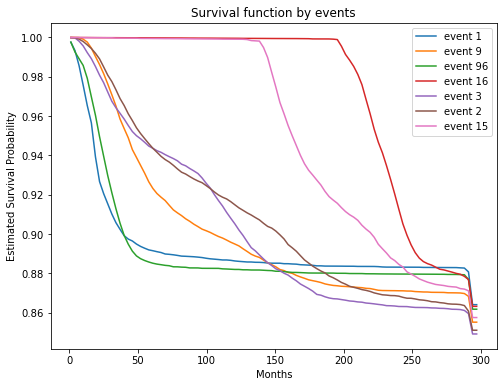

In [282]:
fig, axs = plt.subplots(figsize=(8, 6))
scores=[]
summ=np.empty(shape=model.duration_index.shape)
y_tmp = pd.DataFrame({'event': y_train_dh[1], 'duration': y_train_dh[0]})
#print('       до преобр.    после преобр.')
#print('        1-cif_k')
for i in df.event.unique():
  if i:

    sf1 = transform_timegrid(surv_func_1(cif_dh, dct[i]), model.duration_index, TIME_GRID)

    ibs_ = ibs_remain(get_y_self_event(y_tmp, [dct[i]]),
                      get_y_self_event(y_test, [dct[i]]),
                      sf1[y_test.event == dct[i], :],
                      times=TIME_GRID, axis=-1)

    print(f"{dct[i]} ibs {i:<2}:   {ibs_:<4.4f}")
    axs.plot(TIME_GRID,
          sf1.mean(axis=0),
          label=f"event {i}")


est = transform_timegrid(cif_dh.transpose()[..., sorted(y_train.event.unique())[:-1]].mean(axis=2),
              model.duration_index, TIME_GRID)

ibs_ = ibs_remain(get_y_event(y_tmp, sorted(df.event.unique())[1:]),
                  get_y_event(y_test, sorted(df.event.unique())[1:]),
                  est, TIME_GRID, axis=-1)

print('---------\n', f"ibs: {ibs_:.4f}")
# ibs['DeepHit']=scores
axs.legend()
axs.set_title(f"Survival function by events")
axs.set_xlabel("Months")
axs.set_ylabel("Estimated Survival Probability")

plt.show()

Здесь использовалось линейное преобразование  оси Y в [0, 1], т.к. cif_k <= 0.12 (+-) (т.к. $\sum_{k}cif_k + S(t) = 1$) (Аналогично в AalenJohansen, но там осталось 0.12)

---

ниже график S(t)

## CoxPH

[]

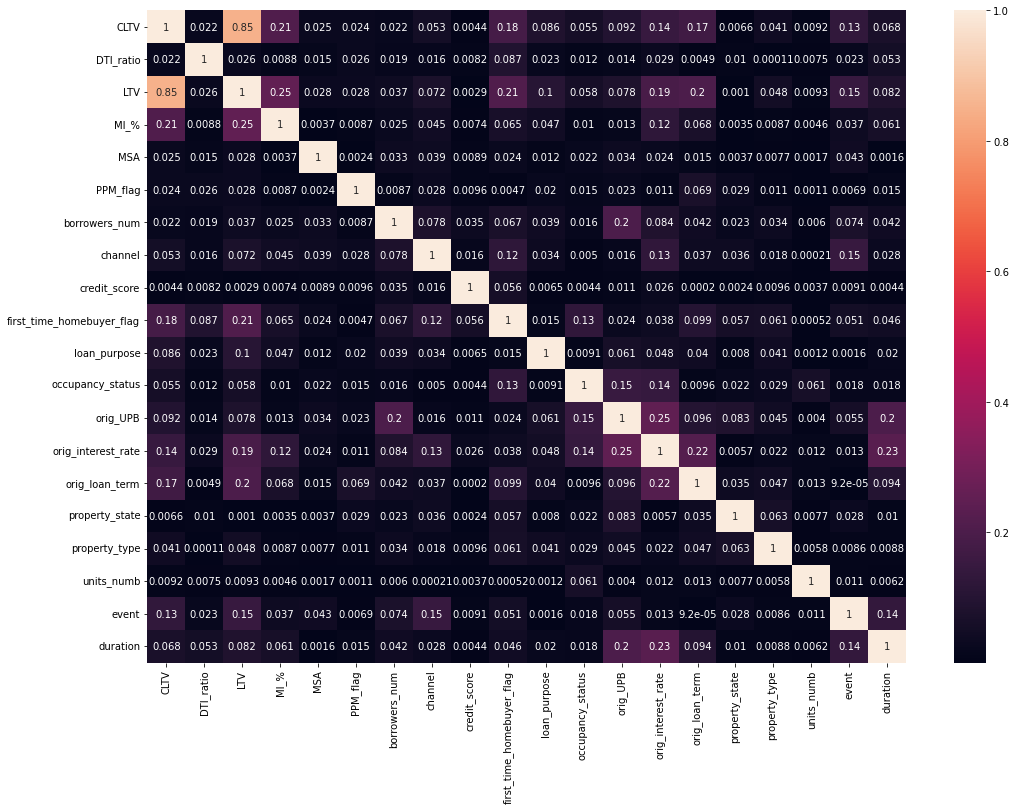

In [ ]:
corr_matrix = x.corr().abs()
plt.figure(figsize=(17, 12))
sns.heatmap(corr_matrix, annot=True)
plt.plot()

### Подбор гиперпараметров

In [ ]:
N = 20
param_grid = {
    'penalizer': np.logspace(-3, 2, N)
}

params = list(ParameterSampler(param_grid, n_iter=N, random_state=42))
x = x_train.join(y_train)

best_ibs = 10
best_params = None
best_model = None
events = df.event.unique()
olds = np.array([0.23, 0.20, 0.22, 0.14, 0.20, 0.19, 0.16])

for j, param in enumerate(params):
    tmp_ibs = np.empty(shape=(len(df.event.unique())-1, ))
    for i in events:
        if i:
            coxph = CoxPHFitter(penalizer=param['penalizer'])
            x_tmp = x.copy()
            x_tmp['event'] = x.event.isin([dct[i]]).astype('int')
            coxph.fit(x_tmp, duration_col='duration', event_col = 'event')
            sf = coxph.predict_survival_function(x_test, times=TIME_GRID)

            # ibs of model for current event and hyperparams

            ibs_ = ibs_remain(get_y_event(y_train, [dct[i]]),
                      get_y_event(y_test, [dct[i]]),
                      sf.T,
                      times=TIME_GRID, axis=-1)
            tmp_ibs[dct[i]-1] = ibs_

    if (sum(tmp_ibs < best_ibs) > sum(tmp_ibs > best_ibs)) or (sum(tmp_ibs > olds) < sum(best_ibs > olds)):
        # улучшение метрик по как можно большему числу событий
        # + чтобы в итоге все метрики оказались лучше того, что было в начале
            print('succ')
            best_ibs = tmp_ibs
            best_params = param
            best_model = coxph

print(best_ibs)
print(best_params)

succ
succ
[0.13689621 0.15429168 0.14252607 0.12563    0.05581295 0.05428058
 0.17203238]
{'penalizer': 0.02069138081114789}


### обучение моделей

           на себе+цензурированные      на себе     ранние цензурируются
ibs 1 :           0.1368                 0.5600           0.1251
ibs 9 :           0.1255                 0.4239           0.1436
ibs 96:           0.1719                 0.5937           0.1626
ibs 16:           0.0543                 0.0917           0.0540
ibs 3 :           0.1425                 0.3754           0.1357
ibs 2 :           0.1542                 0.3465           0.1407
ibs 15:           0.0558                 0.1372           0.0547


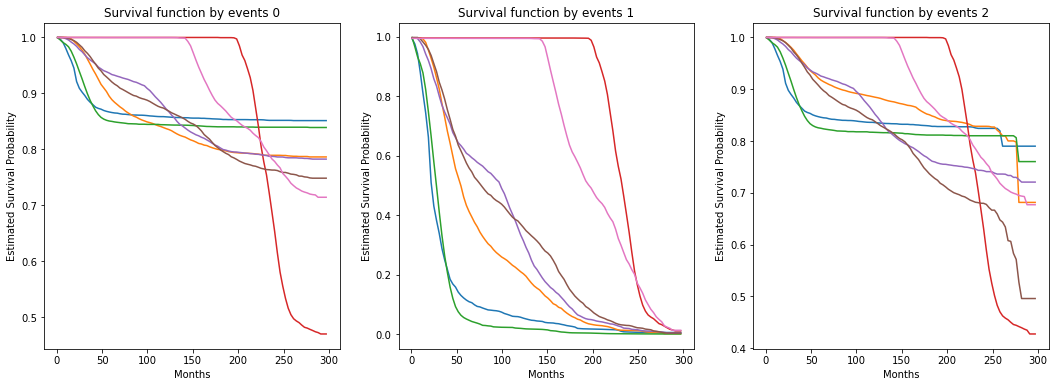

In [ ]:
# constant_cols=['int_only_flag', 'property_val_method', 'super_conf_flag', 'amortization_type']
x = x_train.join(y_train)
print('           на себе+цензурированные      на себе     ранние цензурируются')
coxph = CoxPHFitter(penalizer=0.02)
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
for i in df.event.unique():
  if i:
     #-------------------------  1 ---------------------------------

    x_tmp = x.copy()
    x_tmp['event'] = x.event.isin([dct[i]]).astype('int')
    coxph.fit(x_tmp, duration_col='duration', event_col = 'event')
    sf = coxph.predict_survival_function(x_test, times=TIME_GRID)

    ibs_1 = ibs_remain(get_y_event(y_train, [dct[i]]),
                      get_y_event(y_test, [dct[i]]),
                      sf.T,
                      times=TIME_GRID, axis=-1)
    ax[0].plot(TIME_GRID,
                sf.mean(axis=1),
                label=f"event {i}")

    #-------------------------  2 ---------------------------------

    x_, y_ = case2(x_train, y_train, [dct[i]])
    x_ = x_.join(y_)
    x_['event'] = x_.event.astype('int')

    coxph.fit(x_, duration_col='duration', event_col = 'event')
    sf = coxph.predict_survival_function(x_test, times=TIME_GRID)

    ibs_2 = ibs_remain(get_y_event(y_train, [dct[i]]),
                      get_y_event(y_test, [dct[i]]),
                      sf.T,
                      times=TIME_GRID, axis=-1)
    ax[1].plot(TIME_GRID,
                sf.mean(axis=1),
                label=f"event {i}")

    #-------------------------  3 ---------------------------------

    x_, y_ = case3(x_train, y_train, [dct[i]])
    x_ = x_.join(y_)
    x_['event'] = x_.event.astype('int')

    coxph.fit(x_, duration_col='duration', event_col = 'event')
    sf = coxph.predict_survival_function(x_test, times=TIME_GRID)

    ibs_3 = ibs_remain(get_y_event(y_train, [dct[i]]),
                      get_y_event(y_test, [dct[i]]),
                      sf.T,
                      times=TIME_GRID, axis=-1)

    #--------------------------------------------------------------
    print(f"ibs {i:<2}:           {ibs_1:<4.4f}                 {ibs_2:<4.4f}           {ibs_3:<4.4f}")

    ax[2].plot(TIME_GRID,
                sf.mean(axis=1),
                label=f"event {i}")
for i in (0, 1, 2):
    ax[i].set_title(f"Survival function by events {i}")
    ax[i].set_xlabel("Months")
    ax[i].set_ylabel("Estimated Survival Probability")
plt.show()


## RSF

### Подбор гиперпараметров

In [ ]:
N = 40
param_grid = {
    "n_estimators": [20, 50, 100, 300],
    "min_samples_split": [2, 6, 10],
    "min_samples_leaf": [2, 4],
    "max_features": ["sqrt", "log2", None],
}

params = list(ParameterSampler(param_grid, n_iter=N, random_state=42))

best_ibs = 10
best_params = None
best_model = None

for j, param in enumerate(params):
    print(j)
    tmp_ibs = np.empty(shape=(len(df.event.unique())-1, ))
    for i in df.event.unique():
        if i:
            rsf = RandomSurvivalForest(random_state=42,
                                       n_jobs=-1,
                                       n_estimators=param['n_estimators'],
                                       min_samples_split=param['min_samples_split'],
                                       min_samples_leaf=param['min_samples_leaf'],
                                       max_depth = param['max_depth'],
                                       max_features = param['max_features']
                                      )
            y_tmp = y_train.copy()
            y_tmp['event'] = y_train.event.isin([dct[i]]).astype('int')

            rsf.fit(x_train, get_y_event(y_train, [dct[i]]))
            sf = rsf.predict_survival_function(x_test)
            sf, times = step_to_array(sf)
            sf = transform_timegrid(sf, times, TIME_GRID)
            # ibs of model for current event and hyperparams

            ibs_ = ibs_remain(get_y_event(y_train, [dct[i]]),
                      get_y_event(y_test, [dct[i]]),
                      sf,
                      times=TIME_GRID, axis=-1)
            tmp_ibs[dct[i]-1] = ibs_

    if (sum(tmp_ibs < best_ibs) > sum(tmp_ibs > best_ibs)) or (sum(tmp_ibs > olds) < sum(best_ibs > olds)):
        # улучшение метрик по как можно большему числу событий
        # + чтобы в итоге все метрики оказались лучше того, что было в начале
            best_ibs = tmp_ibs
            best_params = param
            best_model = coxph

print(best_ibs)
print(best_params)

succ
succ
succ
succ
succ
succ
[0.08934052 0.14434872 0.1308987  0.11195583 0.05499782 0.05209439
 0.14749165]
{'n_estimators': 365, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': None}


### обучение моделей

           на себе+цензурированные      на себе     ранние цензурируются
ibs 1 :           0.1017                 0.5847           0.1238
ibs 9 :           0.1196                 0.4506           0.1160
ibs 96:           0.1591                 0.5982           0.1491
ibs 16:           0.0516                 0.0929           0.0498
ibs 3 :           0.1343                 0.3795           0.1271
ibs 2 :           0.1486                 0.3634           0.1419
ibs 15:           0.0559                 0.1574           0.0550


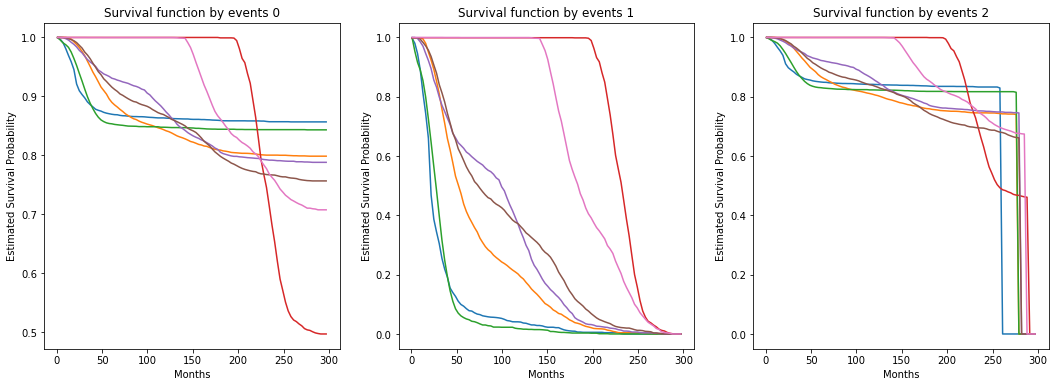

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
print('           на себе+цензурированные      на себе     ранние цензурируются')
rsf = RandomSurvivalForest(random_state=42, n_jobs=-1, n_estimators=350, min_samples_split=10, min_samples_leaf=4)
for i in df.event.unique():
  if i:

    #-------------------------  1 --------------------------------

    y_tmp = y_train.copy()
    y_tmp['event'] = y_train.event.isin([dct[i]]).astype('int')

    rsf.fit(x_train, get_y_event(y_train, [dct[i]]))
    sf = rsf.predict_survival_function(x_test)
    sf, times = step_to_array(sf)
    sf = transform_timegrid(sf, times, TIME_GRID)

    ibs_1 = ibs_remain(get_y_event(y_train, [dct[i]]),
                      get_y_event(y_test, [dct[i]]),
                      sf,
                      times=TIME_GRID, axis=-1)
    ax[0].plot(TIME_GRID, sf.mean(axis=0), label=f"event {i}")

    #-------------------------  2 --------------------------------

    x_train_, y_train_ = case2(x_train, y_train, [dct[i]])
    y_train_['event'] = y_train_.event.astype('int')

    rsf.fit(x_train_, get_y_arr(y_train_))
    sf = rsf.predict_survival_function(x_test)
    sf, times = step_to_array(sf)
    sf = transform_timegrid(sf, times, TIME_GRID)

    ibs_2 = ibs_remain(get_y_event(y_train, [dct[i]]),
                      get_y_event(y_test, [dct[i]]),
                      sf,
                      times=TIME_GRID, axis=-1)

    ax[1].plot(TIME_GRID, sf.mean(axis=0), label=f"event {i}")

    #-------------------------  3 --------------------------------

    x_train_, y_train_ = case3(x_train, y_train, [dct[i]])
    y_train_['event'] = y_train_.event.astype('int')

    rsf.fit(x_train_, get_y_arr(y_train_))
    sf = rsf.predict_survival_function(x_test)
    sf, times = step_to_array(sf)
    sf = transform_timegrid(sf, times, TIME_GRID)

    ibs_3 = ibs_remain(get_y_event(y_train, [dct[i]]),
                      get_y_event(y_test, [dct[i]]),
                      sf,
                      times=TIME_GRID, axis=-1)

    ax[2].plot(TIME_GRID, sf.mean(axis=0), label=f"event {i}")
    #--------------------------------------------------------------
    print(f"ibs {i:<2}:           {ibs_1:<4.4f}                 {ibs_2:<4.4f}           {ibs_3:<4.4f}")

for i in (0, 1, 2):
    ax[i].set_title(f"Survival function by events {i}")
    ax[i].set_xlabel("Months")
    ax[i].set_ylabel("Estimated Survival Probability")
plt.show()

## GBSA

In [ ]:
N = 40
param_dist = {
    "n_estimators":[50, 100, 200, 400],
    "learning_rate": np.logspace(-3, 0, 10),
    "max_depth": [3, 5, 7, 10],
    "subsample": np.linspace(0.5, 1.0, 5),
}

params = list(ParameterSampler(param_grid, n_iter=N, random_state=42))

best_ibs = 10
best_params = None
best_model = None

for j, param in enumerate(params):
    print(j)
    tmp_ibs = np.empty(shape=(len(df.event.unique())-1, ))
    for i in df.event.unique():
        if i:
            gbsa = GradientBoostingSurvivalAnalysis(random_state=42)
            y_tmp = y_train.copy()
            y_tmp['event'] = y_train.event.isin([dct[i]]).astype('int')

            gbsa.fit(x_train, get_y_event(y_train, [dct[i]]))
            sf = gbsa.predict_survival_function(x_test)
            sf, times = step_to_array(sf)
            sf = transform_timegrid(sf, times, TIME_GRID)
                # ibs of model for current event and hyperparams

            ibs_ = ibs_remain(get_y_event(y_train, [dct[i]]),
                        get_y_event(y_test, [dct[i]]),
                        sf,
                        times=TIME_GRID, axis=-1)
            tmp_ibs[dct[i]-1] = ibs_

    if (sum(tmp_ibs < best_ibs) > sum(tmp_ibs > best_ibs)) or (sum(tmp_ibs > olds) < sum(best_ibs > olds)):
        # улучшение метрик по как можно большему числу событий
        # + чтобы в итоге все метрики оказались лучше того, что было в начале
            best_ibs = tmp_ibs
            best_params = param
            best_model = coxph

print(best_ibs)
print(best_params)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
[0.12105186 0.15817511 0.15305534 0.13073905 0.06017743 0.05394901
 0.01535475]
{'n_estimators': 470, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None}


           на себе+цензурированные      на себе     ранние цензурируются
ibs 1 :           0.1211                 0.5641           0.1312
ibs 9 :           0.1307                 0.4463           0.1208
ibs 96:           0.1753                 0.6057           0.1599
ibs 16:           0.0539                 0.0931           0.0518
ibs 3 :           0.1531                 0.3878           0.1390
ibs 2 :           0.1582                 0.3685           0.1445
ibs 15:           0.0602                 0.1478           0.0590


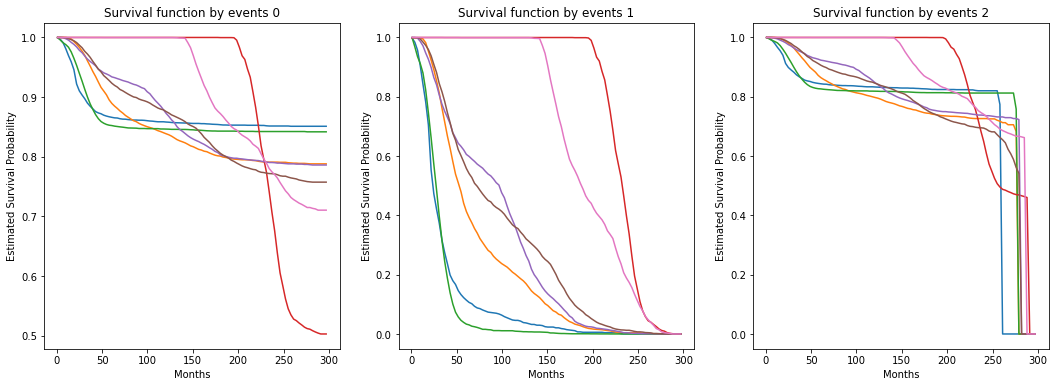

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
print('           на себе+цензурированные      на себе     ранние цензурируются')
gbsa = GradientBoostingSurvivalAnalysis(random_state=42)
for i in df.event.unique():
  if i:
    #-------------------------  1 --------------------------------
    #gbsa = GradientBoostingSurvivalAnalysis(random_state=42)# min_samples_split=5, min_samples_leaf=2, max_features='log2')
    y_tmp = y_train.copy()
    y_tmp['event'] = y_train.event.isin([dct[i]]).astype('int')

    gbsa.fit(x_train, get_y_event(y_train, [dct[i]]))
    sf = gbsa.predict_survival_function(x_test)
    sf, times = step_to_array(sf)
    sf = transform_timegrid(sf, times, TIME_GRID)

    ibs_1 = ibs_remain(get_y_event(y_train, [dct[i]]),
                      get_y_event(y_test, [dct[i]]),
                      sf,
                      times=TIME_GRID, axis=-1)
    ax[0].plot(TIME_GRID,
                sf.mean(axis=0),
                label=f"event {i}")

    #-------------------------  2 --------------------------------
    x_train_, y_train_ = case2(x_train, y_train, [dct[i]])
    y_train_['event'] = y_train_.event.astype('int')

    gbsa.fit(x_train_, get_y_arr(y_train_))
    sf = gbsa.predict_survival_function(x_test)
    sf, times = step_to_array(sf)
    sf = transform_timegrid(sf, times, TIME_GRID)

    ibs_2 = ibs_remain(get_y_event(y_train, [dct[i]]),
                      get_y_event(y_test, [dct[i]]),
                      sf,
                      times=TIME_GRID, axis=-1)

    ax[1].plot(TIME_GRID, sf.mean(axis=0), label=f"event {i}")

    #-------------------------  3 --------------------------------

    x_train_, y_train_ = case3(x_train, y_train, [dct[i]])
    y_train_['event'] = y_train_.event.astype('int')

    gbsa.fit(x_train_, get_y_arr(y_train_))
    sf = gbsa.predict_survival_function(x_test)
    sf, times = step_to_array(sf)
    sf = transform_timegrid(sf, times, TIME_GRID)

    ibs_3 = ibs_remain(get_y_event(y_train, [dct[i]]),
                      get_y_event(y_test, [dct[i]]),
                      sf,
                      times=TIME_GRID, axis=-1)

    ax[2].plot(TIME_GRID, sf.mean(axis=0), label=f"event {i}")
    #--------------------------------------------------------------
    print(f"ibs {i:<2}:           {ibs_1:<4.4f}                 {ibs_2:<4.4f}           {ibs_3:<4.4f}")

for i in (0, 1, 2):
    ax[i].set_title(f"Survival function by events {i}")
    ax[i].set_xlabel("Months")
    ax[i].set_ylabel("Estimated Survival Probability")
plt.show()
# ibs 1 :   0.12
# ibs 9 :   0.13
# ibs 96:   0.18
# ibs 16:   0.05
# ibs 3 :   0.15
# ibs 2 :   0.16
# ibs 15:   0.06

## Классы-обертки (OvR, MetaModel)

In [5]:
from typing import List

In [10]:
class OvR:
    def __init__(self, estimator, mode, early_threshold=1.0):
        self.estimator = estimator
        self.mode = mode       # early, all, single
        self.models = None
        self.events = None
        self.TIME_GRID = None
        self.thrsh = early_threshold

    def step_to_array(self, step_functions):
        shape_=(step_functions.shape[0], step_functions[0].x.shape[0])
        arr = np.empty(shape=shape_)
        for i in range(len(step_functions)):
            arr[i] = step_functions[i].y
        return arr, step_functions[0].x

    def transform_timegrid(self, curves, time, grid):
        if time.max() < grid.max():
            time = np.hstack([time, np.array([grid.max()+1])])
            if len(curves.shape)==1:
                curves = np.hstack([curves, np.array([0])])
            elif len(curves.shape)==2:
                curves = np.hstack([curves, np.zeros(shape=(curves.shape[0], 1))])
        ind = np.searchsorted(time, grid)
        if len(curves.shape)==1:
            return curves[ind]
        elif len(curves.shape)==2:
            return curves[:, ind]
        else:
            return None

    def transform_xy(self, X, y, events: List=[], event_of_interest=None):
        if self.mode == 'all':
            X, y = self.case1(X, y, events)
        elif self.mode == 'single':
            X, y = self.case2(X, y, events)
        elif self.mode == 'early':
            X, y = self.case3(X, y, events, early_threshold=self.thrsh)
        elif self.mode == 'mix':
            if event_of_interest in {5, 6}:
                X, y = self.case3(X, y, events, early_threshold=self.thrsh)
            else:
                X, y = self.case2(X, y, events)
        else:
            raise ValueError('Wrong mode')
        return X, y

    def case1(self, X_, y_, events: List=[]):
        y, X = y_.copy(), X_.copy()
        mask = y_.event.isin(events)
        y.event = mask.astype('int')
        return X, y

    def case2(self, X_, y_, events: List=[]):
        y, X = y_.copy(), X_.copy()
        mask = y_.event.isin(events)
        y.event = mask
        y = y[mask]
        X = X[mask]
        y.event = y.event.astype('int')
        return X, y

    def case3(self, X_, y_, events: List=[], early_threshold=1.0):
        y, X = y_.copy(), X_.copy()
        mask = y_.event.isin(events)
        maxm = y_.duration[mask].quantile(early_threshold)
        y.event = mask
        X = X[y.duration<=maxm]
        y = y[y.duration<=maxm]
        y.event = y.event.astype('int')
        return X, y

    def fit(self, X_, y_):
        self.TIME_GRID = np.linspace(y_['duration'].min(), y_['duration'].max(), 100)
        self.model = []
        self.events = y_.event.unique()
        for i in sorted(self.events):
            if i:
                tmp = copy.deepcopy(self.estimator)
                X, y = self.transform_xy(X_, y_, [i], i)
                if type(self.estimator) == CoxPHFitter:
                    X = X.join(y)
                    tmp.fit(X, duration_col='duration', event_col = 'event')
                elif isinstance(self.estimator, AalenJohansenFitter):
                    T, E = y.duration, y.event
                    tmp.fit(T, E, event_of_interest=1)
                else:
                    y = get_y_arr(y)
                    tmp.fit(X, y)
                self.model.append(tmp)

    def predict(self, X_):
        """
        shape (6, 4800, 100)
        
        """
        predictions = np.empty(shape=(len(self.events)-1, X_.shape[0], 100))
        for i in sorted(self.events):
            if i:
                if type(self.estimator) == CoxPHFitter:
                    sf = (self.model[i-1].predict_survival_function(X_, times=TIME_GRID)).T
                elif isinstance(self.estimator, AalenJohansenFitter):
                    sf = 1-self.model[i-1].cumulative_density_[f'CIF_1']
                    sf = transform_timegrid(sf.values, self.model[i-1].cumulative_density_.index, TIME_GRID).T.astype(float)
                    sf = np.repeat(sf[np.newaxis, :], X_.shape[0], axis=0)
                else:
                    sf = self.model[i-1].predict_survival_function(X_)
                    sf, times = step_to_array(sf)
                    sf = transform_timegrid(sf, times, TIME_GRID)
                predictions[i-1]=sf
        return predictions



In [11]:
class SurvivalBoost:
    pass

In [12]:
class MetaModel:
    def __init__(self, estimator, mode='weighted'):
        self.ovr = estimator
        self.meta_model = RandomForestClassifier(n_jobs=-1, random_state=42)
        self.mode = mode

    def fit(self, X_, y_, X_val=None, y_val=None):
        if (not (X_val is None)): self.ovr.fit(X_, y_, X_val, y_val)
        else: self.ovr.fit(X_, y_)
        mask = y_.event>0
        self.meta_model.fit(X_[mask], y_.event[mask])

    def predict(self, X_):
        all_preds = self.ovr.predict(X_) # (7, 4800, 100)
        if self.mode == 'best':
            events_pred = self.meta_model.predict(X_)
            selected_preds = np.zeros((X_.shape[0], 100)) # (4800, 100)
            for i in range(X_.shape[0]):
                selected_preds[i] = all_preds[events_pred[i]-1, i, :]
            return selected_preds
        elif self.mode == 'weighted':
            events_pred = self.meta_model.predict_proba(X_)
            tmp = np.moveaxis(all_preds, (0, 1, 2), (1, 0, 2))
            return np.sum(tmp * events_pred[..., np.newaxis], axis=1)

In [31]:
# wewewe
model = MetaModel(OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='all', early_threshold=0.99), mode='best')
model.fit(x_train, y_train)

In [32]:
# import joblib
# joblib.dump(model, 'model_weighted_all.pkl.gz', compress=3)

import gzip, pickle
with gzip.open('D:\SurvivalAnalysis\CompetingRisk\model_rsf_all_best.pkl.gz', 'wb') as f:
    pickle.dump(model, f)

In [17]:
def get_y_self_event(y_, events: List=[]):
    l = sum(y_.event.isin(events))
    y = np.empty(dtype=[('event', bool), ('duration', np.float64)], shape=l)
    y["duration"] = y_[y_.event.isin(events)]["duration"]
    y["event"] = 1
    return y

In [ ]:
# TPR, FPR

In [ ]:
### OvR(RSF) в качестве мета-модели

$ IBS = \frac{1}{|X|} \sum_{x \in X}^{}IBS_{event=1}(x) $

берем все прогнозы и считаем все event на 1 (все терминальные)
я так понимаю, считаем все варианты закрытия кредита за 1 (все события терминальные),
а незакрытые кредиты считаем 0 (цензурированные), и считаем ibs только на терминальных

In [98]:
rsf = RandomSurvivalForest(n_jobs=-1, random_state=42)
early_threshold=0.99

ovr = OvR(rsf, mode='early', early_threshold=early_threshold)
meta = MetaModel(ovr, mode='early')
meta.fit(x_train, y_train)
preds = meta.predict(x_test)

ibs_self = ibs_remain(
        get_y_self_event(y_train, dct.values()),
        get_y_self_event(y_test, dct.values()),
        preds[y_test.event.isin(dct.values()), :],
        times=TIME_GRID)

print(ibs_self)


0.18672112976080044


Сравнение с другими моделями

In [ ]:
early_threshold=0.99
ovr_aj = OvR(AalenJohansenFitter(), mode='early', early_threshold=early_threshold)
meta_aj = MetaModel(ovr_aj)
meta_aj.fit(x_train, y_train)
preds = meta_aj.predict(x_test)

ibs_self = ibs_remain(
        get_y_self_event(y_train, dct.values()),
        get_y_self_event(y_test, dct.values()),
        preds[y_test.event.isin(dct.values()), :],
        times=TIME_GRID)

print(ibs_self)

0.3122179472406777


In [ ]:
y_train_sb = y_train.copy()
y_train_sb.event = (y_train_sb.event > 0).astype(int)
sb = SurvivalBoost(show_progressbar=True).fit(x_train, y_train_sb)

meta_sb = MetaModel(sb)
meta_sb.fit(x_train, y_train)
cif_sb = meta_sb.predict(x_test)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.57it/s]


In [ ]:
ibs_self = ibs_remain(
        get_y_self_event(y_train, dct.values()),
        get_y_self_event(y_test, dct.values()),
        cif_sb[y_test.event.isin(dct.values()), :],
        times=TIME_GRID
    )

print(np.mean(ibs_self))

0.430391338263829


метрики с подобранными гиперпараметрами

In [22]:
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelBinarizer

rf_model = RandomForestClassifier(n_jobs = -1, random_state=42, n_estimators=300, min_samples_leaf=2)

mask = y_train.event>0
X_meta = x_train[mask]
y_meta = y_train.event[mask]
rf_model.fit(X_meta, y_meta)

mask = y_test.event>0
preds = rf_model.predict((x_test[mask]))
preds_prob = rf_model.predict_proba(x_test[mask])
label_binarizer = LabelBinarizer()
y_test_bin = label_binarizer.fit_transform(y_test[mask]['event'])

print(f"f1: {f1_score(y_test[mask]['event'], preds, average='macro')}")
print(f"roc-auc macro: {roc_auc_score(y_test[mask]['event'], preds_prob, average='macro', multi_class='ovr')}")
print(f"roc-auc samples: {roc_auc_score(y_test_bin, preds_prob, average='samples', multi_class='ovr')}")
print("accuracy:", accuracy_score(y_test[mask]['event'], preds))

m = confusion_matrix(y_test[mask]['event'], preds)
print(m)


f1: 0.5248387078445382
roc-auc macro: 0.8541320889212828
roc-auc samples: 0.8324217687074831
accuracy: 0.5393061224489796
[[5939   98   18  614  106   46  179]
 [ 698 2282 1225 1149  462  769  415]
 [ 190  757 3734  849  574  567  329]
 [ 630  119   67 5488   47  119  530]
 [ 233  524  669  310 4079  647  538]
 [ 389  852  945 1230  722 2454  408]
 [ 443  472  632 1771  819  413 2450]]


In [57]:
labels = [f'Тип {i}' for i in range(1, 8)]
cm = np.array([[5939,   98,   18,  614,  106,   46,  179],
               [ 698, 2282, 1225, 1149,  462,  769,  415],
               [ 190,  757, 3734,  849,  574,  567,  329],
               [ 630,  119,   67, 5488,   47,  119,  530],
               [ 233,  524,  669,  310, 4079,  647,  538],
               [ 389,  852,  945, 1230,  722, 2454,  408],
               [ 443,  472,  632, 1771,  819,  413, 2450]])
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

cm_df.index.name = 'Истинный'
cm_df.columns.name = 'Предсказанный'
cm_df

Предсказанный,Тип 1,Тип 2,Тип 3,Тип 4,Тип 5,Тип 6,Тип 7
Истинный,,,,,,,
Тип 1,5939,98,18,614,106,46,179
Тип 2,698,2282,1225,1149,462,769,415
Тип 3,190,757,3734,849,574,567,329
Тип 4,630,119,67,5488,47,119,530
Тип 5,233,524,669,310,4079,647,538
Тип 6,389,852,945,1230,722,2454,408
Тип 7,443,472,632,1771,819,413,2450


In [34]:
model = OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='single', early_threshold=early_threshold)
model.fit(x_train, y_train)
preds = model.predict(x_test)

In [46]:
# a = np.array([[[0.9, 0.6, 0.4, 0.3], [0.86, 0.79, 0.55, 0.43], [0.8, 0.7, 0.5, 0.2]],
#               [[0.7, 0.65, 0.54, 0.33], [0.81, 0.69, 0.55, 0.21], [0.65, 0.6, 0.45, 0.1]],
#               [[0.5, 0.36, 0.2, 0.1], [0.9, 0.61, 0.35, 0.3], [0.83, 0.55, 0.52, 0.25]]])

def tpr(pred, y_true):
    n_risks, n_samples, n_times = pred.shape
    # pred = np.moveaxis(pred, (0, 1, 2), (1, 0, 2))
    
    y_true_event = np.array(y_test['event'])
    predicted_risks = np.argmin(pred, axis=0) + 1
    binary_tensor = (predicted_risks == y_true_event[:, np.newaxis]).astype(int)
    risk_values = np.arange(1, 8)[:, np.newaxis] 
    true_risk_matrix = (y_true_event[np.newaxis, :] == risk_values)
    n_positive = np.sum(true_risk_matrix, axis=1)
    n_negative = n_samples - n_positive
    tpr = np.zeros((n_risks, n_times))
    
    for k in range(n_risks):
      tpr[k, :] = np.sum(binary_tensor[true_risk_matrix[k], :], axis=0) / n_positive[k]
    return tpr

In [114]:
def plot_tpr_curves(tpr, time_points, n_risks=7):

    plt.figure(figsize=(8, 5))
    colors = plt.cm.tab10(np.linspace(0, 1, n_risks))
    
    for k in range(n_risks):
        plt.plot(time_points, tpr[k, :], label=f'тип {k+1}', 
                 linewidth=2, color=colors[k])
    
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('TPR', fontsize=10)
    plt.title('TPR', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
              fontsize=10, framealpha=0.95, ncol=1)
    plt.grid(True, alpha=0.3)
    plt.ylim([0, 1.05])
    plt.tight_layout()
    plt.show()

def plot_fpr_curves(tpr, time_points, n_risks=7):

    plt.figure(figsize=(8, 5))
    colors = plt.cm.tab10(np.linspace(0, 1, n_risks))
    
    for k in range(n_risks):
        plt.plot(time_points, tpr[k, :], label=f'тип {k+1}', 
                 linewidth=2, color=colors[k])
    
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('FPR', fontsize=10)
    plt.title('FPR', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
              fontsize=10, framealpha=0.95, ncol=1)
    plt.grid(True, alpha=0.3)
    plt.ylim([0, 1.05])
    plt.tight_layout()
    plt.show()

In [125]:

def plot_tpr_fpr_combined(tpr, fpr, time_points, n_risks=7, ):
   
    plt.figure(figsize=(8, 5))
    colors = plt.cm.tab10(np.linspace(0, 1, n_risks))
    
    for k in range(n_risks):
        plt.plot(time_points, tpr[k, :], 
                label=f'TPR Тип {k+1}', 
                linewidth=1.5, 
                color=colors[k],
                linestyle='-',
                alpha=1.0)
    
    for k in range(n_risks):
        plt.plot(time_points, fpr[k, :], 
                label=f'FPR Тип {k+1}', 
                linewidth=1, 
                color=colors[k],
                linestyle='--',
                alpha=0.6)
    
    plt.title('TPR и FPR', 
              fontsize=12, pad=20)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
              fontsize=10, framealpha=0.95, ncol=1)
    
    # plt.legend(loc='best', ncol=2, fontsize=10, framealpha=0.9)
    plt.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
    # plt.ylim([0, 1.05])
    # plt.xlim([time_points[0], time_points[-1]])
    
    plt.axhline(y=0.5, color='gray', linestyle=':', alpha=0.3, linewidth=1)
    plt.axhline(y=1.0, color='gray', linestyle=':', alpha=0.3, linewidth=1)
    
    plt.tight_layout()
    plt.show()

In [76]:
def plot_auc_curves(auc, time_points, n_risks=7):

    plt.figure(figsize=(, 5))
    
    for k in range(n_risks):
        plt.plot(time_points, auc[k, :], label=f'тип {k+1}', 
                 linewidth=2)
    
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('auc', fontsize=10)
    plt.title('AUC', fontsize=12)
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [148]:
def fpr(pred, y_true):
    n_risks, n_samples, n_times = pred.shape
    # pred = np.moveaxis(pred, (0, 1, 2), (1, 0, 2))
    y_true_event = np.array(y_true['event'])
    pred_risks = np.argmin(pred, axis=0) + 1
    risks = np.arange(1, 8)[:, np.newaxis] 
    true_risks = (y_true_event[np.newaxis, :] == risks)
    n_positive = np.sum(true_risks, axis=1)
    n_negative = n_samples - n_positive
    pred_risks_full = (pred_risks[np.newaxis, :, :] == risks[:, :, np.newaxis])
    fpr = np.zeros((n_risks, n_times))
    
    for k in range(n_risks):
      neg_mask = ~true_risks[k]
      fp = np.sum(pred_risks_full[k, neg_mask, :], axis=0)
      # print(f'{k} = {fp}')
      fpr[k, :] = fp / n_negative[k]
    
    return fpr

In [ ]:
import numpy as np

def fpr(pred, y_true):
    n_risks, n_samples, n_times = pred.shape
    # pred = np.moveaxis(pred, (0, 1, 2), (1, 0, 2))
    y_true_event = np.array(y_true['event'])
    pred_risks = np.argmin(pred, axis=0) + 1
    risks = np.arange(1, 4)[:, np.newaxis] 
    true_risks = (y_true_event[np.newaxis, :] == risks)
    n_positive = np.sum(true_risks, axis=1)
    n_negative = n_samples - n_positive
    # print(n_negative)
    pred_risks_full = (pred_risks[np.newaxis, :, :] == risks[:, :, np.newaxis])
    # print(pred_risks_full)
    fpr = np.zeros((n_risks, n_times))
    
    for k in range(n_risks):
        neg_mask = ~true_risks[k]
        fp = np.sum(pred_risks_full[k, neg_mask, :], axis=0)
        fpr[k, :] = fp / n_negative[k]
    return fpr

pred = np.array([
        [[0.3, 0.2, 0.1], 
            [0.61, 0.51, 0.41], 
            [0.91, 0.8, 0.71],
            [0.5, 0.4, 0.3]
            ],
        [[0.9, 0.8, 0.7], 
            [0.6, 0.5, 0.4], 
            [0.9, 0.81, 0.1],
            [0.2, 0.1, 0.05]],
        [[0.4, 0.3, 0.2], 
            [0.7, 0.3, 0.1], 
            [0.3, 0.2, 0.11],
            [0.8, 0.7, 0.6]]])

y_true = {'event': [1, 2, 3, 3], 
          'time': [5, 10, 15, 20]}
fpr(pred, y_true)


In [149]:
res_fpr = fpr(preds, y_test)

In [151]:
res_tpr = tpr(preds, y_test)

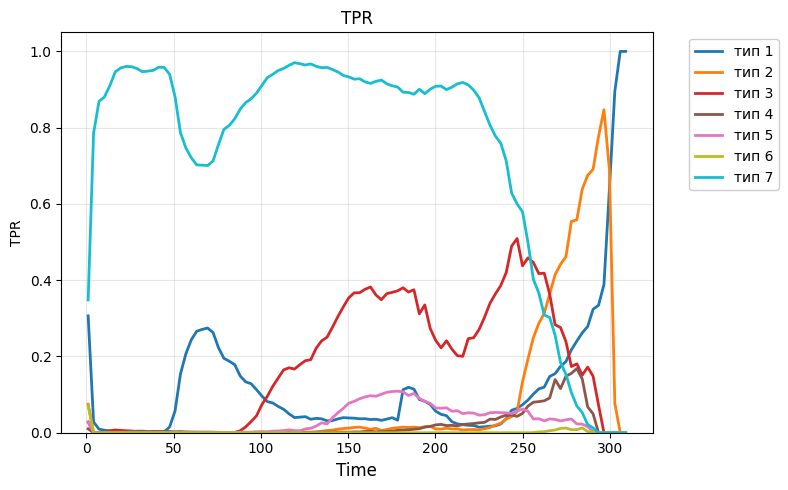

In [152]:
plot_tpr_curves(res_tpr, TIME_GRID)

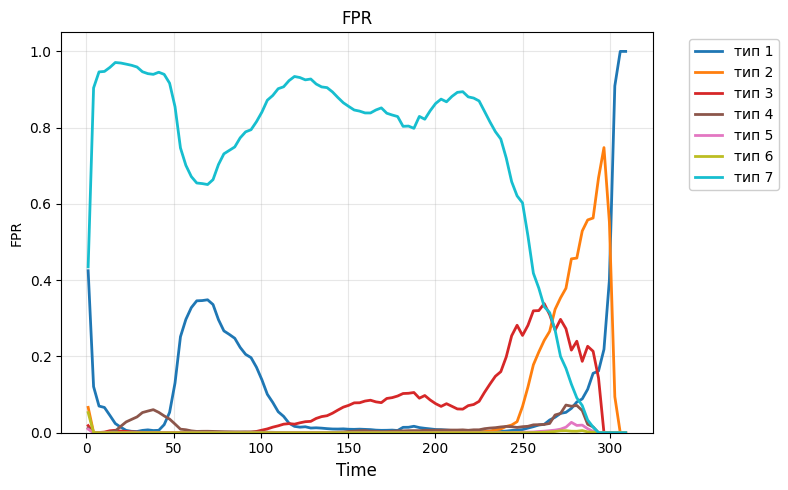

In [150]:
plot_fpr_curves(res_fpr, TIME_GRID)

In [154]:
y_test.event.value_counts()

event
0    7000
7    7000
6    7000
1    7000
3    7000
4    7000
5    7000
2    7000
Name: count, dtype: int64

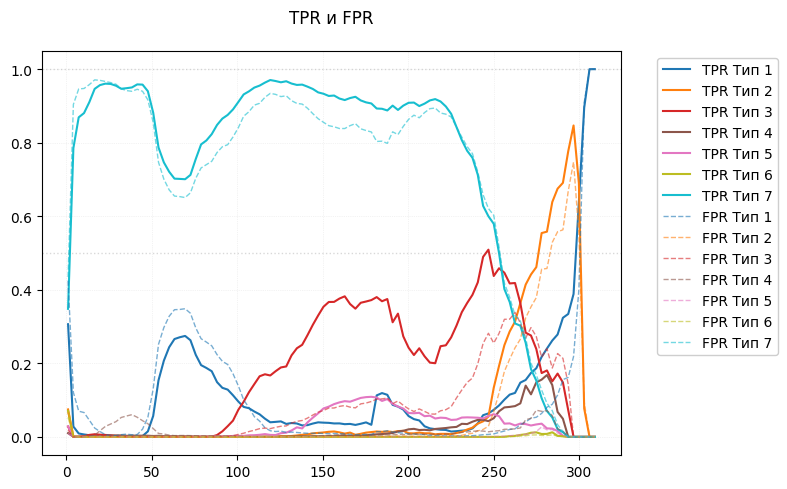

In [126]:
plot_tpr_fpr_combined(res_tpr, res_fpr, TIME_GRID)

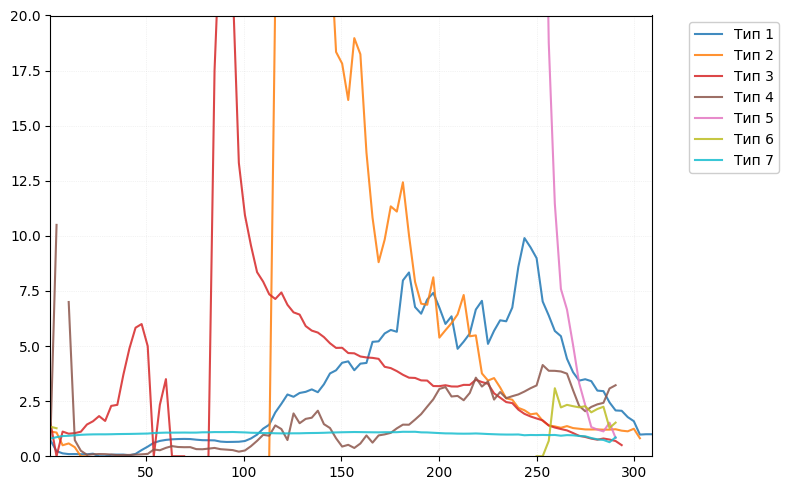

In [142]:
plot_tpr_fpr_ratio(res_tpr, res_fpr, TIME_GRID)

In [141]:
def plot_tpr_fpr_ratio(tpr, fpr, time_points, n_risks=7, 
                       max_ratio=20, figsize=(8, 5)):
    """
    График TPR/FPR с ограничением по оси Y и вынесенной легендой
    
    Parameters:
    -----------
    max_ratio : float
        Максимальное значение для оси Y (обрезает выбросы)
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    colors = plt.cm.tab10(np.linspace(0, 1, n_risks))
    
    for k in range(n_risks):
        # ratio = np.where(fpr[k, :] > 1e-6, tpr[k, :] / fpr[k, :], np.nan)
        
        # ratio_clipped = np.clip(ratio, None, max_ratio)
        
        ax.plot(time_points, tpr[k,:]/fpr[k,:], 
                linewidth=1.5, 
                color=colors[k],
                label=f'Тип {k+1}',
                alpha=0.85)
    
    
        
    # Легенда вне графика справа
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
              fontsize=10, framealpha=0.95, ncol=1)
    
    ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
    ax.set_ylim([0, 20])
    ax.set_xlim([time_points[0], time_points[-1]])
    
    plt.tight_layout()
    plt.show()


In [92]:
res_tpr[4]

array([0.02871429, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00014286, 0.00014286, 0.00014286, 0.00028571,
       0.00057143, 0.00057143, 0.00057143, 0.00114286, 0.00128571,
       0.00157143, 0.00257143, 0.003     , 0.00271429, 0.00428571,
       0.00457143, 0.00571429, 0.00757143, 0.00542857, 0.005     ,
       0.01      , 0.01157143, 0.01742857, 0.026     , 0.023     ,
       0.03942857, 0.05228571, 0.06414286, 0.07728571, 0.08228571,
       0.08914286, 0.09385714, 0.09714286, 0.09571429, 0.10085714,
       0.106     , 0.10814286, 0.109     , 0.107     , 0.09771429,
       0.10285714, 0.09      , 0.08257143, 0.077     , 0.06485714,
       0.06428571, 0.06542857, 0.05628571, 0.05771429, 0.05      ,
       0.05228571, 0.05142857, 0.04614286, 0.047     , 0.05257

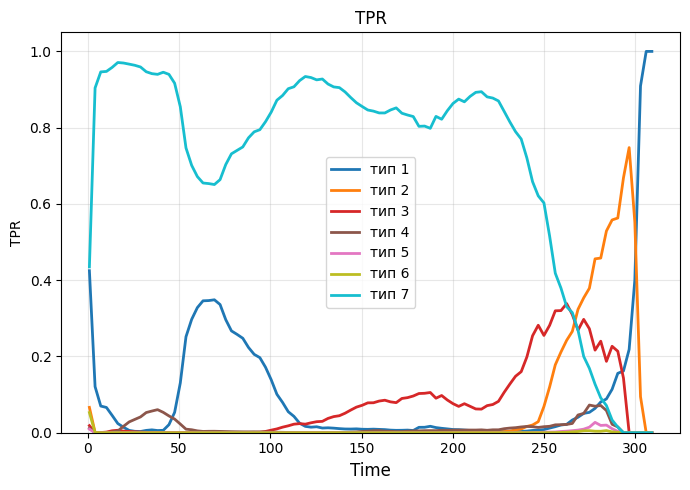

In [75]:
plot_tpr_curves(res_fpr, TIME_GRID)

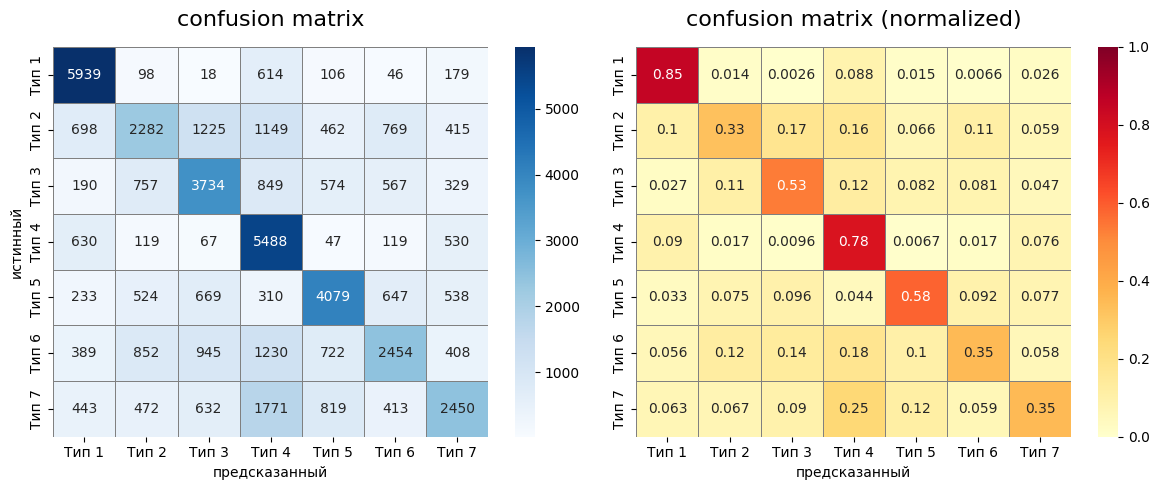

In [157]:
cm = np.array([[5939,   98,   18,  614,  106,   46,  179],
               [ 698, 2282, 1225, 1149,  462,  769,  415],
               [ 190,  757, 3734,  849,  574,  567,  329],
               [ 630,  119,   67, 5488,   47,  119,  530],
               [ 233,  524,  669,  310, 4079,  647,  538],
               [ 389,  852,  945, 1230,  722, 2454,  408],
               [ 443,  472,  632, 1771,  819,  413, 2450]])

labels = [f'Тип {i}' for i in range(1, 8)]

# Создаём DataFrame для исходной матрицы
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
cm_df.index.name = 'истинный'
cm_df.columns.name = 'предсказанный'

# Создаём нормализованную матрицу (по строкам)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_normalized_df = pd.DataFrame(cm_normalized, index=labels, columns=labels)
cm_normalized_df.columns.name = 'предсказанный'

# Создаём фигуру с двумя subplot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Heatmap 1: Исходные значения
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', 
            linewidths=0.5, linecolor='gray',
            ax=axes[0])
axes[0].set_title('confusion matrix', fontsize=16, pad=15)

# Heatmap 2: Нормализованные значения (Recall по каждому классу)
sns.heatmap(cm_normalized_df, annot=True, fmt='.2', cmap='YlOrRd',
            linewidths=0.5, linecolor='gray',
            vmin=0, vmax=1,
            ax=axes[1])
axes[1].set_title('confusion matrix (normalized)', fontsize=16, pad=15)

plt.tight_layout()
plt.show()

# Таблицы экспериментов 

функция для Таблицы сравнения разных стратегий OvR на классичеких моделях

In [14]:
def OvRTable(x_train, y_train, x_test, y_test, del_=False):
    if del_:
        x_train = x_train.drop(['x9', 'x10', 'x64', 'x72', 'x78'], axis=1) # константные столбы
        x_test = x_test.drop(['x9', 'x10', 'x64', 'x72', 'x78'], axis=1)
    
    early_threshold = 0.99
    col = [f'тип {i}' for i in [1, 2, 3, 9, 15, 16, 96]]
    ind = [f'OVR({i}) - {j}' for i in ['Cox', 'RSF', 'GBSA'] for j in ['single', 'all', 'early']]
    ovrs = [OvR(CoxPHFitter(penalizer=0.02), mode='single', early_threshold=early_threshold),
            OvR(CoxPHFitter(penalizer=0.02), mode='all', early_threshold=early_threshold),
            OvR(CoxPHFitter(penalizer=0.02), mode='early', early_threshold=early_threshold),

            OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='single', early_threshold=early_threshold),
            OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='all', early_threshold=early_threshold),
            OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='early', early_threshold=early_threshold),

            OvR(GradientBoostingSurvivalAnalysis(random_state=42), mode='single', early_threshold=early_threshold),
            OvR(GradientBoostingSurvivalAnalysis(random_state=42), mode='all', early_threshold=early_threshold),
            OvR(GradientBoostingSurvivalAnalysis(random_state=42), mode='early', early_threshold=early_threshold)]

    for elem in ovrs:
        elem.fit(x_train, y_train)

    preds = [model.predict(x_test) for model in ovrs]
    ovr_ibs = np.empty(shape=(7, len(preds)))

    for i in y_train.event.unique():
      if i:
        for j, cif in enumerate(preds):
            sf = cif[i-1, ...]    
            ovr_ibs[i-1][j] = ibs_remain(get_y_self_event(y_train, [i]),
                          get_y_self_event(y_test, [i]),
                          sf[y_test.event == i, :],
                          times=TIME_GRID, axis=-1)
    
    df = pd.DataFrame(ovr_ibs.T, columns=col, index=ind)
    tmp = pd.DataFrame(ovr_ibs.mean(axis=0), columns=['среднее'], index=ind)
    return df.join(tmp)


In [11]:
def OvRTable_aurpc(x_train, y_train, x_test, y_test, del_=False):
    if del_:
        x_train = x_train.drop(['x9', 'x10', 'x64', 'x72', 'x78'], axis=1) # константные столбы
        x_test = x_test.drop(['x9', 'x10', 'x64', 'x72', 'x78'], axis=1)
    
    early_threshold = 0.99
    col = [f'тип {i}' for i in [1, 2, 3, 9, 15, 16, 96]]
    ind = [f'OVR({i}) - {j}' for i in ['Cox', 'RSF', 'GBSA'] for j in ['single', 'all', 'early']]
    ovrs = [OvR(CoxPHFitter(penalizer=0.02), mode='single', early_threshold=early_threshold),
            OvR(CoxPHFitter(penalizer=0.02), mode='all', early_threshold=early_threshold),
            OvR(CoxPHFitter(penalizer=0.02), mode='early', early_threshold=early_threshold),

            OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='single', early_threshold=early_threshold),
            OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='all', early_threshold=early_threshold),
            OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='early', early_threshold=early_threshold)]

#             OvR(GradientBoostingSurvivalAnalysis(random_state=42), mode='single', early_threshold=early_threshold),
#             OvR(GradientBoostingSurvivalAnalysis(random_state=42), mode='all', early_threshold=early_threshold),
#             OvR(GradientBoostingSurvivalAnalysis(random_state=42), mode='early', early_threshold=early_threshold)]

    for elem in ovrs:
        elem.fit(x_train, y_train)

    preds = [model.predict(x_test) for model in ovrs]
    ovr_ibs = np.empty(shape=(7, len(preds)))

    for i in y_train.event.unique():
      if i:
        for j, cif in enumerate(preds):
            sf = cif[i-1, ...]    
            y_test_event_i = get_y_self_event(y_test, [i])
            
            risk_scores = -np.trapz(sf, x=TIME_GRID, axis=-1)
            times_for_auc = TIME_GRID[TIME_GRID < y_test_event_i['duration'].max()]

            _, mean_auc = cumulative_dynamic_auc(
                        y_train_event_i,
                        y_test_event_i,
                        risk_scores,
                        times=times_for_auc
                    )
            ovr_ibs[i-1][j] = mean_auc
    
    df = pd.DataFrame(ovr_ibs.T, columns=col, index=ind)
    tmp = pd.DataFrame(ovr_ibs.mean(axis=0), columns=['среднее'], index=ind)
    return df.join(tmp)

Функции подсчета Таблиц Meta_(w, b) для OVR классических моделей, и для моделей конкурирующих рисков

In [15]:
def Meta_b_Classic_Table(x_train, y_train, x_test, y_test, del_=False):
    if del_:
        x_train = x_train.drop(['x9', 'x10', 'x64', 'x72', 'x78'], axis=1) # константные столбы
        x_test = x_test.drop(['x9', 'x10', 'x64', 'x72', 'x78'], axis=1)
    early_threshold = 0.99

    col = [f'тип {i}' for i in [1, 2, 3, 9, 15, 16, 96]]
    ind = [f'Meta_b(OVR({i})) - {j}' for i in ['Cox', 'RSF'] for j in ['single', 'all', 'early']]
    ovrs = [OvR(CoxPHFitter(penalizer=0.02), mode='single', early_threshold=early_threshold),
            OvR(CoxPHFitter(penalizer=0.02), mode='all', early_threshold=early_threshold),
            OvR(CoxPHFitter(penalizer=0.02), mode='early', early_threshold=early_threshold),

            OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='single', early_threshold=early_threshold),
            OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='all', early_threshold=early_threshold),
            OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='early', early_threshold=early_threshold)]

#             OvR(GradientBoostingSurvivalAnalysis(random_state=42), mode='single', early_threshold=early_threshold),
#             OvR(GradientBoostingSurvivalAnalysis(random_state=42), mode='all', early_threshold=early_threshold),
#             OvR(GradientBoostingSurvivalAnalysis(random_state=42), mode='early', early_threshold=early_threshold)]

    metas_best = list(map(lambda x: MetaModel(x, mode='early'), ovrs))
    for m in metas_best: 
        print(f'fit {m}')
        m.fit(x_train, y_train)
    preds = [m.predict(x_test) for m in metas_best]
    meta_best_ibs = np.empty(shape=(7, len(preds)))
    print('ibs')
    for i in y_train.event.unique():
      if i:
        for j, sf in enumerate(preds):
            meta_best_ibs[i-1][j] = ibs_remain(get_y_self_event(y_train, [i]),
                              get_y_self_event(y_test, [i]),
                              sf[y_test.event == i, :],
                              times=TIME_GRID, axis=-1)
    
    df = pd.DataFrame(meta_best_ibs.T, columns=col, index=ind)

    meta_best_ibs_mean = np.empty(shape=(len(preds),))
    for j, sf in enumerate(preds):
        meta_best_ibs_mean[j] = np.mean(ibs_remain(
            get_y_self_event(y_train, dct.values()),
            get_y_self_event(y_test, dct.values()),
            sf[y_test.event.isin(dct.values()), :],
            times=TIME_GRID
        ))
    
    tmp = pd.DataFrame(meta_best_ibs_mean, columns=['среднее'], index=ind)
    
    return df.join(tmp)
    

In [ ]:
def Meta_b_Classic_Table_auprc(x_train, y_train, x_test, y_test, del_=False):
    if del_:
        x_train = x_train.drop(['x9', 'x10', 'x64', 'x72', 'x78'], axis=1) # константные столбы
        x_test = x_test.drop(['x9', 'x10', 'x64', 'x72', 'x78'], axis=1)
    early_threshold = 0.99

    col = [f'тип {i}' for i in [1, 2, 3, 9, 15, 16, 96]]
    ind = [f'Meta_b(OVR({i})) - {j}' for i in ['Cox', 'RSF'] for j in ['single', 'all', 'early']]
    ovrs = [OvR(CoxPHFitter(penalizer=0.02), mode='single', early_threshold=early_threshold),
            OvR(CoxPHFitter(penalizer=0.02), mode='all', early_threshold=early_threshold),
            OvR(CoxPHFitter(penalizer=0.02), mode='early', early_threshold=early_threshold),

            OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='single', early_threshold=early_threshold),
            OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='all', early_threshold=early_threshold),
            OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='early', early_threshold=early_threshold)]

#             OvR(GradientBoostingSurvivalAnalysis(random_state=42), mode='single', early_threshold=early_threshold),
#             OvR(GradientBoostingSurvivalAnalysis(random_state=42), mode='all', early_threshold=early_threshold),
#             OvR(GradientBoostingSurvivalAnalysis(random_state=42), mode='early', early_threshold=early_threshold)]

    metas_best = list(map(lambda x: MetaModel(x, mode='early'), ovrs))
    for m in metas_best: 
        print(f'fit {m}')
        m.fit(x_train, y_train)
    preds = [m.predict(x_test) for m in metas_best]
    meta_best_ibs = np.empty(shape=(7, len(preds)))
    print('ibs')
    
    for i in y_train.event.unique():
      if i:
        for j, cif in enumerate(preds):
            sf = cif[i-1, ...]    
            y_test_event_i = get_y_self_event(y_test, [i])
            y_train_event_i = get_y_self_event(y_train, [i])
            mean_auc = calculate_survival_auprc_vectorized(
                y_test_event_i, 
                sf[y_test.event == i, :],
                TIME_GRID)
            ovr_ibs[i-1][j] = mean_auc

    df = pd.DataFrame(ovr_ibs.T, columns=col, index=ind[:-3])
    tmp = pd.DataFrame(ovr_ibs.mean(axis=0), columns=['среднее'], index=ind[:-3])
    ovr_auprc = df.join(tmp)
    return ovr_auprc


In [16]:
def Meta_w_Classic_Table(x_train, y_train, x_test, y_test, del_=False):
    if del_:
        x_train = x_train.drop(['x9', 'x10', 'x64', 'x72', 'x78'], axis=1) # константные столбы
        x_test = x_test.drop(['x9', 'x10', 'x64', 'x72', 'x78'], axis=1)
    
    early_threshold = 0.99
    col = [f'тип {i}' for i in [1, 2, 3, 9, 15, 16, 96]]
    ind = [f'Meta_w(OVR({i})) - {j}' for i in ['Cox', 'RSF'] for j in ['single', 'all', 'early']]
    ovrs = [OvR(CoxPHFitter(penalizer=0.02), mode='single', early_threshold=early_threshold),
            OvR(CoxPHFitter(penalizer=0.02), mode='all', early_threshold=early_threshold),
            OvR(CoxPHFitter(penalizer=0.02), mode='early', early_threshold=early_threshold),

            OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='single', early_threshold=early_threshold),
            OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='all', early_threshold=early_threshold),
            OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='early', early_threshold=early_threshold)]

#             OvR(GradientBoostingSurvivalAnalysis(random_state=42), mode='single', early_threshold=early_threshold),
#             OvR(GradientBoostingSurvivalAnalysis(random_state=42), mode='all', early_threshold=early_threshold),
#             OvR(GradientBoostingSurvivalAnalysis(random_state=42), mode='early', early_threshold=early_threshold)]
    
    metas_w = list(map(lambda x: MetaModel(x, mode='weighted'), ovrs))
    for m in metas_w:
        print(f'fit {m}')
        m.fit(x_train, y_train)
    preds = [m.predict(x_test) for m in metas_w]
    meta_w_ibs = np.empty(shape=(7, len(preds)))
    print('ibs')
    for i in y_train.event.unique():
      if i:
        for j, sf in enumerate(preds):
            meta_w_ibs[i-1][j] = ibs_remain(get_y_self_event(y_train, [i]),
                              get_y_self_event(y_test, [i]),
                              sf[y_test.event == i, :],
                              times=TIME_GRID, axis=-1)
    
    df = pd.DataFrame(meta_w_ibs.T, columns=col, index=ind)

    meta_w_ibs_mean = np.empty(shape=(len(preds),))
    for j, sf in enumerate(preds):
        meta_w_ibs_mean[j] = np.mean(ibs_remain(
            get_y_self_event(y_train, dct.values()),
            get_y_self_event(y_test, dct.values()),
            sf[y_test.event.isin(dct.values()), :],
            times=TIME_GRID
        ))
    
    tmp = pd.DataFrame(meta_w_ibs_mean, columns=['среднее'], index=ind)
    
    return df.join(tmp)


In [17]:
def Meta_b_Compet_Table(x_train, y_train, x_val, y_val, x_test, y_test, del_=False):
    if del_:
        x_train = x_train.drop(['x9', 'x10', 'x64', 'x72', 'x78'], axis=1) # константные столбы
        x_test = x_test.drop(['x9', 'x10', 'x64', 'x72', 'x78'], axis=1)
        x_val = x_val.drop(['x9', 'x10', 'x64', 'x72', 'x78'], axis=1) 
    early_threshold = 0.99
    col = [f'тип {i}' for i in [1, 2, 3, 9, 15, 16, 96]]
    ind = [f'Meta_b({i})' for i in ['OVR(AJ) - single', 'OVR(AJ) - all', 'OVR(AJ) - early', 'SurvBoost', 'DeepHit']]
    models = [
        aj_self := OvR(AalenJohansenFitter(), mode='single', early_threshold=early_threshold),
        aj_all := OvR(AalenJohansenFitter(), mode='all', early_threshold=early_threshold),
        aj_early := OvR(AalenJohansenFitter(), mode='early', early_threshold=early_threshold),
        sb := SurvivalBoost(),
        dh := DeepHitWrapper()]

    x_vals = [None, None, None, None, x_val]
    y_vals = [None, None, None, None, y_val]

    metas_best = list(map(lambda x: MetaModel(x, mode='early'), models))

    for i in range(len(metas_best)): 
        metas_best[i].fit(x_train, y_train, x_vals[i], y_vals[i])
    preds = [m.predict(x_test) for m in metas_best]
    meta_best_ibs = np.empty(shape=(7, len(preds)))

    for i in y_train.event.unique():
      if i:
        for j, sf in enumerate(preds):
            meta_best_ibs[i-1][j] = ibs_remain(get_y_self_event(y_train, [i]),
                              get_y_self_event(y_test, [i]),
                              sf[y_test.event == i, :],
                              times=TIME_GRID, axis=-1)
    df = pd.DataFrame(meta_best_ibs.reshape((7, 5)).T, columns=col, index=ind)

    meta_best_ibs_mean = np.empty(shape=(len(preds),))
    for j, sf in enumerate(preds):
        meta_best_ibs_mean[j] = np.mean(ibs_remain(
            get_y_self_event(y_train, dct.values()),
            get_y_self_event(y_test, dct.values()),
            sf[y_test.event.isin(dct.values()), :],
            times=TIME_GRID
        ))
    tmp = pd.DataFrame(meta_best_ibs_mean, columns=['среднее'], index=ind)
    return df.join(tmp)

In [18]:
def Meta_w_Compet_Table(x_train, y_train, x_val, y_val, x_test, y_test, del_=False):
    if del_:
        x_train = x_train.drop(['x9', 'x10', 'x64', 'x72', 'x78'], axis=1) # константные столбы
        x_test = x_test.drop(['x9', 'x10', 'x64', 'x72', 'x78'], axis=1)
        x_val = x_val.drop(['x9', 'x10', 'x64', 'x72', 'x78'], axis=1) 
    early_threshold = 0.99
    col = [f'тип {i}' for i in [1, 2, 3, 9, 15, 16, 96]]
    ind = [f'Meta_w({i})' for i in ['OVR(AJ) - single', 'OVR(AJ) - all', 'OVR(AJ) - early', 'SurvBoost', 'DeepHit']]
    models = [
        aj_self := OvR(AalenJohansenFitter(), mode='single', early_threshold=early_threshold),
        aj_all := OvR(AalenJohansenFitter(), mode='all', early_threshold=early_threshold),
        aj_early := OvR(AalenJohansenFitter(), mode='early', early_threshold=early_threshold),
        sb := SurvivalBoost(),
        dh := DeepHitWrapper()]

    x_vals = [None, None, None, None, x_val]
    y_vals = [None, None, None, None, y_val]

    metas_best = list(map(lambda x: MetaModel(x, mode='weighted'), models))

    for i in range(len(metas_best)): 
        metas_best[i].fit(x_train, y_train, x_vals[i], y_vals[i])
    preds = [m.predict(x_test) for m in metas_best]
    meta_best_ibs = np.empty(shape=(7, len(preds)))

    for i in y_train.event.unique():
      if i:
        for j, sf in enumerate(preds):
            meta_best_ibs[i-1][j] = ibs_remain(get_y_self_event(y_train, [i]),
                              get_y_self_event(y_test, [i]),
                              sf[y_test.event == i, :],
                              times=TIME_GRID, axis=-1)
    df = pd.DataFrame(meta_best_ibs.reshape((7, 5)).T, columns=col, index=ind)

    meta_best_ibs_mean = np.empty(shape=(len(preds),))
    for j, sf in enumerate(preds):
        meta_best_ibs_mean[j] = np.mean(ibs_remain(
            get_y_self_event(y_train, dct.values()),
            get_y_self_event(y_test, dct.values()),
            sf[y_test.event.isin(dct.values()), :],
            times=TIME_GRID
        ))
    tmp = pd.DataFrame(meta_best_ibs_mean, columns=['среднее'], index=ind)
    return df.join(tmp)

In [ ]:
def OvR_Compet_Table(x_train, y_train, x_val, y_val, x_test, y_test, del_=False):
    if del_:
        x_train = x_train.drop(['x9', 'x10', 'x64', 'x72', 'x78'], axis=1) # константные столбы
        x_test = x_test.drop(['x9', 'x10', 'x64', 'x72', 'x78'], axis=1)
        x_val = x_val.drop(['x9', 'x10', 'x64', 'x72', 'x78'], axis=1) 
    early_threshold = 0.99
    col = [f'тип {i}' for i in [1, 2, 3, 9, 15, 16, 96]]
    ind = [f'OvR({i})' for i in ['AJ', 'SurvBoost', 'SurvBoostMod', 'DeepHit']]
    models = [
        aj_self := OvR(AalenJohansenFitter(), mode='single', early_threshold=early_threshold),
        sb := SurvivalBoost(),
        dh := DeepHitWrapper()]

    x_vals = [None, None, None, None, x_val]
    y_vals = [None, None, None, None, y_val]

    metas_best = list(map(lambda x: MetaModel(x, mode='early'), models))

    for i in range(len(metas_best)): 
        metas_best[i].fit(x_train, y_train, x_vals[i], y_vals[i])
    preds = [m.predict(x_test) for m in metas_best]
    meta_best_ibs = np.empty(shape=(7, len(preds)))

    for i in y_train.event.unique():
      if i:
        for j, sf in enumerate(preds):
            meta_best_ibs[i-1][j] = ibs_remain(get_y_self_event(y_train, [i]),
                              get_y_self_event(y_test, [i]),
                              sf[y_test.event == i, :],
                              times=TIME_GRID, axis=-1)
    df = pd.DataFrame(meta_best_ibs.reshape((7, 5)).T, columns=col, index=ind)

    meta_best_ibs_mean = np.empty(shape=(len(preds),))
    for j, sf in enumerate(preds):
        meta_best_ibs_mean[j] = np.mean(ibs_remain(
            get_y_self_event(y_train, dct.values()),
            get_y_self_event(y_test, dct.values()),
            sf[y_test.event.isin(dct.values()), :],
            times=TIME_GRID
        ))
    tmp = pd.DataFrame(meta_best_ibs_mean, columns=['среднее'], index=ind)
    return df.join(tmp)

#### (1)

In [123]:
ovrs = [
    
cox_self := OvR(CoxPHFitter(penalizer=0.02), mode='single', early_threshold=early_threshold),
cox_all := OvR(CoxPHFitter(penalizer=0.02), mode='all', early_threshold=early_threshold),
cox_early := OvR(CoxPHFitter(penalizer=0.02), mode='early', early_threshold=early_threshold),

rsf_self := OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='single', early_threshold=early_threshold),
rsf_all := OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='all', early_threshold=early_threshold),
rsf_early := OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='early', early_threshold=early_threshold),

gbsa_self := OvR(GradientBoostingSurvivalAnalysis(random_state=42), mode='single', early_threshold=early_threshold),
gbsa_all := OvR(GradientBoostingSurvivalAnalysis(random_state=42), mode='all', early_threshold=early_threshold),
gbsa_early := OvR(GradientBoostingSurvivalAnalysis(random_state=42), mode='early', early_threshold=early_threshold)]

for elem in ovrs:
    elem.fit(x_train, y_train)

preds = [model.predict(x_test) for model in ovrs]
ovr_ibs = np.empty(shape=(7, len(preds)))

for i in df.event.unique():
  if i:
    for j, cif in enumerate(preds):
        sf = cif[dct[i]-1, ...]    
        ovr_ibs[dct[i]-1][j] = ibs_remain(get_y_self_event(y_train, [dct[i]]),
                      get_y_self_event(y_test, [dct[i]]),
                      sf[y_test.event == dct[i], :],
                      times=TIME_GRID, axis=-1)
print(ovr_ibs.reshape((7, 3, 3))) # events, cox/rsf/gbsa, single/all/early
print(ovr_ibs.mean(axis=0).reshape((3, 3)))

[[[0.03076539 0.41071006 0.26579574]
  [0.0298109  0.30541536 0.12043265]
  [0.02987612 0.37908323 0.13276955]]

 [[0.11415735 0.41656307 0.33790487]
  [0.11276646 0.4019038  0.29390508]
  [0.11538437 0.43087904 0.31236665]]

 [[0.09735804 0.38788669 0.29161716]
  [0.09148753 0.3596427  0.21043722]
  [0.09370817 0.42166194 0.22833705]]

 [[0.08487961 0.33961101 0.20922462]
  [0.08557964 0.31638738 0.15863863]
  [0.0865092  0.35458147 0.15639498]]

 [[0.06219437 0.11563714 0.08529642]
  [0.05651986 0.11622185 0.08385407]
  [0.05618009 0.12628537 0.08710671]]

 [[0.03230686 0.0753835  0.03568859]
  [0.03194578 0.07170465 0.03507987]
  [0.03222112 0.07334102 0.03391928]]

 [[0.03117335 0.5290199  0.3342305 ]
  [0.02964021 0.48036557 0.15191572]
  [0.03058247 0.54026624 0.15794267]]]
[[0.06469071 0.32497305 0.22282256]
 [0.06253577 0.29309162 0.15060903]
 [0.0634945  0.33229976 0.15840527]]


In [208]:
ovrs = [
    
cox_self := OvR(CoxPHFitter(penalizer=0.02), mode='single', early_threshold=early_threshold),
cox_all := OvR(CoxPHFitter(penalizer=0.02), mode='all', early_threshold=early_threshold),
cox_early := OvR(CoxPHFitter(penalizer=0.02), mode='early', early_threshold=early_threshold),

rsf_self := OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='single', early_threshold=early_threshold),
rsf_all := OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='all', early_threshold=early_threshold),
rsf_early := OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='early', early_threshold=early_threshold),

gbsa_self := OvR(GradientBoostingSurvivalAnalysis(random_state=42), mode='single', early_threshold=early_threshold),
gbsa_all := OvR(GradientBoostingSurvivalAnalysis(random_state=42), mode='all', early_threshold=early_threshold),
gbsa_early := OvR(GradientBoostingSurvivalAnalysis(random_state=42), mode='early', early_threshold=early_threshold)]

metas_best = list(map(lambda x: MetaModel(x, mode='early'), ovrs))
metas_weight = list(map(lambda x: MetaModel(x, mode='weighted'), ovrs))
metas_mix = list(map(lambda x: MetaModel(x, mode='mix'), ovrs))
del ovrs
del preds

In [258]:
rsf_self = OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='single', early_threshold=early_threshold)
rsf_e = MetaModel(rsf_self, mode='early')
rsf_w = MetaModel(rsf_self, mode='weighted')
rsf_m = MetaModel(rsf_self, mode='mix')

rsf_m.fit(x_train, y_train)
sf_m = rsf_m.predict(x_test)

rsf_e.fit(x_train, y_train)
rsf_w.fit(x_train, y_train)
sf_e = rsf_e.predict(x_test)
sf_w = rsf_w.predict(x_test)

print('                   early           weighted            mix')
for i in df.event.unique():
  if i:
    ibs_1 = ibs_remain(get_y_self_event(y_train, [dct[i]]),
                      get_y_self_event(y_test, [dct[i]]),
                      sf_e[y_test.event == dct[i], :],
                      times=TIME_GRID, axis=-1)
    ibs_2 = ibs_remain(get_y_self_event(y_train, [dct[i]]),
                      get_y_self_event(y_test, [dct[i]]),
                      sf_w[y_test.event == dct[i], :],
                      times=TIME_GRID, axis=-1)
    ibs_3 = ibs_remain(get_y_self_event(y_train, [dct[i]]),
                      get_y_self_event(y_test, [dct[i]]),
                      sf_m[y_test.event == dct[i], :],
                      times=TIME_GRID, axis=-1)
    print(f"ibs {i:<2}:           {ibs_1:<4.4f}            {ibs_2:<4.4f}            {ibs_3:<4.4f}")

                   early           weighted            mix
ibs 1 :           0.0560            0.0607            0.0443
ibs 9 :           0.1091            0.0976            0.0976
ibs 96:           0.1181            0.0942            0.0708
ibs 16:           0.2989            0.2331            0.3205
ibs 3 :           0.1580            0.1165            0.1123
ibs 2 :           0.1886            0.1262            0.1408
ibs 15:           0.1260            0.1068            0.1332


In [263]:
# rsf_self = OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='mix', early_threshold=early_threshold)
# rsf_e = MetaModel(rsf_self, mode='early')
# rsf_w = MetaModel(rsf_self, mode='weighted')

# rsf_e.fit(x_train, y_train)
# rsf_w.fit(x_train, y_train)
# sf_e = rsf_e.predict(x_test)
# sf_w = rsf_w.predict(x_test)

print('                   early           weighted')
for i in df.event.unique():
  if i:
    ibs_1 = ibs_remain(get_y_self_event(y_train, [dct[i]]),
                      get_y_self_event(y_test, [dct[i]]),
                      sf_e[y_test.event == dct[i], :],
                      times=TIME_GRID, axis=-1)
    ibs_2 = ibs_remain(get_y_self_event(y_train, [dct[i]]),
                      get_y_self_event(y_test, [dct[i]]),
                      sf_w[y_test.event == dct[i], :],
                      times=TIME_GRID, axis=-1)
#     ibs_3 = ibs_remain(get_y_self_event(y_train, [dct[i]]),
#                       get_y_self_event(y_test, [dct[i]]),
#                       sf_m[y_test.event == dct[i], :],
#                       times=TIME_GRID, axis=-1)
    print(f"ibs {dct[i]:<2}:           {ibs_1:<4.4f}            {ibs_2:<4.4f}")

                   early           weighted
ibs 1 :           0.0570            0.0625
ibs 4 :           0.1096            0.0991
ibs 7 :           0.1214            0.0973
ibs 6 :           0.2964            0.2206
ibs 3 :           0.1661            0.1225
ibs 2 :           0.1948            0.1316
ibs 5 :           0.1342            0.1089


#### (2) MetaModel (best)

In [167]:
for m in metas_best: 
    m.fit(x_train, y_train)
preds = [m.predict(x_test) for m in metas_best]
meta_best_ibs = np.empty(shape=(7, len(preds)))

for i in df.event.unique():
  if i:
    for j, sf in enumerate(preds):
        meta_best_ibs[dct[i]-1][j] = ibs_remain(get_y_self_event(y_train, [dct[i]]),
                          get_y_self_event(y_test, [dct[i]]),
                          sf[y_test.event == dct[i], :],
                          times=TIME_GRID, axis=-1)
print(meta_best_ibs.reshape((7, 3, 3))) # events, cox/rsf/gbsa, single/all/early

meta_best_ibs_mean = np.empty(shape=(len(preds),))
for j, sf in enumerate(preds):
    meta_best_ibs_mean[j] = np.mean(ibs_remain(
        get_y_self_event(y_train, dct.values()),
        get_y_self_event(y_test, dct.values()),
        sf[y_test.event.isin(dct.values()), :],
        times=TIME_GRID
    ))
print(meta_best_ibs_mean.reshape((3, 3)))

[[[0.05658582 0.3904014  0.24691521]
  [0.05597155 0.25690559 0.12382561]
  [0.05492219 0.33879101 0.1434315 ]]

 [[0.18993858 0.39784677 0.30621581]
  [0.18863366 0.35281851 0.23347034]
  [0.19009627 0.40533996 0.25348888]]

 [[0.16143893 0.37059844 0.28658516]
  [0.15804866 0.3153914  0.2116472 ]
  [0.15913117 0.38774349 0.2389842 ]]

 [[0.10857534 0.35383668 0.22788975]
  [0.10910501 0.30860634 0.15308778]
  [0.10988342 0.37239174 0.16558378]]

 [[0.12687961 0.12085011 0.10159425]
  [0.12601931 0.11345955 0.09134881]
  [0.12558722 0.12071996 0.09030538]]

 [[0.29443028 0.12738997 0.12199919]
  [0.29887173 0.1201375  0.13611382]
  [0.30278179 0.12219488 0.1271711 ]]

 [[0.12186056 0.4880527  0.33406173]
  [0.11807134 0.40139898 0.22051447]
  [0.11820498 0.49727974 0.24476198]]]
[[0.19673791 0.29121838 0.22621491]
 [0.19797297 0.24541413 0.18672113]
 [0.1989382  0.2904674  0.1973834 ]]


#### (2) MetaModel(weighted)

In [180]:
for m in metas_weight: 
    m.fit(x_train, y_train)
preds = [m.predict(x_test) for m in metas_weight]
meta_weighted_ibs = np.empty(shape=(7, len(preds)))

for i in df.event.unique():
  if i:
    for j, sf in enumerate(preds):
        meta_weighted_ibs[dct[i]-1][j] = ibs_remain(get_y_self_event(y_train, [dct[i]]),
                          get_y_self_event(y_test, [dct[i]]),
                          sf[y_test.event == dct[i], :],
                          times=TIME_GRID, axis=-1)
print(meta_weighted_ibs.reshape((7, 3, 3))) # events, cox/rsf/gbsa, single/all/early

meta_weighted_ibs_mean = np.empty(shape=(len(preds),))
for j, sf in enumerate(preds):
    meta_weighted_ibs_mean[j] = np.mean(ibs_remain(
        get_y_self_event(y_train, dct.values()),
        get_y_self_event(y_test, dct.values()),
        sf[y_test.event.isin(dct.values()), :],
        times=TIME_GRID
    ))
print(meta_weighted_ibs_mean.reshape((3, 3)))

[[[0.06049571 0.44600102 0.29436846]
  [0.06070544 0.34085374 0.17459107]
  [0.05773821 0.39146469 0.18245918]]

 [[0.12738633 0.42962895 0.32269651]
  [0.12616696 0.41054386 0.22659611]
  [0.12559428 0.44208365 0.23634392]]

 [[0.11970467 0.41358431 0.31968835]
  [0.11652408 0.38365018 0.22410416]
  [0.1167978  0.43033562 0.23770996]]

 [[0.09719814 0.4174156  0.28037859]
  [0.09762188 0.40369937 0.19590078]
  [0.0964775  0.44324155 0.1998732 ]]

 [[0.10597493 0.14084579 0.10794986]
  [0.10680696 0.13934677 0.07973   ]
  [0.10665301 0.14076342 0.07758769]]

 [[0.22688947 0.12514568 0.09248226]
  [0.23309059 0.12264422 0.08377802]
  [0.23608801 0.12568693 0.08163245]]

 [[0.0976295  0.53598851 0.37950832]
  [0.09416812 0.493476   0.27257298]
  [0.09146135 0.56124606 0.28645252]]]
[[0.15756879 0.32070378 0.23859944]
 [0.1597137  0.29449093 0.18754097]
 [0.15926382 0.3240453  0.1932494 ]]


#### (3) MetaModel (mix)

In [209]:
for m in metas_mix: 
    m.fit(x_train, y_train)
preds = [m.predict(x_test) for m in metas_mix]
# for m in metas_mix:
    
#     print(m.ovr.estimator, ' ', m.ovr.mode)
#     t = m.predict(x_test)
#     preds.append(t)
meta_mix_ibs = np.empty(shape=(7, len(preds)))

for i in df.event.unique():
  if i:
    for j, sf in enumerate(preds):
        meta_mix_ibs[dct[i]-1][j] = ibs_remain(get_y_self_event(y_train, [dct[i]]),
                          get_y_self_event(y_test, [dct[i]]),
                          sf[y_test.event == dct[i], :],
                          times=TIME_GRID, axis=-1)
print(meta_mix_ibs.reshape((7, 3, 3))) # events, cox/rsf/gbsa, single/all/early

meta_mix_ibs_mean = np.empty(shape=(len(preds),))
for j, sf in enumerate(preds):
    meta_mix_ibs_mean[j] = np.mean(ibs_remain(
        get_y_self_event(y_train, dct.values()),
        get_y_self_event(y_test, dct.values()),
        sf[y_test.event.isin(dct.values()), :],
        times=TIME_GRID
    ))
print(meta_mix_ibs_mean.reshape((3, 3)))

[[[0.04598445 0.40836794 0.25633031]
  [0.04561953 0.27572229 0.12237766]
  [0.04462432 0.35485048 0.13743836]]

 [[0.14742292 0.43286224 0.32156803]
  [0.14703264 0.39823905 0.21903748]
  [0.14701935 0.44026271 0.22952218]]

 [[0.11907363 0.38700431 0.28804092]
  [0.11422122 0.33732089 0.19402985]
  [0.11607409 0.40704393 0.21781926]]

 [[0.10166983 0.39053379 0.24470372]
  [0.10211818 0.34362431 0.15505067]
  [0.10278548 0.40743579 0.16463474]]

 [[0.13139106 0.15019585 0.12064474]
  [0.13279293 0.14642523 0.09217501]
  [0.13226868 0.14842533 0.08796963]]

 [[0.31055127 0.15341433 0.13378394]
  [0.31725524 0.14970241 0.14064822]
  [0.31988552 0.15188128 0.13495414]]

 [[0.07995956 0.50781837 0.33635291]
  [0.07643467 0.42475716 0.206297  ]
  [0.07605883 0.51999761 0.22642352]]]
[[0.18390448 0.31411111 0.23414101]
 [0.18604868 0.27103122 0.18338867]
 [0.18664715 0.31362594 0.19144866]]


#### (4) Meta_b, meta_w для OVR(AJ), SurvivalBoost, Deephit

##### Обертка для DeepHit

In [10]:
from pycox.models import DeepHit

class DeepHitWrapper:

    class LabTransform(LabTransDiscreteTime):
        def transform(self, durations, events):
            durations, is_event = super().transform(durations, events > 0)
            events[is_event == 0] = 0
            return durations, events.astype('int64')


    class CauseSpecificNet(torch.nn.Module):
        """Network structure similar to the DeepHit paper, but without the residual
        connections (for simplicity).
        """
        def __init__(self, in_features, num_nodes_shared, num_nodes_indiv, num_risks,
                     out_features, batch_norm=True, dropout=None):
            super().__init__()
            self.shared_net = tt.practical.MLPVanilla(
                in_features, num_nodes_shared[:-1], num_nodes_shared[-1],
                batch_norm, dropout,
            )
            self.risk_nets = torch.nn.ModuleList()
            for _ in range(num_risks):
                net = tt.practical.MLPVanilla(
                    num_nodes_shared[-1], num_nodes_indiv, out_features,
                    batch_norm, dropout,
                )
                self.risk_nets.append(net)

        def forward(self, input):
            out = self.shared_net(input)
            out = [net(out) for net in self.risk_nets]
            out = torch.stack(out, dim=1)
            return out
    
    @staticmethod
    def _get_x(df):
        return df.values.astype('float32')

    @staticmethod
    def _get_target(df):
        return df['duration'].values, df['event'].values


    def __init__(self):
        self.labtrans = DeepHitWrapper.LabTransform(100)
        self.best_params_ = {'sigma': 0.3, 'num_nodes_shared': [64, 64],
                            'num_nodes_indiv': [32], 'lr': 0.001, 'dropout': 0.3, 
                            'decoupled_weight_decay': 0.01, 'batch_size': 512,
                            'batch_norm': False, 'alpha': 0.2}
        self.model=None
        self.events = None
        self.TIME_GRID=None

    def fit(self, x_train, y_train, x_val, y_val):
        self.events = y_train.event.unique()
        self.TIME_GRID = np.linspace(y_train['duration'].min(), y_train['duration'].max(), 100)
        
        y_train_dh = self.labtrans.fit_transform(*self._get_target(y_train.sort_values(by='duration')))
        y_val_dh = self.labtrans.transform(*self._get_target(y_val))
        x_train_dh = self._get_x(x_train)
        x_val_dh = self._get_x(x_val)

        val = (x_val_dh, y_val_dh)
        train = (x_train_dh, y_train_dh)
        
        in_features = x_train_dh.shape[1]
        num_nodes_shared = self.best_params_['num_nodes_shared']
        num_nodes_indiv = self.best_params_['num_nodes_indiv']
        num_risks = y_train_dh[1].max()
        out_features = len(self.labtrans.cuts)
        batch_norm = self.best_params_['batch_norm']
        dropout = self.best_params_['dropout']


        net = DeepHitWrapper.CauseSpecificNet(in_features, num_nodes_shared, num_nodes_indiv, num_risks,
                               out_features, batch_norm, dropout)


        optimizer = tt.optim.AdamWR(lr=self.best_params_['lr'],
                                    decoupled_weight_decay=self.best_params_['decoupled_weight_decay'],
                                    cycle_eta_multiplier=0.8)

        self.model = DeepHit(net, optimizer, 
                        alpha=self.best_params_['alpha'], 
                        sigma=self.best_params_['sigma'], 
                        duration_index=self.labtrans.cuts)

        epochs = 512
        batch_size = self.best_params_['batch_size']
        callbacks = [tt.callbacks.EarlyStoppingCycle()]
        verbose = False

        log = self.model.fit(x_train_dh, y_train_dh, batch_size, epochs, callbacks, verbose, val_data=val)
        
        
        
       # cif_dh = model.predict_cif(x_test_dh)
    
    def transform_timegrid(self, curves, time, grid):
        if time.max() < grid.max():
            time = np.hstack([time, np.array([grid.max()+1])])
            if len(curves.shape)==1:
                curves = np.hstack([curves, np.array([0])])
            elif len(curves.shape)==2:
                curves = np.hstack([curves, np.zeros(shape=(curves.shape[0], 1))])
        ind = np.searchsorted(time, grid)
        if len(curves.shape)==1:
            return curves[ind]
        elif len(curves.shape)==2:
            return curves[:, ind]
        else:
            return None
       

    def predict(self, x_test):
        self.events = self.events[self.events > 0]
        x_test_dh = self._get_x(x_test)
        cif = np.moveaxis((1 - self.model.predict_cif(x_test_dh)), (0, 1, 2), (0, 2, 1))
        new = np.zeros(shape=(self.events.shape[0], x_test.shape[0], 100))
        for i in self.events:
            new[i-1] = self.transform_timegrid(cif[i-1], self.model.duration_index, self.TIME_GRID)
        return new


In [ ]:
model = MetaModel(DeepHitWrapper(), mode='early')
model.fit(x_train, y_train, x_val, y_val)
model.predict(x_test)
del model

In [94]:
early_threshold = 0.99
models = [
aj_self := OvR(AalenJohansenFitter(), mode='single', early_threshold=early_threshold),
aj_all := OvR(AalenJohansenFitter(), mode='all', early_threshold=early_threshold),
aj_early := OvR(AalenJohansenFitter(), mode='early', early_threshold=early_threshold),
sb := SurvivalBoost(),
dh := DeepHitWrapper()]

x_vals = [None, None, None, None, x_val]
y_vals = [None, None, None, None, y_val]

metas_best = list(map(lambda x: MetaModel(x, mode='early'), models))
metas_weight = list(map(lambda x: MetaModel(x, mode='weighted'), models))


for i in range(len(metas_best)): 
    metas_best[i].fit(x_train, y_train, x_vals[i], y_vals[i])
preds = [m.predict(x_test) for m in metas_best]
meta_best_ibs = np.empty(shape=(7, len(preds)))

for i in df.event.unique():
  if i:
    for j, sf in enumerate(preds):
        meta_best_ibs[dct[i]-1][j] = ibs_remain(get_y_self_event(y_train, [dct[i]]),
                          get_y_self_event(y_test, [dct[i]]),
                          sf[y_test.event == dct[i], :],
                          times=TIME_GRID, axis=-1)
print(meta_best_ibs.reshape((7, 5)).T) # events, cox/rsf/gbsa, single/all/early

meta_best_ibs_mean = np.empty(shape=(len(preds),))
for j, sf in enumerate(preds):
    meta_best_ibs_mean[j] = np.mean(ibs_remain(
        get_y_self_event(y_train, dct.values()),
        get_y_self_event(y_test, dct.values()),
        sf[y_test.event.isin(dct.values()), :],
        times=TIME_GRID
    ))
print(meta_best_ibs_mean)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.12it/s]


[[0.05806034 0.68185257 0.30045476 0.50855026 0.72932108]
 [0.1917008  0.47400756 0.28941288 0.3503293  0.54442112]
 [0.17372769 0.48636295 0.29625016 0.36737636 0.56111108]
 [0.11735262 0.53726221 0.27913638 0.29323492 0.59961529]
 [0.12651445 0.22039673 0.12721696 0.69814713 0.30568236]
 [0.29991509 0.13384358 0.09718678 0.63906276 0.17675639]
 [0.11824182 0.66848126 0.33997867 0.21787349 0.73365816]]
[0.20417325 0.40707292 0.24906301 0.47056438 0.46237631]


In [95]:
print(meta_best_ibs.reshape((7, 5)).T)

[[0.05806034 0.1917008  0.17372769 0.11735262 0.12651445 0.29991509
  0.11824182]
 [0.68185257 0.47400756 0.48636295 0.53726221 0.22039673 0.13384358
  0.66848126]
 [0.30045476 0.28941288 0.29625016 0.27913638 0.12721696 0.09718678
  0.33997867]
 [0.50855026 0.3503293  0.36737636 0.29323492 0.69814713 0.63906276
  0.21787349]
 [0.72932108 0.54442112 0.56111108 0.59961529 0.30568236 0.17675639
  0.73365816]]


In [93]:
# for i in range(len(metas_weight)): 
#     metas_weight[i].fit(x_train, y_train, x_vals[i], y_vals[i])
# preds = [m.predict(x_test) for m in metas_weight]
# metas_weight_ibs = np.empty(shape=(7, len(preds)))

for i in df.event.unique():
  if i:
    for j, sf in enumerate(preds):
        metas_weight_ibs[dct[i]-1][j] = ibs_remain(get_y_self_event(y_train, [dct[i]]),
                          get_y_self_event(y_test, [dct[i]]),
                          sf[y_test.event == dct[i], :],
                          times=TIME_GRID, axis=-1)
print(metas_weight_ibs.reshape((7, 5))) # events, cox/rsf/gbsa, single/all/early

metas_weight_ibs_mean = np.empty(shape=(len(preds),))
for j, sf in enumerate(preds):
    metas_weight_ibs_mean[j] = np.mean(ibs_remain(
        get_y_self_event(y_train, dct.values()),
        get_y_self_event(y_test, dct.values()),
        sf[y_test.event.isin(dct.values()), :],
        times=TIME_GRID
    ))
print(metas_weight_ibs_mean)

[[0.0620742  0.68100241 0.31870534 0.35331232 0.7421059 ]
 [0.12873768 0.47180392 0.25086034 0.31773338 0.5457556 ]
 [0.12688422 0.48725835 0.26550981 0.31404652 0.5638254 ]
 [0.10143533 0.54183125 0.26680452 0.24440051 0.61036161]
 [0.11080485 0.22710393 0.10533777 0.643656   0.30615304]
 [0.23854308 0.1328219  0.07148985 0.66869959 0.17564991]
 [0.09672963 0.66827475 0.35099747 0.14090655 0.74111965]]
[0.16580731 0.40768737 0.23143753 0.43117654 0.46655638]


### Таблица экспериментов 1


#### (1) OvR без MetaModel

In [21]:
early_threshold=0.99
warnings.filterwarnings('ignore')

ovr_cox = OvR(CoxPHFitter(penalizer=0.02), mode='single', early_threshold=early_threshold)
ovr_rsf = OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='single', early_threshold=early_threshold)
ovr_gbsa = OvR(GradientBoostingSurvivalAnalysis(random_state=42), mode='single', early_threshold=early_threshold)

ovr_cox.fit(x_train, y_train)
ovr_rsf.fit(x_train, y_train)
ovr_gbsa.fit(x_train, y_train)

sf_cox = ovr_cox.predict(x_test)
sf_rsf = ovr_rsf.predict(x_test)
sf_gbsa = ovr_gbsa.predict(x_test)

massiv_1 = np.empty(shape=(7, 3))
massiv_1_cens = np.empty(shape=(7, 3))

# ibs для кажждого события

for i in df.event.unique():
  if i:
    cox = sf_cox[dct[i]-1, ...]
    rsf = sf_rsf[dct[i]-1, ...]
    gbsa = sf_gbsa[dct[i]-1, ...]
    tmp = np.empty(shape=(3,))
    
    # на себе
    
    tmp[0] = ibs_remain(get_y_self_event(y_train, [dct[i]]),
                      get_y_self_event(y_test, [dct[i]]),
                      cox[y_test.event == dct[i], :],
                      times=TIME_GRID, axis=-1)
    tmp[1] = ibs_remain(get_y_self_event(y_train, [dct[i]]),
                      get_y_self_event(y_test, [dct[i]]),
                      rsf[y_test.event == dct[i], :],
                      times=TIME_GRID, axis=-1)
    tmp[2] = ibs_remain(get_y_self_event(y_train, [dct[i]]),
                      get_y_self_event(y_test, [dct[i]]),
                      gbsa[y_test.event == dct[i], :],
                      times=TIME_GRID, axis=-1)
    massiv_1[dct[i]-1] = tmp
    
# среднее ibs

massiv_1_mean = massiv_1.mean(axis=0)

#### MetaModel с отбором наиболее вероятного

In [27]:
early_threshold=0.99
warnings.filterwarnings('ignore')

meta_cox = MetaModel(ovr_cox, mode='early')
meta_rsf = MetaModel(ovr_rsf, mode='early')
meta_gbsa = MetaModel(ovr_gbsa, mode='early')

meta_cox.fit(x_train, y_train)
meta_rsf.fit(x_train, y_train)
meta_gbsa.fit(x_train, y_train)

sf_cox = meta_cox.predict(x_test)
sf_rsf = meta_rsf.predict(x_test)
sf_gbsa = meta_gbsa.predict(x_test)

massiv_2 = np.empty(shape=(7, 3))

# ibs для кажждого события

for i in df.event.unique():
  if i:
    tmp = np.empty(shape=(3,))
    
    tmp[0] = ibs_remain(get_y_self_event(y_train, [dct[i]]),
                      get_y_self_event(y_test, [dct[i]]),
                      sf_cox[y_test.event == dct[i], :],
                      times=TIME_GRID, axis=-1)
    tmp[1] = ibs_remain(get_y_self_event(y_train, [dct[i]]),
                      get_y_self_event(y_test, [dct[i]]),
                      sf_rsf[y_test.event == dct[i], :],
                      times=TIME_GRID, axis=-1)
    tmp[2] = ibs_remain(get_y_self_event(y_train, [dct[i]]),
                      get_y_self_event(y_test, [dct[i]]),
                      sf_gbsa[y_test.event == dct[i], :],
                      times=TIME_GRID, axis=-1)
    massiv_2[dct[i]-1] = tmp

# среднее ibs

massiv_2_mean = np.empty(shape=(3,))

massiv_2_mean[0] = np.mean(ibs_remain(
        get_y_self_event(y_train, dct.values()),
        get_y_self_event(y_test, dct.values()),
        sf_cox[y_test.event.isin(dct.values()), :],
        times=TIME_GRID
    ))
massiv_2_mean[1] = np.mean(ibs_remain(
        get_y_self_event(y_train, dct.values()),
        get_y_self_event(y_test, dct.values()),
        sf_rsf[y_test.event.isin(dct.values()), :],
        times=TIME_GRID
    ))
massiv_2_mean[2] = np.mean(ibs_remain(
        get_y_self_event(y_train, dct.values()),
        get_y_self_event(y_test, dct.values()),
        sf_gbsa[y_test.event.isin(dct.values()), :],
        times=TIME_GRID
    ))

In [45]:
early_threshold=0.99
warnings.filterwarnings('ignore')

ovr_cox = OvR(CoxPHFitter(penalizer=0.02), mode='early', early_threshold=early_threshold)
ovr_rsf = OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='early', early_threshold=early_threshold)
ovr_gbsa = OvR(GradientBoostingSurvivalAnalysis(random_state=42), mode='early', early_threshold=early_threshold)

meta_cox = MetaModel(ovr_cox, mode='weighted')
meta_rsf = MetaModel(ovr_rsf, mode='weighted')
meta_gbsa = MetaModel(ovr_gbsa, mode='weighted')

meta_cox.fit(x_train, y_train)
meta_rsf.fit(x_train, y_train)
meta_gbsa.fit(x_train, y_train)

sf_cox = meta_cox.predict(x_test)
sf_rsf = meta_rsf.predict(x_test)
sf_gbsa = meta_gbsa.predict(x_test)

massiv_3 = np.empty(shape=(7, 3))

# ibs для кажждого события

for i in df.event.unique():
  if i:
    tmp = np.empty(shape=(3,))
    tmp[0] = ibs_remain(get_y_self_event(y_train, [dct[i]]),
                      get_y_self_event(y_test, [dct[i]]),
                      sf_cox[y_test.event == dct[i], :],
                      times=TIME_GRID, axis=-1)
    tmp[1] = ibs_remain(get_y_self_event(y_train, [dct[i]]),
                      get_y_self_event(y_test, [dct[i]]),
                      sf_rsf[y_test.event == dct[i], :],
                      times=TIME_GRID, axis=-1)
    tmp[2] = ibs_remain(get_y_self_event(y_train, [dct[i]]),
                      get_y_self_event(y_test, [dct[i]]),
                      sf_gbsa[y_test.event == dct[i], :],
                      times=TIME_GRID, axis=-1)
    massiv_3[dct[i]-1] = tmp

# среднее ibs

massiv_3_mean = np.empty(shape=(3,))

massiv_3_mean[0] = np.mean(ibs_remain(
        get_y_self_event(y_train, dct.values()),
        get_y_self_event(y_test, dct.values()),
        sf_cox[y_test.event.isin(dct.values()), :],
        times=TIME_GRID
    ))
massiv_3_mean[1] = np.mean(ibs_remain(
        get_y_self_event(y_train, dct.values()),
        get_y_self_event(y_test, dct.values()),
        sf_rsf[y_test.event.isin(dct.values()), :],
        times=TIME_GRID
    ))
massiv_3_mean[2] = np.mean(ibs_remain(
        get_y_self_event(y_train, dct.values()),
        get_y_self_event(y_test, dct.values()),
        sf_gbsa[y_test.event.isin(dct.values()), :],
        times=TIME_GRID
    ))

In [46]:
massiv_3

array([[0.29436846, 0.17459107, 0.18245918],
       [0.32269651, 0.22659611, 0.23634392],
       [0.31968835, 0.22410416, 0.23770996],
       [0.28037859, 0.19590078, 0.1998732 ],
       [0.10794986, 0.07973   , 0.07758769],
       [0.09248226, 0.08377802, 0.08163245],
       [0.37950832, 0.27257298, 0.28645252]])

In [40]:
massiv_3_mean

array([0.23859944, 0.18754097, 0.1932494 ])

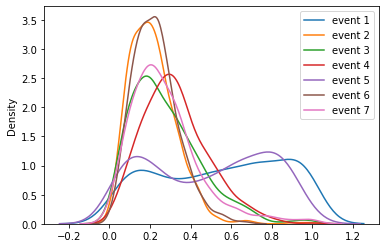

In [88]:
probs = meta_rsf.meta_model.predict_proba(x_test).T
for i in range(7):
    sns.kdeplot(data=probs[i, y_test.event==(i+1)], label=f'event {i+1}')
plt.legend()

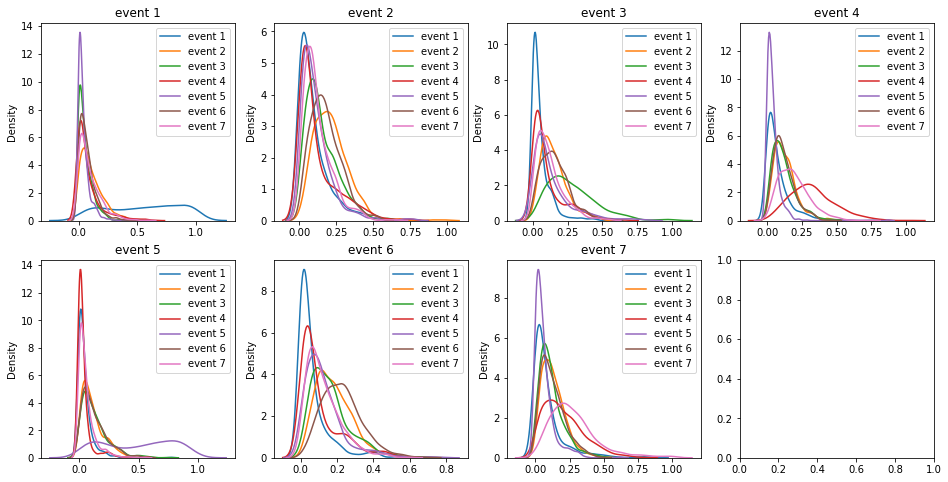

In [97]:
_, ax = plt.subplots(2, 4, figsize=(16, 8))
for i in range(7):
    x, y = i % 4, i // 4
    ax[y][x].set_title(f'event {i+1}')
    for j in range(7):
        sns.kdeplot(data=probs[j, y_test.event==(i+1)], ax=ax[y][x], label=f'event {j+1}')
    ax[y][x].legend()

In [105]:
ovr_1 = OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='single', early_threshold=early_threshold)
ovr_2 = OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='single', early_threshold=early_threshold)

meta_1 = MetaModel(ovr_1, mode='early')
meta_2 = MetaModel(ovr_2, mode='weighted')

meta_1.fit(x_train, y_train)
meta_2.fit(x_train, y_train)
sf1 = meta_1.predict(x_test)
sf2 = meta_2.predict(x_test)

print('                   early           weighted')
for i in df.event.unique():
  if i:
    ibs_1 = ibs_remain(get_y_self_event(y_train, [dct[i]]),
                      get_y_self_event(y_test, [dct[i]]),
                      sf1[y_test.event == dct[i], :],
                      times=TIME_GRID, axis=-1)
    ibs_2 = ibs_remain(get_y_self_event(y_train, [dct[i]]),
                      get_y_self_event(y_test, [dct[i]]),
                      sf2[y_test.event == dct[i], :],
                      times=TIME_GRID, axis=-1)
    print(f"ibs {i:<2}:           {ibs_1:<4.4f}            {ibs_2:<4.4f}")

                   early           weighted
ibs 1 :           0.0560            0.0607
ibs 9 :           0.1091            0.0976
ibs 96:           0.1181            0.0942
ibs 16:           0.2989            0.2331
ibs 3 :           0.1580            0.1165
ibs 2 :           0.1886            0.1262
ibs 15:           0.1260            0.1068


# Эксперименты с дисбалансом классов

[-1.  1.  2.  3.  9. 15. 16. 96.]


<Axes: xlabel='duration', ylabel='Density'>

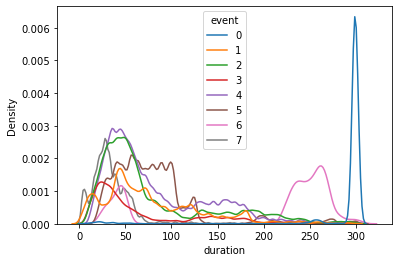

In [192]:
y_rand = pd.DataFrame(y_rand)
y_rand, _ = transform_events(y_rand)
sns.kdeplot(data=y_rand, x="duration", hue="event", bw_adjust=0.25, palette="tab10")


x_train_rand, x_test_rand, y_train_rand, y_test_rand = train_test_split(x_rand, y_rand, test_size=0.2, stratify=y_rand.event, random_state = 1)
x_train_rand, x_val_rand, y_train_rand, y_val_rand = train_test_split(x_train_rand, y_train_rand, test_size=0.25, stratify=y_train_rand.event, random_state = 1)



### Обучение на сбалансированном, метрики на дисбалансе

Пересчет базовых моделей (AJ, SurvBoost, DeepHit):

In [301]:
results_bal2rand = [AalenJohansenModel(y_bal, y_rand),
                    SurvivalBoostModel(x_bal, y_bal, x_rand, y_rand),
                    DeepHitModel(x_train, y_train, x_val, y_val, x_rand, y_rand)]

In [305]:
df = pd.DataFrame(index=['AalenJohansen', 'SurvBoost', 'SurvBoostModified', 'DeepHit'], columns = [f'тип {i}' for i in [1, 2, 3, 9, 15, 16, 96]])
df.loc['AalenJohansen'] = results_bal2rand[0]
df.loc['SurvBoost'] = results_bal2rand[1][0]
df.loc['SurvBoostModified'] = results_bal2rand[1][1]
df.loc['DeepHit'] = results_bal2rand[2]
df

,тип 1,тип 2,тип 3,тип 9,тип 15,тип 16,тип 96
AalenJohansen,0.169009,0.116018,0.116677,0.099849,0.308375,0.205782,0.040491
SurvBoost,0.355671,0.655526,0.626263,0.559929,0.53284,0.273996,0.532122
SurvBoostModified,0.331656,0.63079,0.5877,0.520656,0.51709,0.270224,0.452091
DeepHit,0.228815,0.246772,0.210296,0.249182,0.265242,0.637992,0.114779


In [382]:
OvRTable(x_bal, y_bal, x_rand, y_rand)

,тип 1,тип 2,тип 3,тип 9,тип 15,тип 16,тип 96,среднее
OVR(Cox) - single,0.610750,0.127717,0.107968,0.101650,0.306968,0.191967,0.042375,0.212771
OVR(Cox) - all,0.542973,0.513614,0.518720,0.420316,0.452164,0.225633,0.566960,0.462911
OVR(Cox) - early,0.445543,0.435019,0.420530,0.265654,0.402247,0.204985,0.309005,0.354712
OVR(RSF) - single,0.153474,0.121331,0.103554,0.096582,0.305271,0.193184,0.040854,0.144893
OVR(RSF) - all,0.315380,0.510103,0.503865,0.398602,0.402470,0.234358,0.465872,0.404379
OVR(RSF) - early,0.138508,0.399805,0.304813,0.194816,0.356464,0.217906,0.105143,0.245351
OVR(GBSA) - single,0.161005,0.125496,0.115292,0.096329,0.305536,0.195330,0.040534,0.148503
OVR(GBSA) - all,0.349848,0.541431,0.528059,0.364451,0.437827,0.236129,0.529776,0.426789
OVR(GBSA) - early,0.137773,0.410867,0.327451,0.164385,0.383446,0.212722,0.110938,0.249655


In [367]:
x_train = x_bal.drop(['x9', 'x10', 'x64', 'x72', 'x78'], axis=1) # константные столбы
x_test = x_rand.drop(['x9', 'x10', 'x64', 'x72', 'x78'], axis=1)
y_train = y_bal
y_test = y_rand
early_threshold = 0.99
col = [f'тип {i}' for i in [1, 2, 3, 9, 15, 16, 96]]
ind = [f'Meta_b(OVR({i})) - {j}' for i in ['Cox', 'RSF', 'GBSA'] for j in ['single', 'all', 'early']]
ovrs = [OvR(CoxPHFitter(penalizer=0.02), mode='single', early_threshold=early_threshold),
            OvR(CoxPHFitter(penalizer=0.02), mode='all', early_threshold=early_threshold),
            OvR(CoxPHFitter(penalizer=0.02), mode='early', early_threshold=early_threshold),

            OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='single', early_threshold=early_threshold),
            OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='all', early_threshold=early_threshold),
            OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='early', early_threshold=early_threshold),

            OvR(GradientBoostingSurvivalAnalysis(random_state=42), mode='single', early_threshold=early_threshold),
            OvR(GradientBoostingSurvivalAnalysis(random_state=42), mode='all', early_threshold=early_threshold),
            OvR(GradientBoostingSurvivalAnalysis(random_state=42), mode='early', early_threshold=early_threshold)]

metas_best = list(map(lambda x: MetaModel(x, mode='early'), ovrs))
for m in metas_best: 
    m.fit(x_train, y_train)
preds = [m.predict(x_test) for m in metas_best]
meta_best_ibs = np.empty(shape=(7, len(preds)))

for i in y_train.event.unique():
    if i:
        for j, sf in enumerate(preds):
            meta_best_ibs[i-1][j] = ibs_remain(get_y_self_event(y_train, [i]),
                              get_y_self_event(y_test, [i]),
                              sf[y_test.event == i, :],
                              times=TIME_GRID, axis=-1)
    
df = pd.DataFrame(meta_best_ibs.T, columns=col, index=ind)

meta_best_ibs_mean = np.empty(shape=(len(preds),))
for j, sf in enumerate(preds):
    meta_best_ibs_mean[j] = np.mean(ibs_remain(
            get_y_self_event(y_train, dct.values()),
            get_y_self_event(y_test, dct.values()),
            sf[y_test.event.isin(dct.values()), :],
            times=TIME_GRID
        ))
    
tmp = pd.DataFrame(meta_best_ibs_mean, columns=['среднее'], index=ind)
df.join(tmp)

,тип 1,тип 2,тип 3,тип 9,тип 15,тип 16,тип 96,среднее
Meta_b(OVR(Cox)) - single,0.495231,0.367714,0.322726,0.232835,0.305762,0.379368,0.237366,0.335955
Meta_b(OVR(Cox)) - all,0.483543,0.483791,0.474147,0.430334,0.433551,0.211609,0.528754,0.415603
Meta_b(OVR(Cox)) - early,0.370001,0.385238,0.379052,0.286284,0.384849,0.227293,0.350761,0.332228
Meta_b(OVR(RSF)) - single,0.148484,0.265612,0.253611,0.162993,0.293437,0.439528,0.125495,0.263010
Meta_b(OVR(RSF)) - all,0.263570,0.418904,0.427024,0.378809,0.388593,0.203489,0.445009,0.348217
Meta_b(OVR(RSF)) - early,0.137765,0.294745,0.301297,0.199571,0.339026,0.291653,0.231239,0.265558
Meta_b(OVR(GBSA)) - single,0.153952,0.269332,0.260013,0.164814,0.301638,0.444432,0.127761,0.267581
Meta_b(OVR(GBSA)) - all,0.313986,0.459558,0.468462,0.403427,0.422478,0.201211,0.497160,0.378970
Meta_b(OVR(GBSA)) - early,0.140327,0.307302,0.319204,0.198478,0.363071,0.291004,0.239803,0.273808


In [370]:
Meta_b_Compet_Table(x_train, y_train, x_test, y_test, x_rand, y_rand)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.64it/s]


,тип 1,тип 2,тип 3,тип 9,тип 15,тип 16,тип 96,среднее
Meta_b(OVR(AJ) - single),0.166986,0.277816,0.270431,0.169726,0.306847,0.447827,0.137796,0.274965
Meta_b(OVR(AJ) - all),0.544897,0.544503,0.574150,0.525214,0.532590,0.252240,0.652155,0.490401
Meta_b(OVR(AJ) - early),0.223068,0.351916,0.381899,0.276935,0.416714,0.277226,0.350732,0.325286
Meta_b(SurvBoost),0.391289,0.291417,0.257536,0.280285,0.338134,0.569883,0.193618,0.350987
Meta_b(DeepHit),0.588258,0.619496,0.654428,0.589877,0.637116,0.296708,0.720756,0.556083


In [375]:
Meta_w_Compet_Table(x_train, y_train, x_test, y_test, x_rand, y_rand)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.63it/s]


,тип 1,тип 2,тип 3,тип 9,тип 15,тип 16,тип 96,среднее
Meta_w(OVR(AJ) - single),0.111340,0.162392,0.163693,0.113552,0.174153,0.330310,0.099511,0.181718
Meta_w(OVR(AJ) - all),0.536020,0.535669,0.568310,0.523661,0.528128,0.246487,0.651336,0.485446
Meta_w(OVR(AJ) - early),0.229456,0.302933,0.331133,0.255973,0.339388,0.215015,0.348789,0.285227
Meta_w(SurvBoost),0.291164,0.259875,0.222200,0.253029,0.286944,0.576065,0.129889,0.315505
Meta_w(DeepHit),0.594926,0.612236,0.647426,0.594612,0.618918,0.289548,0.726999,0.552714


In [381]:
Meta_w_Classic_Table(x_bal, y_bal, x_rand, y_rand)

,тип 1,тип 2,тип 3,тип 9,тип 15,тип 16,тип 96,среднее
Meta_w(OVR(Cox)) - single,0.260277,0.217050,0.198466,0.143226,0.213477,0.259089,0.163267,0.210890
Meta_w(OVR(Cox)) - all,0.488136,0.510871,0.514233,0.476817,0.466527,0.213315,0.581782,0.442328
Meta_w(OVR(Cox)) - early,0.363427,0.395139,0.400878,0.326048,0.391204,0.194021,0.408574,0.341127
Meta_w(OVR(RSF)) - single,0.108378,0.163561,0.154803,0.113199,0.178464,0.320415,0.099338,0.179475
Meta_w(OVR(RSF)) - all,0.339079,0.468867,0.484584,0.442138,0.444657,0.207769,0.529849,0.398920
Meta_w(OVR(RSF)) - early,0.163874,0.273273,0.289532,0.207979,0.311469,0.215721,0.272865,0.249452
Meta_w(OVR(GBSA)) - single,0.108517,0.165139,0.159945,0.112339,0.187976,0.320590,0.098367,0.181363
Meta_w(OVR(GBSA)) - all,0.383426,0.499585,0.521082,0.465691,0.473060,0.210258,0.571018,0.425577
Meta_w(OVR(GBSA)) - early,0.165720,0.284349,0.305553,0.208005,0.329633,0.218575,0.279218,0.256622


### Обучение на дисбалансе, метрики на сбалансированном наборе

базовые модели конкуриующих рисков

In [647]:
results_rand2bal = [AalenJohansenModel(y_rand, y_bal),
                    SurvivalBoostModel(x_rand, y_rand, x_bal, y_bal),
                    DeepHitModel(x_train_rand, y_train_rand, x_val_rand, y_val_rand, x_bal, y_bal)]

df = pd.DataFrame(index=['AalenJohansen', 'SurvBoost', 'SurvBoostModified', 'DeepHit'], columns = [f'тип {i}' for i in [1, 2, 3, 9, 15, 16, 96]])
df.loc['AalenJohansen'] = results_rand2bal[0]
df.loc['SurvBoost'] = results_rand2bal[1][0]
df.loc['SurvBoostModified'] = results_rand2bal[1][1]
df.loc['DeepHit'] = results_rand2bal[2]
df

,тип 1,тип 2,тип 3,тип 9,тип 15,тип 16,тип 96
AalenJohansen,0.10025,0.133992,0.124259,0.088481,0.302899,0.07845,0.031733
SurvBoost,0.444914,0.461179,0.520642,0.396089,0.244795,0.184678,0.640585
SurvBoostModified,0.437827,0.446226,0.508715,0.373172,0.23329,0.181623,0.61182
DeepHit,0.093103,0.294748,0.277775,0.226304,0.519284,0.737213,0.096506


сравнение OvR с различными базовыми

In [391]:
OvRTable(x_rand, y_rand, x_bal, y_bal)

,тип 1,тип 2,тип 3,тип 9,тип 15,тип 16,тип 96,среднее
OVR(Cox) - single,0.099467,0.150964,0.123325,0.090121,0.227445,0.088515,0.293730,0.153367
OVR(Cox) - all,0.628704,0.348850,0.521559,0.295058,0.213870,0.070236,0.660717,0.391285
OVR(Cox) - early,0.568547,0.312284,0.440343,0.204101,0.200270,0.060937,0.524697,0.330168
OVR(RSF) - single,0.074751,0.132661,0.117876,0.085768,0.178781,0.094959,0.033101,0.102557
OVR(RSF) - all,0.418022,0.387081,0.508481,0.286848,0.196292,0.087336,0.622455,0.358074
OVR(RSF) - early,0.329185,0.313236,0.364693,0.172258,0.171623,0.074424,0.247923,0.239049
OVR(GBSA) - single,0.099477,0.142272,0.138491,0.087640,0.182564,0.089576,0.035797,0.110831
OVR(GBSA) - all,0.435383,0.353642,0.503303,0.264315,0.196754,0.086281,0.650357,0.355719
OVR(GBSA) - early,0.363060,0.250246,0.347060,0.148320,0.167986,0.067326,0.250653,0.227808


In [418]:
Meta_b_Classic_Table(x_rand, y_rand, x_bal, y_bal)

,тип 1,тип 2,тип 3,тип 9,тип 15,тип 16,тип 96,среднее
Meta_b(OVR(Cox)) - single,0.116763,0.154869,0.135390,0.106630,0.329645,0.408217,0.125508,0.240038
Meta_b(OVR(Cox)) - all,0.533583,0.319174,0.323585,0.309191,0.190659,0.153520,0.441199,0.302339
Meta_b(OVR(Cox)) - early,0.461922,0.270432,0.271790,0.222750,0.180635,0.163601,0.349690,0.267111
Meta_b(OVR(RSF)) - single,0.096871,0.151558,0.133706,0.096366,0.292559,0.399938,0.099251,0.227726
Meta_b(OVR(RSF)) - all,0.344153,0.314938,0.327043,0.287173,0.193911,0.153999,0.403687,0.269547
Meta_b(OVR(RSF)) - early,0.264837,0.240676,0.246082,0.178292,0.164575,0.146678,0.278748,0.221243
Meta_b(OVR(GBSA)) - single,0.121942,0.160357,0.141029,0.098428,0.304964,0.412897,0.105497,0.238327
Meta_b(OVR(GBSA)) - all,0.334679,0.312867,0.300468,0.285870,0.193950,0.158974,0.415131,0.268357
Meta_b(OVR(GBSA)) - early,0.258573,0.225089,0.204481,0.169042,0.172968,0.178220,0.276099,0.221161


In [419]:
Meta_w_Classic_Table(x_rand, y_rand, x_bal, y_bal)

,тип 1,тип 2,тип 3,тип 9,тип 15,тип 16,тип 96,среднее
Meta_w(OVR(Cox)) - single,0.130746,0.134903,0.121747,0.124256,0.254757,0.288530,0.150465,0.201326
Meta_w(OVR(Cox)) - all,0.566491,0.377050,0.389695,0.421845,0.163032,0.120635,0.542316,0.332783
Meta_w(OVR(Cox)) - early,0.492895,0.320947,0.332417,0.327040,0.145960,0.108733,0.448171,0.286008
Meta_w(OVR(RSF)) - single,0.102742,0.129683,0.115560,0.096560,0.263180,0.326109,0.099645,0.199623
Meta_w(OVR(RSF)) - all,0.465320,0.388264,0.400046,0.412000,0.193753,0.131080,0.522613,0.323715
Meta_w(OVR(RSF)) - early,0.339695,0.264270,0.270525,0.250088,0.129544,0.089030,0.351851,0.233308
Meta_w(OVR(GBSA)) - single,0.119277,0.131192,0.117655,0.095383,0.251358,0.324981,0.103077,0.201362
Meta_w(OVR(GBSA)) - all,0.432638,0.382965,0.388598,0.416978,0.178618,0.126570,0.533065,0.317198
Meta_w(OVR(GBSA)) - early,0.313113,0.249338,0.247451,0.239574,0.116419,0.095746,0.345556,0.224167


In [420]:
Meta_b_Compet_Table(x_train_rand, y_train_rand, x_test_rand, y_test_rand, x_bal, y_bal)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.51it/s]


,тип 1,тип 2,тип 3,тип 9,тип 15,тип 16,тип 96,среднее
Meta_b(OVR(AJ) - single),0.099417,0.144048,0.129604,0.093195,0.272510,0.403631,0.089363,0.225113
Meta_b(OVR(AJ) - all),0.576300,0.379783,0.400699,0.400864,0.212854,0.134643,0.540132,0.341877
Meta_b(OVR(AJ) - early),0.430776,0.271737,0.284738,0.234781,0.155013,0.117299,0.353229,0.256664
Meta_b(SurvBoost),0.378647,0.349271,0.331188,0.299823,0.515017,0.557822,0.197408,0.404172
Meta_b(DeepHit),0.713958,0.501678,0.528346,0.548770,0.288671,0.167422,0.684336,0.436579


In [421]:
Meta_w_Compet_Table(x_train_rand, y_train_rand, x_test_rand, y_test_rand, x_bal, y_bal)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.49it/s]


,тип 1,тип 2,тип 3,тип 9,тип 15,тип 16,тип 96,среднее
Meta_w(OVR(AJ) - single),0.098017,0.129930,0.115673,0.089798,0.240829,0.360916,0.081521,0.204975
Meta_w(OVR(AJ) - all),0.595829,0.405177,0.429127,0.463471,0.213159,0.128650,0.580915,0.360926
Meta_w(OVR(AJ) - early),0.421606,0.260144,0.272448,0.261140,0.132912,0.092038,0.366868,0.247541
Meta_w(SurvBoost),0.196047,0.309038,0.285269,0.236970,0.517582,0.620240,0.125927,0.375906
Meta_w(DeepHit),0.725982,0.519044,0.547317,0.587697,0.291470,0.171048,0.711414,0.451195


# Метрики на большом наборе

In [861]:
results_rand2bal = [AalenJohansenModel(y_train_l, y_test_l),
                    SurvivalBoostModel(x_train_l, y_train_l, x_test_l, y_test_l),
                    DeepHitModel(x_train_l, y_train_l, x_val_l, y_val_l, x_test_l, y_test_l)]

df = pd.DataFrame(index=['AalenJohansen', 'SurvBoost', 'SurvBoostModified', 'DeepHit'], columns = [f'тип {i}' for i in [1, 2, 3, 9, 15, 16, 96]])
df.loc['AalenJohansen'] = results_rand2bal[0]
df.loc['SurvBoost'] = results_rand2bal[1][0]
df.loc['SurvBoostModified'] = results_rand2bal[1][1]
df.loc['DeepHit'] = results_rand2bal[2]
df

,тип 1,тип 2,тип 3,тип 9,тип 15,тип 16,тип 96
AalenJohansen,0.073786,0.097891,0.065688,0.091837,0.081884,0.043911,0.052409
SurvBoost,0.243669,0.407269,0.347259,0.336327,0.247052,0.17753,0.551024
SurvBoostModified,0.242055,0.405428,0.34179,0.334493,0.245606,0.177248,0.537018
DeepHit,0.20717,0.347728,0.2856,0.245337,0.410043,0.682583,0.130128


In [ ]:
OvRTable(x_train_l, y_train_l, x_test_l, y_test_l)

In [21]:
Meta_b_Classic_Table(x_train_l, y_train_l, x_test_l, y_test_l)

fit <__main__.MetaModel object at 0x0000019EFC289150>
fit <__main__.MetaModel object at 0x0000019EFC2890C0>
fit <__main__.MetaModel object at 0x0000019EFC28B6A0>
fit <__main__.MetaModel object at 0x0000019EFC28A620>
fit <__main__.MetaModel object at 0x0000019EFC289750>
fit <__main__.MetaModel object at 0x0000019EFC288AC0>
ibs


,тип 1,тип 2,тип 3,тип 9,тип 15,тип 16,тип 96,среднее
Meta_b(OVR(Cox)) - single,0.076164,0.119732,0.088398,0.095422,0.105080,0.215388,0.110065,0.164738
Meta_b(OVR(Cox)) - all,0.394670,0.344633,0.337494,0.578290,0.207670,0.149705,0.544530,0.333240
Meta_b(OVR(Cox)) - early,0.312311,0.259264,0.244461,0.461892,0.151974,0.123819,0.414266,0.265966
Meta_b(OVR(RSF)) - single,0.075870,0.118538,0.087697,0.094713,0.102489,0.216374,0.106638,0.164361
Meta_b(OVR(RSF)) - all,0.230671,0.251389,0.238469,0.274679,0.160491,0.129704,0.344373,0.218899
Meta_b(OVR(RSF)) - early,0.129710,0.151556,0.138540,0.136025,0.099021,0.107099,0.194737,0.156724


In [22]:
Meta_w_Classic_Table(x_train_l, y_train_l, x_test_l, y_test_l)

fit <__main__.MetaModel object at 0x0000019EF8B7D030>
fit <__main__.MetaModel object at 0x0000019EF8B7D390>
fit <__main__.MetaModel object at 0x0000019EF98BC520>
fit <__main__.MetaModel object at 0x0000019EF98BE6B0>
fit <__main__.MetaModel object at 0x0000019EF98BD120>
fit <__main__.MetaModel object at 0x0000019EF98BE710>
ibs


,тип 1,тип 2,тип 3,тип 9,тип 15,тип 16,тип 96,среднее
Meta_w(OVR(Cox)) - single,0.077648,0.094892,0.074568,0.089082,0.085117,0.178619,0.102112,0.141091
Meta_w(OVR(Cox)) - all,0.415694,0.364634,0.369072,0.551454,0.235191,0.155691,0.562804,0.343141
Meta_w(OVR(Cox)) - early,0.323210,0.270480,0.270969,0.407338,0.170823,0.110855,0.425660,0.261255
Meta_w(OVR(RSF)) - single,0.076933,0.093444,0.073560,0.087828,0.082326,0.177904,0.096854,0.139644
Meta_w(OVR(RSF)) - all,0.298609,0.311567,0.302750,0.371233,0.203568,0.143630,0.429670,0.269795
Meta_w(OVR(RSF)) - early,0.162215,0.160048,0.163921,0.172763,0.098278,0.072577,0.240173,0.161571


In [23]:
Meta_b_Compet_Table(x_train_l, y_train_l, x_val_l, y_val_l, x_test_l, y_test_l)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:49<00:00,  1.10s/it]


,тип 1,тип 2,тип 3,тип 9,тип 15,тип 16,тип 96,среднее
Meta_b(OVR(AJ) - single),0.077970,0.122076,0.091030,0.097698,0.114832,0.217727,0.108320,0.169790
Meta_b(OVR(AJ) - all),0.566690,0.426909,0.479507,0.527073,0.367629,0.182344,0.630709,0.408824
Meta_b(OVR(AJ) - early),0.342892,0.225105,0.229825,0.295496,0.186159,0.076069,0.341518,0.238093
Meta_b(SurvBoost),0.476746,0.406891,0.406915,0.332205,0.551650,0.588073,0.258286,0.454959
Meta_b(DeepHit),0.624666,0.515252,0.571396,0.592568,0.469803,0.262137,0.702953,0.479275


In [24]:
Meta_w_Compet_Table(x_train_l, y_train_l, x_val_l, y_val_l, x_test_l, y_test_l)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:51<00:00,  1.12s/it]


,тип 1,тип 2,тип 3,тип 9,тип 15,тип 16,тип 96,среднее
Meta_w(OVR(AJ) - single),0.078376,0.098070,0.076897,0.090961,0.095813,0.188983,0.098939,0.148446
Meta_w(OVR(AJ) - all),0.561026,0.424969,0.477317,0.521582,0.370677,0.187005,0.625015,0.406700
Meta_w(OVR(AJ) - early),0.325505,0.199391,0.221262,0.265155,0.163454,0.061295,0.330761,0.219870
Meta_w(SurvBoost),0.382805,0.355940,0.326444,0.264448,0.489851,0.584618,0.184298,0.410767
Meta_w(DeepHit),0.630973,0.518200,0.575119,0.600689,0.470860,0.261321,0.709325,0.482632


In [ ]:
def get_y_event(y_, events: List=[]):
    l = sum(y_.event.isin(events))
    y = np.empty(dtype=[('event', bool), ('duration', np.float64)], shape=l)
    y["duration"] = y_[y_.event.isin(events)]["duration"]
    y["event"] = 1
    return y

In [67]:
# # OvRTable_aurpc(x_train_l, y_train_l, x_test_l, y_test_l)
# del_=False
# y_train=y_train_l
# y_test=y_test_l
# x_train=x_train_l
# x_test=x_test_l
# if del_:
#     x_train = x_train_l.drop(['x9', 'x10', 'x64', 'x72', 'x78'], axis=1) # константные столбы
#     x_test = x_test_l.drop(['x9', 'x10', 'x64', 'x72', 'x78'], axis=1)
    
# early_threshold = 0.99
# col = [f'тип {i}' for i in [1, 2, 3, 9, 15, 16, 96]]
# ind = [f'OVR({i}) - {j}' for i in ['Cox', 'RSF', 'GBSA'] for j in ['single', 'all', 'early']]
# ovrs = [OvR(CoxPHFitter(penalizer=0.02), mode='single', early_threshold=early_threshold),
#         OvR(CoxPHFitter(penalizer=0.02), mode='all', early_threshold=early_threshold),
#         OvR(CoxPHFitter(penalizer=0.02), mode='early', early_threshold=early_threshold),

#         OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='single', early_threshold=early_threshold),
#         OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='all', early_threshold=early_threshold),
#         OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='early', early_threshold=early_threshold)]

# #             OvR(GradientBoostingSurvivalAnalysis(random_state=42), mode='single', early_threshold=early_threshold),
# #             OvR(GradientBoostingSurvivalAnalysis(random_state=42), mode='all', early_threshold=early_threshold),
# #             OvR(GradientBoostingSurvivalAnalysis(random_state=42), mode='early', early_threshold=early_threshold)]

# for elem in ovrs:
#     elem.fit(x_train, y_train)

# preds = [model.predict(x_test) for model in ovrs]
# ovr_ibs = np.empty(shape=(7, len(preds)))

for i in y_train.event.unique():
  if i:
    for j, cif in enumerate(preds):
        sf = cif[i-1, ...]    
        y_test_event_i = get_y_self_event(y_test, [i])
        y_train_event_i = get_y_self_event(y_train, [i])
        mean_auc = calculate_survival_auprc_vectorized(
            y_test_event_i, 
            sf[y_test.event == i, :],
            TIME_GRID)
        ovr_ibs[i-1][j] = mean_auc

df = pd.DataFrame(ovr_ibs.T, columns=col, index=ind[:-3])
tmp = pd.DataFrame(ovr_ibs.mean(axis=0), columns=['среднее'], index=ind[:-3])
ovr_auprc = df.join(tmp)
ovr_auprc

,тип 1,тип 2,тип 3,тип 9,тип 15,тип 16,тип 96,среднее
OVR(Cox) - single,0.589602,0.606010,0.668862,0.552474,0.723447,0.893245,0.516529,0.650024
OVR(Cox) - all,0.225929,0.207251,0.241191,0.080261,0.400253,0.577589,0.106338,0.262688
OVR(Cox) - early,0.281164,0.345731,0.355124,0.173557,0.552358,0.692236,0.180690,0.368694
OVR(RSF) - single,0.592164,0.621839,0.685541,0.560151,0.744978,0.897841,0.549241,0.664536
OVR(RSF) - all,0.347806,0.247660,0.291133,0.265287,0.432690,0.595650,0.168907,0.335590
OVR(RSF) - early,0.492630,0.538431,0.589218,0.491064,0.681840,0.869275,0.399761,0.580317


# Вычисление других метрик

### вычисление AUPRC

In [ ]:
del_=False
y_train=y_train_l
y_test=y_test_l
x_train=x_train_l
x_test=x_test_l
if del_:
    x_train = x_train.drop(['x9', 'x10', 'x64', 'x72', 'x78'], axis=1) # константные столбы
    x_test = x_test.drop(['x9', 'x10', 'x64', 'x72', 'x78'], axis=1)
early_threshold = 0.99

col = [f'тип {i}' for i in [1, 2, 3, 9, 15, 16, 96]]
ind = [f'Meta_b(OVR({i})) - {j}' for i in ['Cox', 'RSF'] for j in ['single', 'all', 'early']]
metas = [OvR(CoxPHFitter(penalizer=0.02), mode='single', early_threshold=early_threshold),
        OvR(CoxPHFitter(penalizer=0.02), mode='all', early_threshold=early_threshold),
        OvR(CoxPHFitter(penalizer=0.02), mode='early', early_threshold=early_threshold),

        OvR(RandomSurvivalForest(n_jobs= random_state=42), mode='single', early_threshold=early_threshold),
        OvR(RandomSurvivalForest(random_state=42), mode='all', early_threshold=early_threshold),
        OvR(RandomSurvivalForest(random_state=42), mode='early', early_threshold=early_threshold)]

#             OvR(GradientBoostingSurvivalAnalysis(random_state=42), mode='single', early_threshold=early_threshold),
#             OvR(GradientBoostingSurvivalAnalysis(random_state=42), mode='all', early_threshold=early_threshold),
#             OvR(GradientBoostingSurvivalAnalysis(random_state=42), mode='early', early_threshold=early_threshold)]

metas_best = list(map(lambda x: MetaModel(x, mode='early'), metas))
for m in metas_best: 
    print(f'fit {m}')
    m.fit(x_train, y_train)
preds = [m.predict(x_test) for m in metas_best]
meta_best_ibs = np.empty(shape=(7, len(preds)))
print('ibs')

for i in y_train.event.unique():
  if i:
    for j, cif in enumerate(preds):
        sf = cif[i-1, ...]    # выбираем sf из списка предсказанных
        y_test_event_i = get_y_self_event(y_test, [i])
        y_train_event_i = get_y_self_event(y_train, [i])
        mean_auc = calculate_survival_auprc_vectorized(
            y_test_event_i, 
            sf[y_test.event == i, :],
            TIME_GRID)
        ovr_ibs[i-1][j] = mean_auc

df = pd.DataFrame(ovr_ibs.T, columns=col, index=ind)
tmp = pd.DataFrame(ovr_ibs.mean(axis=0), columns=['среднее'], index=ind)
meta_b_classic_auprc = df.join(tmp)
meta_b_classic_aurpc

In [ ]:
if del_:
    x_train = x_train.drop(['x9', 'x10', 'x64', 'x72', 'x78'], axis=1) # константные столбы
    x_test = x_test.drop(['x9', 'x10', 'x64', 'x72', 'x78'], axis=1)

early_threshold = 0.99
col = [f'тип {i}' for i in [1, 2, 3, 9, 15, 16, 96]]
ind = [f'Meta_w(OVR({i})) - {j}' for i in ['Cox', 'RSF'] for j in ['single', 'all', 'early']]
ovrs2 = [OvR(CoxPHFitter(penalizer=0.02), mode='single', early_threshold=early_threshold),
        OvR(CoxPHFitter(penalizer=0.02), mode='all', early_threshold=early_threshold),
        OvR(CoxPHFitter(penalizer=0.02), mode='early', early_threshold=early_threshold),

        OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='single', early_threshold=early_threshold),
        OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='all', early_threshold=early_threshold),
        OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='early', early_threshold=early_threshold)]

#             OvR(GradientBoostingSurvivalAnalysis(random_state=42), mode='single', early_threshold=early_threshold),
#             OvR(GradientBoostingSurvivalAnalysis(random_state=42), mode='all', early_threshold=early_threshold),
#             OvR(GradientBoostingSurvivalAnalysis(random_state=42), mode='early', early_threshold=early_threshold)]

metas_w = list(map(lambda x: MetaModel(x, mode='weighted'), ovrs2))
for m in metas_w:
    print(f'fit {m}')
    m.fit(x_train, y_train)
preds2 = [m.predict(x_test) for m in metas_w]
meta_w_ibs = np.empty(shape=(7, len(preds)))

for i in y_train.event.unique():
  if i:
    for j, cif in enumerate(preds):
        sf = cif[i-1, ...]    
        y_test_event_i = get_y_self_event(y_test, [i])
        y_train_event_i = get_y_self_event(y_train, [i])
        mean_auc = calculate_survival_auprc_vectorized(
            y_test_event_i, 
            sf[y_test.event == i, :],
            TIME_GRID)
        ovr_ibs[i-1][j] = mean_auc

df = pd.DataFrame(ovr_ibs.T, columns=col, index=ind)
tmp = pd.DataFrame(ovr_ibs.mean(axis=0), columns=['среднее'], index=ind)
meta_w_classic_auprc = df.join(tmp)
meta_w_classic_aurpc


### вычисление ibs

In [ ]:
x_val = x_val_l
if del_:
    x_train = x_train.drop(['x9', 'x10', 'x64', 'x72', 'x78'], axis=1) # константные столбы
    x_test = x_test.drop(['x9', 'x10', 'x64', 'x72', 'x78'], axis=1)
    x_val = x_val.drop(['x9', 'x10', 'x64', 'x72', 'x78'], axis=1) 
early_threshold = 0.99
col = [f'тип {i}' for i in [1, 2, 3, 9, 15, 16, 96]]
ind = [f'Meta_b({i})' for i in ['OVR(AJ) - single', 'OVR(AJ) - all', 'OVR(AJ) - early', 'SurvBoost', 'DeepHit']]
models = [
    aj_self := OvR(AalenJohansenFitter(), mode='single', early_threshold=early_threshold),
    aj_all := OvR(AalenJohansenFitter(), mode='all', early_threshold=early_threshold),
    aj_early := OvR(AalenJohansenFitter(), mode='early', early_threshold=early_threshold),
    sb := SurvivalBoost(),
    dh := DeepHitWrapper()]

x_vals = [None, None, None, None, x_val]
y_vals = [None, None, None, None, y_val]

metas_best_c = list(map(lambda x: MetaModel(x, mode='early'), models))

for i in range(len(metas_best_c)): 
    metas_best_c[i].fit(x_train, y_train, x_vals[i], y_vals[i])
preds3 = [m.predict(x_test) for m in metas_best_c]
meta_best_ibs = np.empty(shape=(7, len(preds)))

for i in y_train.event.unique():
  if i:
    for j, sf in enumerate(preds):
        meta_best_ibs[i-1][j] = ibs_remain(get_y_self_event(y_train, [i]),
                          get_y_self_event(y_test, [i]),
                          sf[y_test.event == i, :],
                          times=TIME_GRID, axis=-1)
df = pd.DataFrame(meta_best_ibs.reshape((7, 5)).T, columns=col, index=ind)

meta_best_ibs_mean = np.empty(shape=(len(preds),))
for j, sf in enumerate(preds):
    meta_best_ibs_mean[j] = np.mean(ibs_remain(
        get_y_self_event(y_train, dct.values()),
        get_y_self_event(y_test, dct.values()),
        sf[y_test.event.isin(dct.values()), :],
        times=TIME_GRID
    ))
tmp = pd.DataFrame(meta_best_ibs_mean, columns=['среднее'], index=ind)
return df.join(tmp)

In [ ]:
early_threshold = 0.99
models = [
aj_self := OvR(AalenJohansenFitter(), mode='single', early_threshold=early_threshold),
sb := SurvivalBoost(),
dh := DeepHitWrapper()]

x_vals = [None, None, None, None, x_val]
y_vals = [None, None, None, None, y_val]


for i in range(len(metas_best)): 
    metas_best[i].fit(x_train, y_train, x_vals[i], y_vals[i])
preds = [m.predict(x_test) for m in metas_best]
meta_best_ibs = np.empty(shape=(7, len(preds)))

for i in df.event.unique():
  if i:
    for j, sf in enumerate(preds):
        meta_best_ibs[dct[i]-1][j] = ibs_remain(get_y_self_event(y_train, [dct[i]]),
                          get_y_self_event(y_test, [dct[i]]),
                          sf[y_test.event == dct[i], :],
                          times=TIME_GRID, axis=-1)
print(meta_best_ibs.reshape((7, 5)).T) # events, cox/rsf/gbsa, single/all/early

meta_best_ibs_mean = np.empty(shape=(len(preds),))
for j, sf in enumerate(preds):
    meta_best_ibs_mean[j] = np.mean(ibs_remain(
        get_y_self_event(y_train, dct.values()),
        get_y_self_event(y_test, dct.values()),
        sf[y_test.event.isin(dct.values()), :],
        times=TIME_GRID
    ))
print(meta_best_ibs_mean)

In [14]:
from sksurv.metrics import cumulative_dynamic_auc, concordance_index_censored


### CI

In [ ]:
#запустить
early_threshold = 0.99
col = [f'тип {i}' for i in [1, 2, 3, 9, 15, 16, 96]]
ind = [f'OVR({i}) - {j}' for i in ['Cox', 'RSF'] for j in ['single', 'all', 'early']]
ovrs = [
        OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='single', early_threshold=early_threshold), # был первый
        OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='all', early_threshold=early_threshold),
        OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='early', early_threshold=early_threshold),
        OvR(CoxPHFitter(penalizer=0.02), mode='single', early_threshold=early_threshold),
        OvR(CoxPHFitter(penalizer=0.02), mode='all', early_threshold=early_threshold),
        OvR(CoxPHFitter(penalizer=0.02), mode='early', early_threshold=early_threshold)]

        # OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='single', early_threshold=early_threshold),
        # OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='all', early_threshold=early_threshold),
        # OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='early', early_threshold=early_threshold)]

# for elem in ovrs:
#     elem.fit(x_train, y_train)

# preds = [model.predict(x_test) for model in ovrs]
ovr_ibs = np.empty(shape=(7, len(ovrs)))
for j, m in enumerate(ovrs):
  model = copy.deepcopy(m)
  model.fit(x_train, y_train)
  preds = model.predict(x_test)
  for i in y_train.event.unique():
    if i:
      sf = preds[i-1, ...]
      y_test_event_i = get_y_self_event(y_test, [i, 0])
      mask = y_test.event.isin([0, i])
      m = concordance_index_censored(
            y_test_event_i['event'],
            y_test_event_i['duration'],
            sf[mask, :].mean(axis=1)
        )[0]
      ovr_ibs[i-1][j] = m
  print(ovr_ibs[:, j])
  del model
  del preds
      

df = pd.DataFrame(ovr_ibs.T, columns=col, index=ind)
tmp = pd.DataFrame(ovr_ibs.mean(axis=0), columns=['среднее'], index=ind)
ovr_auprc = df.join(tmp)
ovr_auprc

### вычисление IBS competrisk

In [338]:
# #запустить
early_threshold = 0.99
col = [f'тип {i}' for i in [1, 2, 3, 9, 15, 16, 96]]
ind = [f'OVR({i}) - {j}' for i in ['Cox', 'RSF'] for j in ['single', 'all', 'early']]
ovrs = [
        OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='single', early_threshold=early_threshold),
        OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='all', early_threshold=early_threshold),
        OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='early', early_threshold=early_threshold)] 

        # OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='all', early_threshold=early_threshold),
        # OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='early', early_threshold=early_threshold)]
        # OvR(CoxPHFitter(penalizer=0.02), mode='single', early_threshold=early_threshold),
        # OvR(CoxPHFitter(penalizer=0.02), mode='all', early_threshold=early_threshold),
        # OvR(CoxPHFitter(penalizer=0.02), mode='early', early_threshold=early_threshold)]
# model = OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='single', early_threshold=early_threshold)
for j, m in enumerate(ovrs):
  model = copy.deepcopy(m)
  model.fit(x_train, y_train)
  preds = model.predict(x_test)
  # preds = np.moveaxis(model.predict(x_test), (0, 1, 2), (1, 0, 2))
  # preds = np.zeros(shape=(56000, 7, 100)) + 0.5
  ovr_res = ibs_remain_crk(get_y_arr_int(y_train), get_y_arr_int(y_test), preds, TIME_GRID)
  print(ovr_res)
  del model
  del preds


0.05241776827599873
0.08590683396797116
0.0560726797745049


### вычисление CI

In [ ]:
# #запустить
early_threshold = 0.99
col = [f'тип {i}' for i in [1, 2, 3, 9, 15, 16, 96]]
ind = [f'OVR({i}) - {j}' for i in ['Cox', 'RSF'] for j in ['single', 'all', 'early']]
ovrs = [
        OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='single', early_threshold=early_threshold), # был первый
        OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='all', early_threshold=early_threshold),
        OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='early', early_threshold=early_threshold)]
        # OvR(CoxPHFitter(penalizer=0.02), mode='single', early_threshold=early_threshold),
        # OvR(CoxPHFitter(penalizer=0.02), mode='all', early_threshold=early_threshold),
        # OvR(CoxPHFitter(penalizer=0.02), mode='early', early_threshold=early_threshold)]
# model = OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='single', early_threshold=early_threshold)
ovr_res = np.empty(shape=(len(ovrs), 7))
for j, m in enumerate(ovrs):
  model = copy.deepcopy(m)
  model.fit(x_train, y_train)
  preds = np.moveaxis(model.predict(x_test), (0, 1, 2), (1, 0, 2))
  # preds = np.zeros(shape=(56000, 7, 100)) + 0.5
  ovr_res[j] = concordance_index_cr(preds, np.array(list(y_test.duration)), np.array(list(y_test.event)), TIME_GRID)
  print(ovr_res[j])
  del model
  del preds
ovr_res

In [258]:
gc.collect()

0

### вычисление IAUC

In [ ]:
#запустить
# from sksurv.metrics import cumulative_dynamic_auc, concordance_index_censored
early_threshold = 0.99
col = [f'тип {i}' for i in [1, 2, 3, 9, 15, 16, 96]]
ind = [f'OVR({i}) - {j}' for i in ['Cox', 'RSF'] for j in ['single', 'all', 'early']]
ovrs = [

        OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='single', early_threshold=early_threshold),
        OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='all', early_threshold=early_threshold),
        OvR(RandomSurvivalForest(n_jobs=-1, random_state=42), mode='early', early_threshold=early_threshold),
OvR(CoxPHFitter(penalizer=0.02), mode='single', early_threshold=early_threshold),
        OvR(CoxPHFitter(penalizer=0.02), mode='all', early_threshold=early_threshold),
        OvR(CoxPHFitter(penalizer=0.02), mode='early', early_threshold=early_threshold)]

# for elem in ovrs:
#     elem.fit(x_train, y_train)

# preds = [model.predict(x_test) for model in ovrs]
time_min = y_train['duration'].min()
time_max = y_train['duration'].max()

TIME_GRID_1 = np.linspace(max(y_train['duration'].min(), y_test['duration'].min())+2, min(y_train['duration'].max(), y_test['duration'].max())-2, 100)
ovr_ibs = np.empty(shape=(7, len(ovrs)))
for j, m in enumerate(ovrs):
  model = copy.deepcopy(m)
  model.fit(x_train, y_train)
  preds = model.predict(x_test)
  for i in y_train.event.unique():
    if i:
      mask = (y_test['duration'] > time_min) & (y_test['duration'] < time_max)
      mask_sf = mask & y_test.event.isin([0, i])   
      train_mask = (y_train['duration'] >= time_min) & (y_train['duration'] <= time_max)
      sf = preds[i-1, ...]
      y_train_self = get_y_self_event(y_train[train_mask], [i, 0])
      y_test_self = get_y_self_event(y_test[mask], [i, 0])
      # print(f'train {y_train_self['duration'].min()}, - {y_train_self['duration'].max()},')
      # print(f'test {y_test_self['duration'].min()}, - {y_test_self['duration'].max()},')
      # print(f'grid {TIME_GRID_1.min()}, - {TIME_GRID_1.max()},')

      # mask = y_test.event.isin([0, i])
      m = cumulative_dynamic_auc(
            y_train_self,
            y_test_self,
            sf[mask_sf, :],
            times = TIME_GRID_1
        )
      ovr_ibs[i-1][j] = m[0].mean()
  print(ovr_ibs[:, j])
  del model
  del preds
      

df = pd.DataFrame(ovr_ibs.T, columns=col, index=ind)
tmp = pd.DataFrame(ovr_ibs.mean(axis=0), columns=['среднее'], index=ind)
ovr_auprc = df.join(tmp)
ovr_auprc

## Метрики

In [288]:
import numpy as np
from sksurv.util import check_y_survival

# старая версия
def ibs_remain_competrisk(survival_train, survival_test, estimate, times, axis=-1):
    test_event, test_time = survival_test['event'], survival_test['duration']
    estimate = np.array(estimate)
    times = np.array(times)
    n_samples = estimate.shape[0]
    n_times = estimate.shape[1]
    estimate[estimate == -np.inf] = 0
    estimate[estimate == np.inf] = 0
    
    if estimate.ndim == 1 and times.shape[0] == 1:
        estimate = estimate.reshape(-1, 1)
    
    
    K = int(np.max(test_event))
    
    before = times[np.newaxis, :] < test_time[:, np.newaxis]
    
    estim_before_sq = (1 - estimate) ** 2
    estim_after_sq = estimate ** 2
    
    bs_per_obs = np.zeros((n_samples, n_times))
    bs_per_obs += before * estim_before_sq * (K+1) # t < T_i:  (1 - S_i(t))^2
    bs_per_obs += (~before) * (test_event > 0)[:, np.newaxis] * estim_after_sq # t >= T_i, delta_i == k, k > 0: (S_i(t))^2
    bs_per_obs /= (K+1)
    
    N = np.sum(np.array([np.where(test_time < t, test_event, 1)
                         for i, t in enumerate(times)]), axis=1)
    
    time_diff = times[-1] - times[0] if times[-1] > times[0] else 1
    
    if axis == -1:
        bs_t = np.sum(bs_per_obs, axis=0)
        brier_scores = np.where(N > 0, bs_t / N, 0)
        return np.trapz(brier_scores, times) / time_diff
    elif axis == 0:  
        return np.trapz(bs_per_obs, times, axis=1) / time_diff
    elif axis == 1: 
        bs_t = np.sum(bs_per_obs, axis=0)
        brier_scores = np.where(N > 0, bs_t / N, 0)
        return brier_scores
    
    return None

In [ ]:
# старая версия
def ibs_remain_cr(survival_train, survival_test, estimate, times, axis=-1):
    # test_event, test_time = check_y_survival(survival_test, allow_all_censored=True)
    test_event, test_time = survival_test['event'], survival_test['duration']
    estimate = np.array(estimate)
    times = np.array(times)
    n_samples = len(test_time)
    n_times = len(times)
    estimate[estimate == -np.inf] = 0
    estimate[estimate == np.inf] = 0
    
    if estimate.ndim == 1 and times.shape[0] == 1:
        estimate = estimate.reshape(-1, 1)
    
    estimate = np.clip(estimate, 0, 1)
    
    # before[k, t_idx] = True если t < T_k
    before = times[np.newaxis, :] < test_time[:, np.newaxis]
    
    # after_event[k, t_idx] = True если t >= T_k и delta_k > 0
    after_event = (~before) & (test_event > 0)[:, np.newaxis]
    
    # Вклад до события: сумма по всем i для каждого k
    # (1 - S_i(t))^2 суммируется по всем i
    error = np.sum((1 - estimate) ** 2, axis=0)  # (n_times,)
    estim_before = before * error[np.newaxis, :]
    estim_after = after_event * (estimate ** 2)
    
    # N(t) = sum_k [I(t < T_k) * n + I(t >= T_k) * I(delta_k > 0)]
    N = np.sum(before, axis=0) * n_samples + np.sum(after_event, axis=0)
    
    # BS(t) = sum_k(bs_before + bs_after) / N(t)
    tmp = np.sum(estim_before + estim_after, axis=0)
    brier_scores = np.divide(tmp, N, out=np.zeros_like(tmp), where=N > 0)
    
    time_diff = times[-1] - times[0] if times[-1] > times[0] else 1

    if axis == -1:
        return np.trapz(brier_scores, times) / time_diff
    elif axis == 0:
        bs = bs_before + bs_after  # (n_samples, n_times)
        bs = np.divide(bs_per_obs, N[np.newaxis, :], 
                                       out=np.zeros_like(bs_per_obs), where=N[np.newaxis, :] > 0)
        return np.trapz(bs_per_obs_normed, times, axis=1) / time_diff
    elif axis == 1:
        return brier_scores
    return None

### ibs competrisk

In [337]:

# новая версия (исправлено 1/(K+1))
def ibs_remain_crk(survival_train, survival_test, estimate, times, axis=-1):
    test_event, test_time = survival_test['event'], survival_test['duration']
    estimate = np.array(estimate)
    estimate = np.moveaxis(estimate, (0, 1, 2), (1, 0, 2))
    times = np.array(times)
    n_samples = estimate.shape[0]
    K = estimate.shape[1]
    n_times = estimate.shape[2]
    estimate[estimate == -np.inf] = 0
    estimate[estimate == np.inf] = 0
    
    before = times[np.newaxis, :] < test_time[:, np.newaxis]
    after_event = np.zeros((n_samples, K, n_times), dtype=bool)
    
    for k in range(K):
        after_event[:, k, :] = (~before) & ((test_event == k+1)[:, np.newaxis])
    
    estim_before_sq = (1 - estimate) ** 2
    estim_after_sq = estimate ** 2
    
    brier_scores = np.where(
        before[:, np.newaxis, :],
        estim_before_sq,
        np.where(after_event, estim_after_sq, 0))
    
    brier_scores_n = np.where(
        before,
        np.sum(brier_scores, axis=1) / (K + 1),
        np.sum(brier_scores, axis=1))
    
    N = np.sum(np.array([np.where(test_time < t, test_event, 1) for i, t in enumerate(times)]), axis=1)
    brier_scores = np.sum(brier_scores_n, axis=0)
    brier_scores = np.where(N > 0, brier_scores / N, 0)
 
    time_diff = times[-1] - times[0] if times[-1] > times[0] else 1
    
    if axis == -1: 
        return np.trapz(brier_scores, times) / time_diff
    elif axis == 0: 
        return np.trapz(brier_scores_n, times, axis=1) / time_diff
    elif axis == 1:
        return brier_scores
    
    return None

### ibs competrisk balanced

In [1]:
def ibs_remain_crk_balanced(survival_train, survival_test, estimate, times, axis=-1):
    test_event, test_time = survival_test['event'], survival_test['duration']
    estimate = np.array(estimate)
    estimate = np.moveaxis(estimate, (0, 1, 2), (1, 0, 2))
    times = np.array(times)
    
    n_samples = estimate.shape[0]
    K = estimate.shape[1]
    n_times = estimate.shape[2]
    
    estimate[estimate == -np.inf] = 0
    estimate[estimate == np.inf] = 0
    
    before = times[np.newaxis, :] < test_time[:, np.newaxis]
    
    estim_before_sq = (1 - estimate) ** 2 
    estim_after_sq = estimate ** 2

    delta_indices = test_event.astype(int) - 1  # (n_samples,) : shift 1->0, 2->1, etc.
    valid_event = test_event > 0
    vals = np.zeros((n_samples, n_times))
    vals[valid_event] = estim_before_sq[
        np.arange(n_samples)[valid_event, np.newaxis], 
        delta_indices[valid_event, np.newaxis], 
        np.arange(n_times)
    ]
    
    all_sum = np.sum(estim_before_sq, axis=1)  # (n_samples, n_times)
    other_types = np.where(valid_event[:, np.newaxis], 
                               all_sum - vals,
                               all_sum)
    bs_before = 0.5 * vals + 0.5 * other_types / K
    vals_after = np.zeros((n_samples, n_times))

    vals_after[valid_event] = estim_after_sq[
        np.arange(n_samples)[valid_event, np.newaxis], 
        delta_indices[valid_event, np.newaxis], 
        np.arange(n_times)
    ]
    
    bs_after = vals_after * (~before) * (valid_event > 0)[:, np.newaxis]
    bs_obs = np.where(before, bs_before, bs_after)
    
    N = np.sum(np.array([np.where(test_time < t, test_event, 1)
                         for i, t in enumerate(times)]), axis=1)
    
    brier_scores = np.sum(bs_obs, axis=0)
    brier_scores = np.where(N > 0, brier_scores / N, 0)
    
    time_diff = times[-1] - times[0] if times[-1] > times[0] else 1
    
    if axis == -1: 
        return np.trapz(brier_scores, times) / time_diff
    elif axis == 0: 
        return np.trapz(bs_obs, times, axis=1) / time_diff
    elif axis == 1:
        return brier_scores
    
    return None

### ibs

In [20]:
def ibs_remain(survival_train, survival_test, estimate, times, axis=-1):
    """ IBS with equal impact of partial observation with controlled quantity """
    test_event, test_time = check_y_survival(survival_test, allow_all_censored=True)
    estimate = np.array(estimate)
    if estimate.ndim == 1 and times.shape[0] == 1:
        estimate = estimate.reshape(-1, 1)
    estimate[estimate == -np.inf] = 0
    estimate[estimate == np.inf] = 0

    estim_before = np.square(estimate) * test_event[np.newaxis, :].T
    estim_after = np.square(1 - estimate)
    brier_scores = np.array([np.where(test_time < t,
                                      estim_before[:, i],
                                      estim_after[:, i])
                             for i, t in enumerate(times)])
    N = np.sum(np.array([np.where(test_time < t, test_event, 1)
                         for i, t in enumerate(times)]), axis=1)
    time_diff = times[-1] - times[0] if times[-1] > times[0] else 1
    if axis == -1:  # mean ibs for each time and observation
        # brier_scores = np.mean(brier_scores, axis=1)
        brier_scores = np.where(N > 0, 1 / N, 0) * np.sum(brier_scores, axis=1)
        return np.trapz(brier_scores, times) / time_diff
    elif axis == 0:  # ibs for each observation
        return np.trapz(brier_scores, times, axis=0) / time_diff
    elif axis == 1:  # bs in time (for graphics)
        # brier_scores = np.mean(brier_scores, axis=1)
        brier_scores = np.where(N > 0, 1 / N, 0) * np.sum(brier_scores, axis=1)
        return brier_scores
    return None

### CI competrisk

In [256]:
def concordance_index_cr(sf, times, events, event_times_grid):
    n_events = sf.shape[1]     
    res = np.zeros(n_events)
    
    for k in range(n_events):
        event_k = k + 1
        event_mask = (events == event_k)
        event_indices = np.where(event_mask)[0]
        
        total_concordant = 0
        total_pairs = 0
        
        for idx, i in enumerate(event_indices):
            t_i = times[i]
            time_idx = np.searchsorted(event_times_grid, t_i, side='right') - 1
            time_idx = np.clip(time_idx, 0, len(event_times_grid) - 1)
            m = (times > t_i) & ((events == 0) | (events == event_k))
            
            if not np.any(m):
                continue
            
            sf_i = sf[i, k, time_idx]
            sf_at_risk = sf[m, k, time_idx]
            total_concordant += np.sum(sf_i < sf_at_risk)
            total_pairs += len(sf_at_risk)
        
        if total_pairs > 0:
            res[k] = total_concordant / total_pairs
        else:
            res[k] = np.nan 
    return res

### AUPRC

In [11]:
def calculate_survival_auprc_vectorized(y_true, preds, time_points, num_phi_steps=100):
   
    n_obs = preds.shape[0]
    ext_time_points = np.concatenate([[0], time_points])
    ext_probs = np.concatenate([np.ones((n_obs, 1)), preds], axis=1)
    ext_probs = np.minimum.accumulate(ext_probs, axis=1)
    true_times = y_true['duration'].reshape(-1, 1)
    is_event = y_true['event'].astype(bool).reshape(-1, 1)
    true_times[true_times == 0] = 1e-8
    phi_grid = np.linspace(0, 1, num_phi_steps).reshape(1, -1)
    t_early_matrix = true_times * phi_grid
    phi_grid_safe = np.copy(phi_grid)
    phi_grid_safe[phi_grid_safe == 0] = 1e-8
    t_late_matrix = true_times / phi_grid_safe
    t_late_matrix[:, phi_grid[0] == 0] = np.inf
    
    indices_early = np.searchsorted(ext_time_points, t_early_matrix, side='right') - 1
    indices_late = np.searchsorted(ext_time_points, t_late_matrix, side='right') - 1
    row_indexer = np.arange(n_obs).reshape(-1, 1)

    s_early = ext_probs[row_indexer, indices_early]
    s_late = ext_probs[row_indexer, indices_late]
    
    integral_values = np.where(is_event, s_early - s_late, s_early)
    
    auprc_scores = np.sum(integral_values, axis=1) / num_phi_steps
    
    return np.mean(auprc_scores)

# Графики

In [674]:
custom_params = {"axes.spines.right": False, 'grid.color': 'lightgray', 'axes.grid': True, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

### 1. распределение событий

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

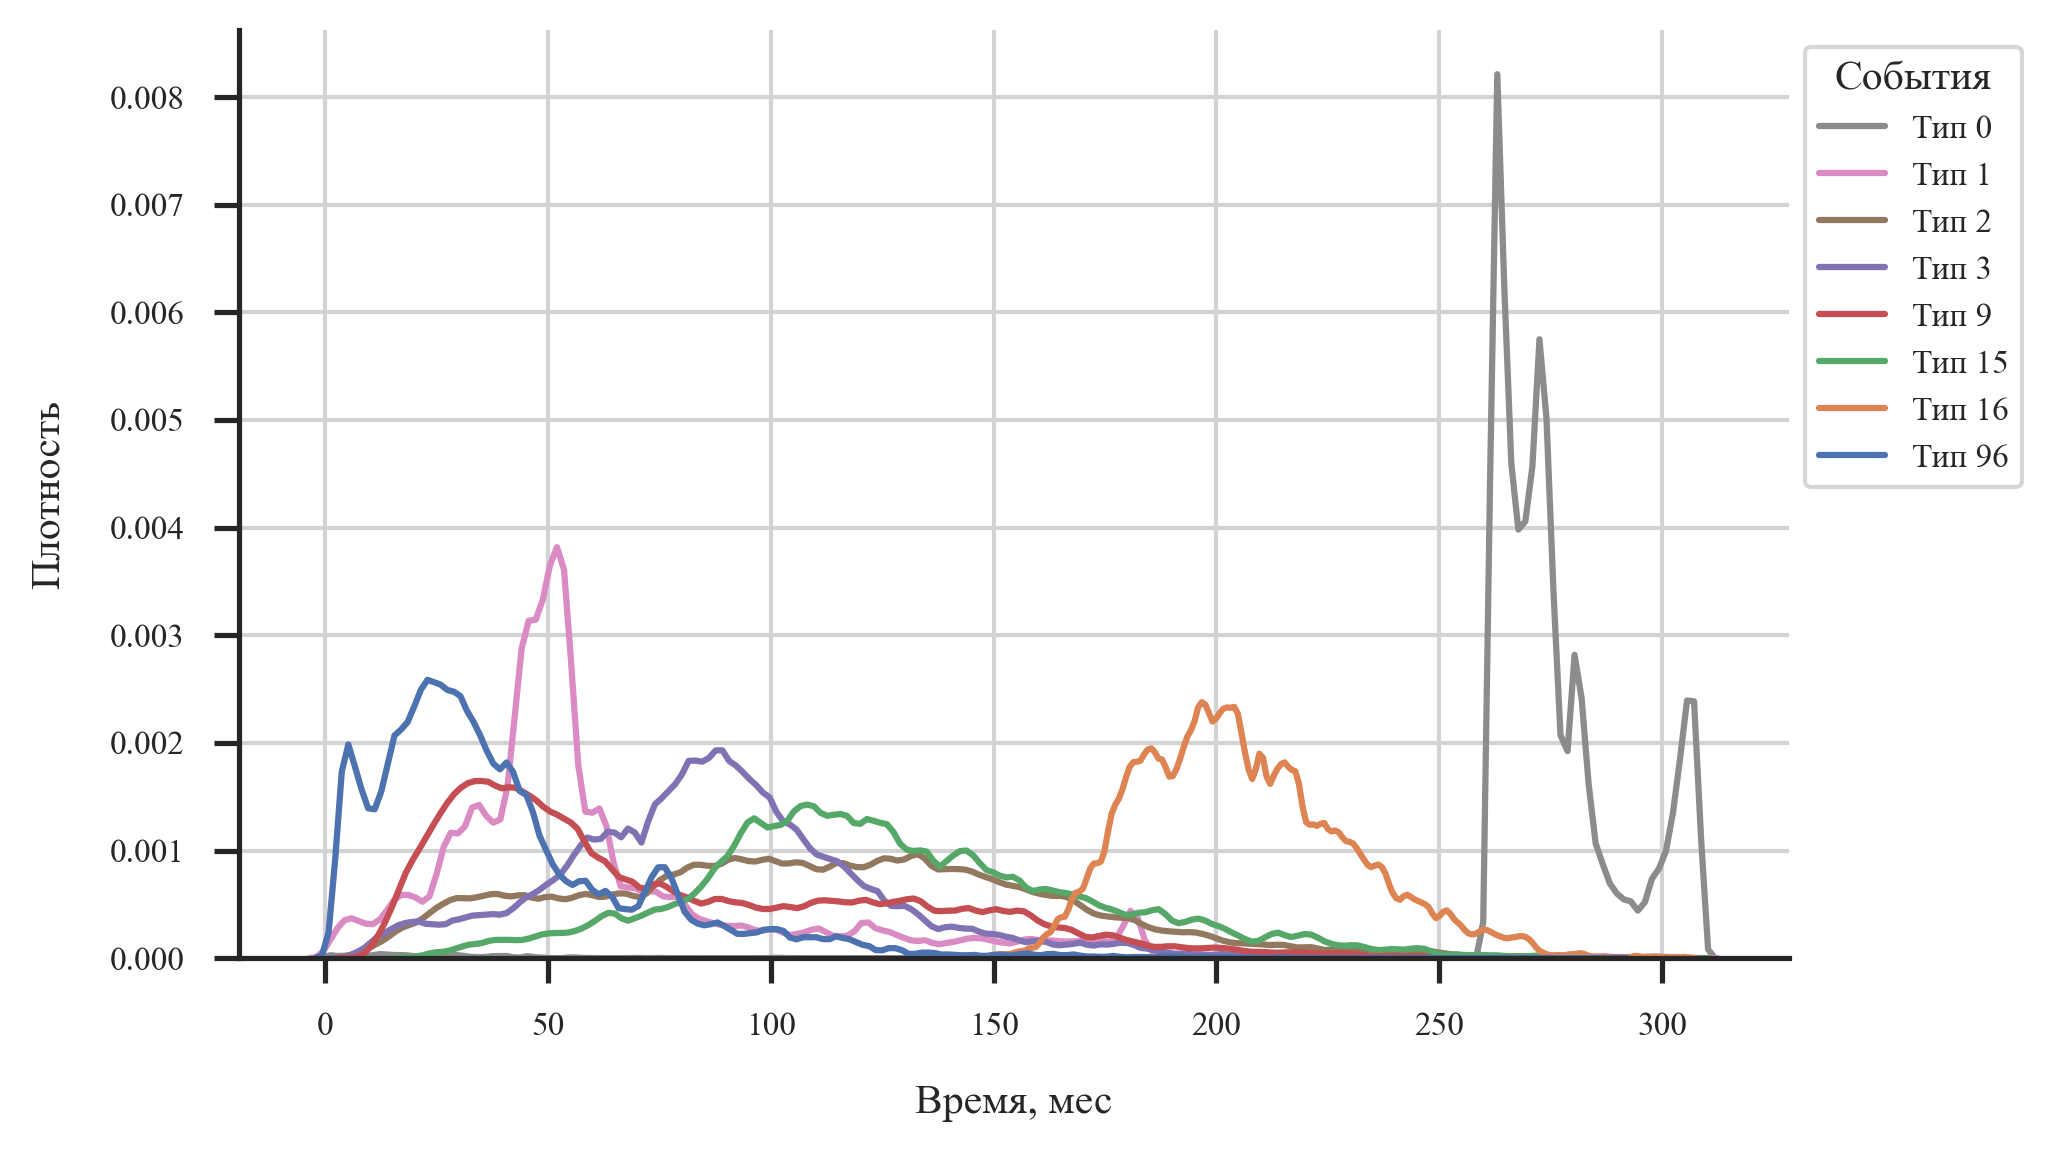

In [35]:
custom_palette = [
    "#900c3f",  # Красный
    "#182b55",  # Синий
    "#5f4e94",  # Зеленый
    "#a291c7",  # Фиолетовый
    "#82cbec",  # Оранжевый
    "#d94f21",  # Коричневый
    "#febd2b",  # Розовый
    "#9aab4b",  # Серый
]

# Стилизация
mpl.pyplot.rcdefaults()

plt.style.use("seaborn")
custom_params = {"axes.spines.right": False, 'grid.color': 'lightgray', 'axes.grid': True, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['axes.unicode_minus'] = False
type_labels = {0: "Тип 0", 1: "Тип 1", 2: "Тип 2", 3: "Тип 3", 4: "Тип 9", 5: "Тип 15", 6: "Тип 16", 7: "Тип 96"}
# y_copy = y_train.copy()
# y_copy.event = y_copy.event.map(type_labels)
#["7", "6", "5", "4", "3", "2", "1", "0"]
labs = [type_labels[value] for value in range(8)]
hue_order = [num for num in range(8)]
hue_order.sort(reverse = True)

fig, ax = plt.subplots(figsize=(7, 4), dpi=300)
sns.kdeplot(data=y_train_l, x="duration", hue="event",linewidth=1.5, bw_adjust=0.25, palette="deep", hue_order = hue_order, ax=ax)
plt.legend(labs, title="События", bbox_to_anchor=(1, 1), loc='upper left', title_fontsize=10, fontsize=8, frameon = True)

plt.tick_params(axis='both', labelsize=8)  # или labelsize=9, 8 и т.д.
plt.xlabel("Время, мес", fontsize=10, labelpad=10)
plt.ylabel("Плотность", fontsize=10, labelpad=10)

plt.tight_layout()
plt.savefig("D:\SurvivalAnalysis\CompetingRisk\kde_events.pdf", format="pdf", dpi=300)
plt.show()


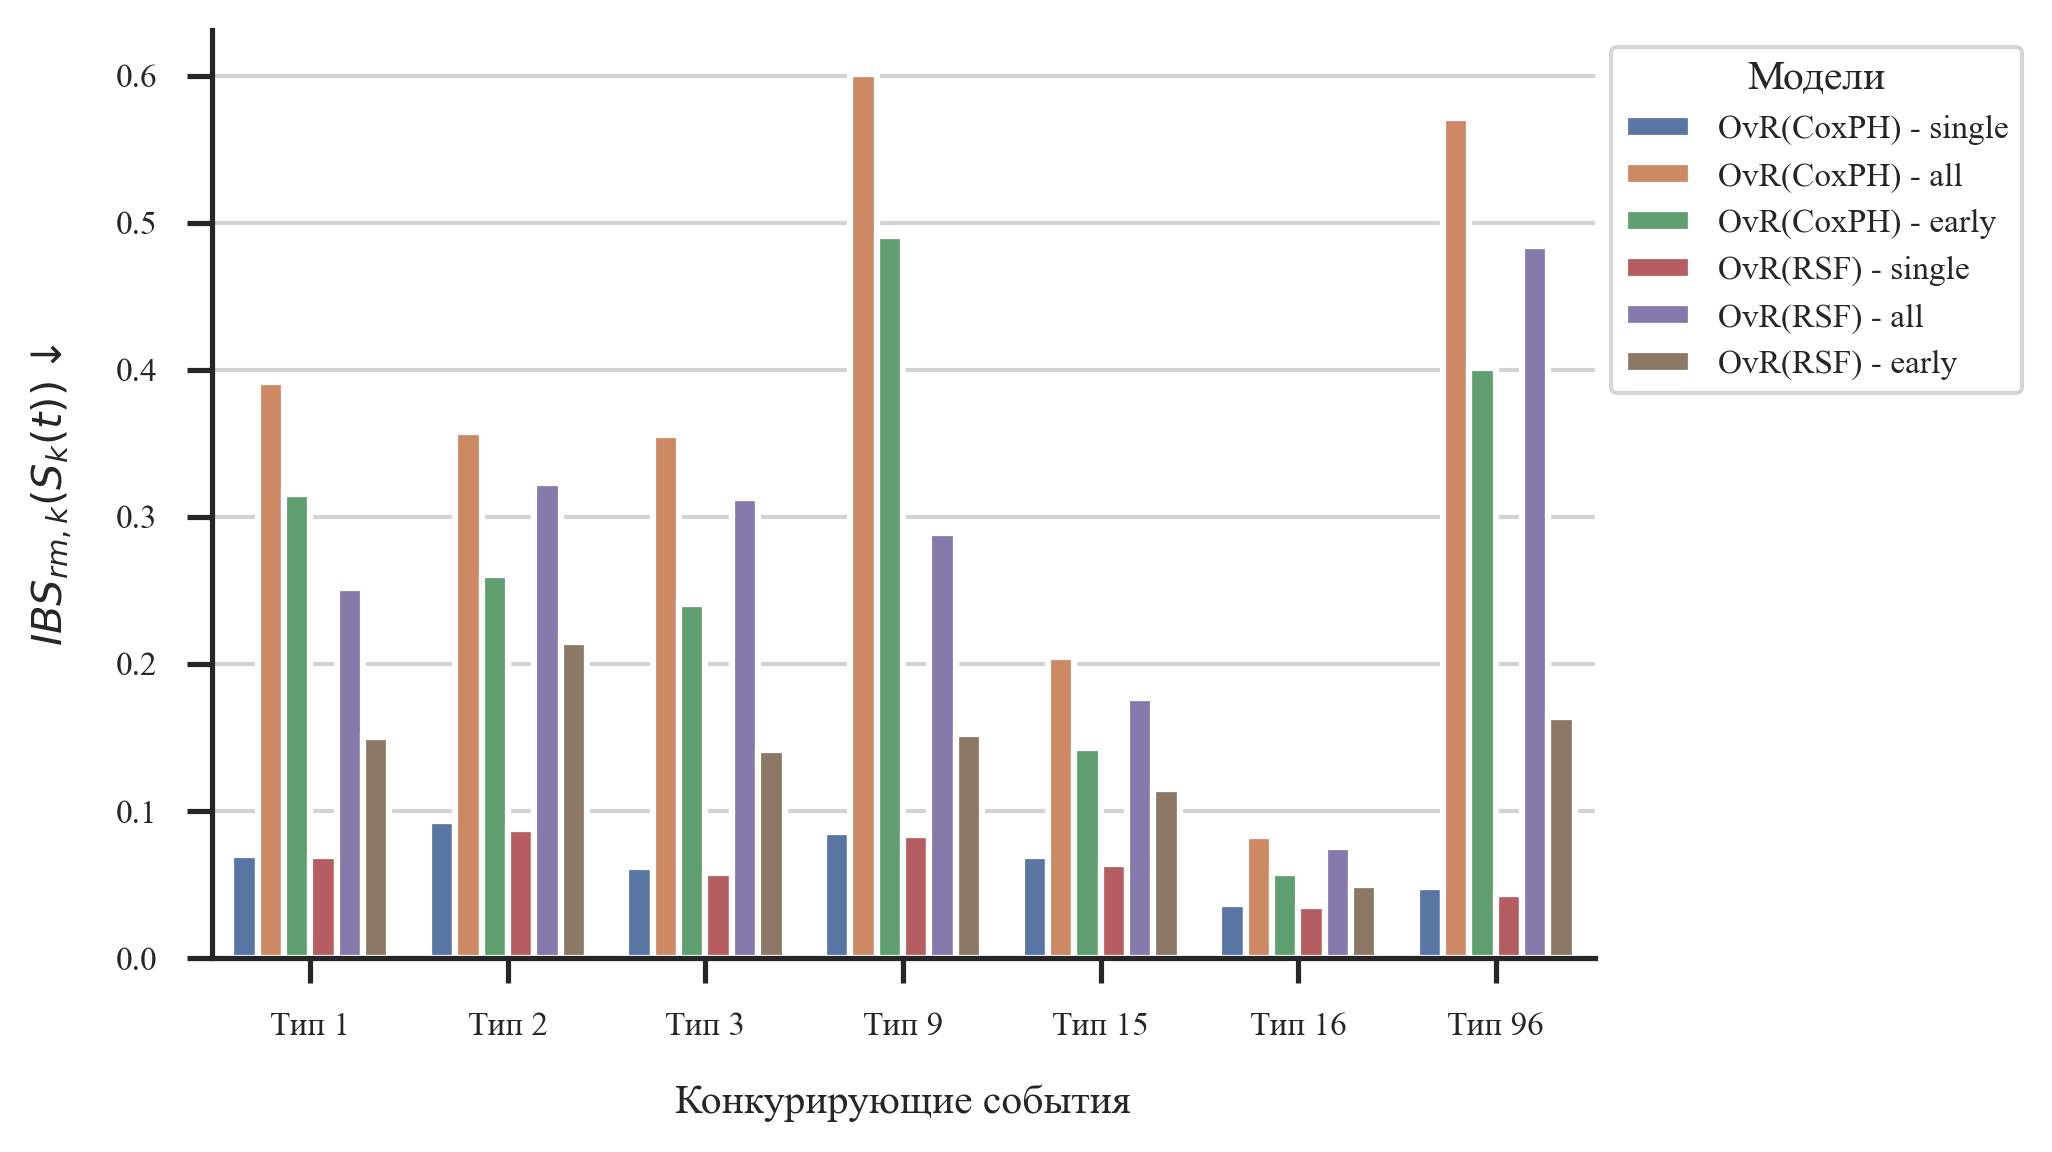

In [41]:
df = pd.DataFrame([
      [0.0700, 0.0933, 0.0618, 0.0855, 0.0694, 0.0371, 0.0483],
      [0.3915, 0.3579, 0.3555, 0.6009, 0.2047, 0.0829, 0.5711],
      [0.3155, 0.2605, 0.2408, 0.4911, 0.1431, 0.0578, 0.4013],
      [0.0696, 0.0877, 0.0577, 0.0840, 0.0637, 0.0358, 0.0438],
      [0.2513, 0.3228, 0.3128, 0.2891, 0.1771, 0.0759, 0.4841],
      [0.1503, 0.2152, 0.1418, 0.1527, 0.1152, 0.0494, 0.1639]], 
    columns=['Тип 1', 'Тип 2', 'Тип 3', 'Тип 9', 'Тип 15', 'Тип 16', 'Тип 96'],
    index=[[f'OvR({i}) - {j}' for i in ['CoxPH', 'RSF'] for j in ['single', 'all', 'early']]])

mpl.pyplot.rcdefaults()
plt.style.use("seaborn")
custom_params = {"axes.spines.right": False, 'grid.color': 'lightgray', 'axes.grid': True, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['axes.unicode_minus'] = False
fig, ax = plt.subplots(figsize=(7, 4), dpi=300)
df_reset = df.reset_index().rename(columns={'index': 'Модель'})
df_long = df_reset.melt(id_vars='level_0', var_name='Тип события', value_name='IBS')
sns.barplot(data=df_long, x='Тип события', y='IBS', hue='level_0', linewidth=1.5, palette='deep')#, ax=ax)#, marker='.', markersize=6,
    #markeredgewidth=0)#, style = "level_0", dashes = False)


# Стилизация
plt.tick_params(axis='both', labelsize=8)
plt.xlabel("Конкурирующие события", fontsize=10, labelpad=10)
plt.ylabel(r"$IBS_{rm, k} (S_k(t)) \downarrow$", fontsize=10, labelpad=10)
plt.legend(title="Модели", bbox_to_anchor=(1, 1), loc='upper left', title_fontsize=10, fontsize=8, frameon = True)

plt.tight_layout()
# plt.savefig(r"D:\SurvivalAnalysis\CompetingRisk\tab_3_bar.pdf", format="pdf", dpi=300)
plt.show()

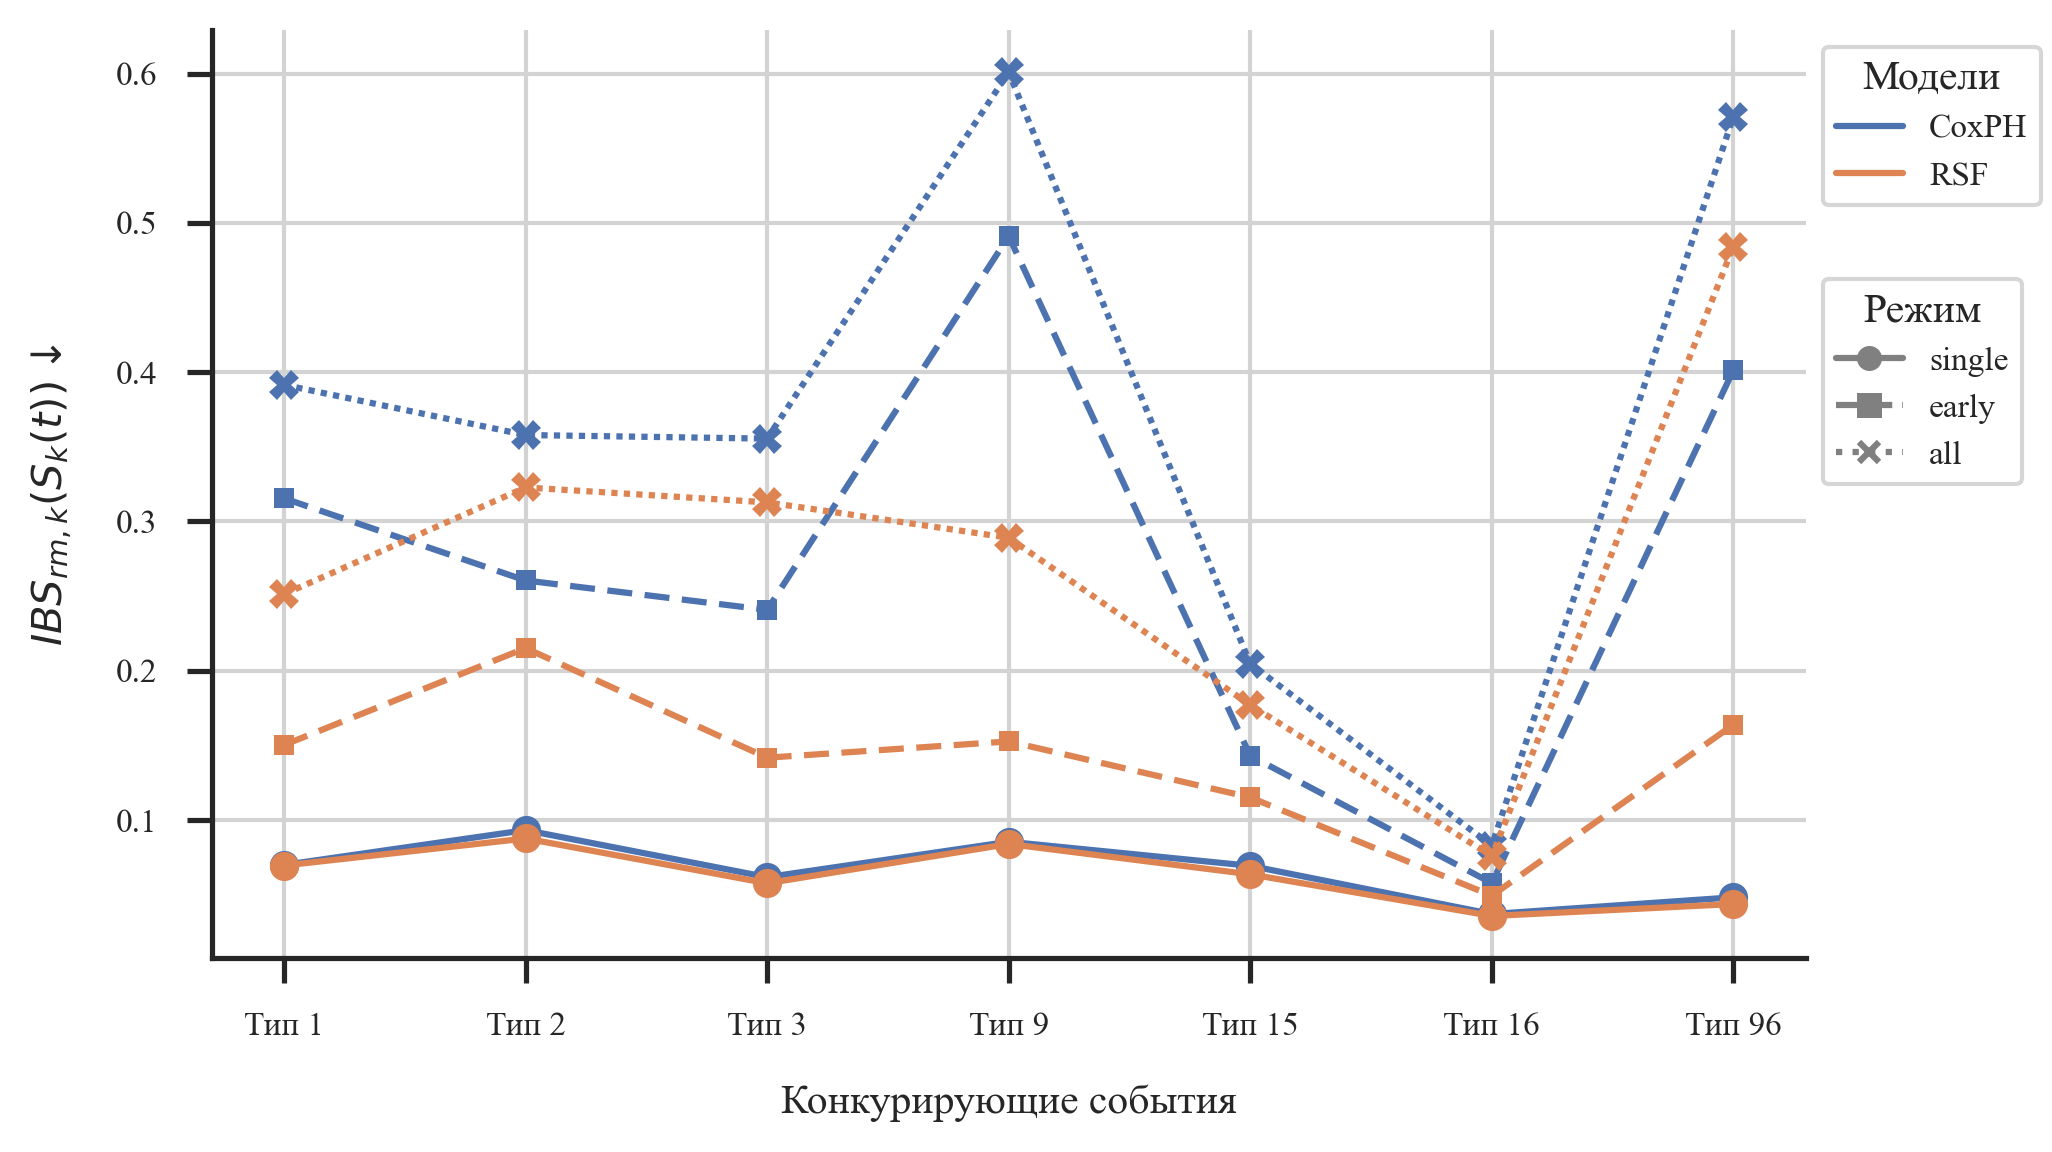

In [49]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
from matplotlib.lines import Line2D

# Данные
df = pd.DataFrame([
      [0.0700, 0.0933, 0.0618, 0.0855, 0.0694, 0.0371, 0.0483],
      [0.3915, 0.3579, 0.3555, 0.6009, 0.2047, 0.0829, 0.5711],
      [0.3155, 0.2605, 0.2408, 0.4911, 0.1431, 0.0578, 0.4013],
      [0.0696, 0.0877, 0.0577, 0.0840, 0.0637, 0.0358, 0.0438],
      [0.2513, 0.3228, 0.3128, 0.2891, 0.1771, 0.0759, 0.4841],
      [0.1503, 0.2152, 0.1418, 0.1527, 0.1152, 0.0494, 0.1639]], 
    columns=['Тип 1', 'Тип 2', 'Тип 3', 'Тип 9', 'Тип 15', 'Тип 16', 'Тип 96'],
    index=[[f'OvR({i}) - {j}' for i in ['CoxPH', 'RSF'] for j in ['single', 'all', 'early']]])

# Сброс индекса и разбор названия модели
df_reset = df.reset_index().rename(columns={'index': 'level_0'})
df_reset[['model', 'mode']] = df_reset['level_0'].str.extract(r'OvR\((.*?)\) - (\w+)')
df_long = df_reset.melt(id_vars=['level_0', 'model', 'mode'], var_name='Тип события', value_name='IBS')



fig, ax = plt.subplots(figsize=(7, 4), dpi=300)

mode_styles = {
    'single': '',
    'early': (4, 2),     
    'all': (1, 1),      
}

sns.lineplot(data=df_long, x='Тип события', y='IBS', hue='model', style='mode', dashes=mode_styles, palette='deep', linewidth=1.5,
    markers=True,
    markersize=7,
    markeredgewidth=0, ax=ax
)

# Стилизация
plt.tick_params(axis='both', labelsize=8)
plt.xlabel("Конкурирующие события", fontsize=10, labelpad=10)
plt.ylabel(r"IBS$\mathrm{}_{rm}$", fontsize=10, labelpad=10) #IBS_rm(S_k(t))
plt.ylabel(r"$IBS_{rm, k} ( S_k(t)) \downarrow$", fontsize=10, labelpad=10)

handles, labels = plt.gca().get_legend_handles_labels()
model_handles = handles[1:3] 
model_labels = labels[1:3]

legend1 = plt.legend(model_handles, model_labels, title="Модели", bbox_to_anchor=(1, 1),loc='upper left', title_fontsize=10, fontsize=8, frameon = True)

mode_handles = [
    Line2D([0], [0], linestyle='-', marker='.', color='gray', label='single', markersize=12),
    Line2D([0], [0], linestyle='--', marker='s', color='gray', label='early'),
    Line2D([0], [0], linestyle=':', marker='x', color='gray', label='all', markeredgewidth=1.5, markersize=5),
]

legend2 = plt.legend(handles=mode_handles, title='Режим', loc='upper left', bbox_to_anchor=(1, 0.75), title_fontsize=10, fontsize=8, frameon = True)

ax.add_artist(legend1)

fig.canvas.draw()
ax = plt.gca()
bbox = ax.get_position()

plt.tight_layout()
plt.savefig(r"D:\SurvivalAnalysis\CompetingRisk\tab_3_line.pdf", format="pdf", dpi=300)
plt.show()


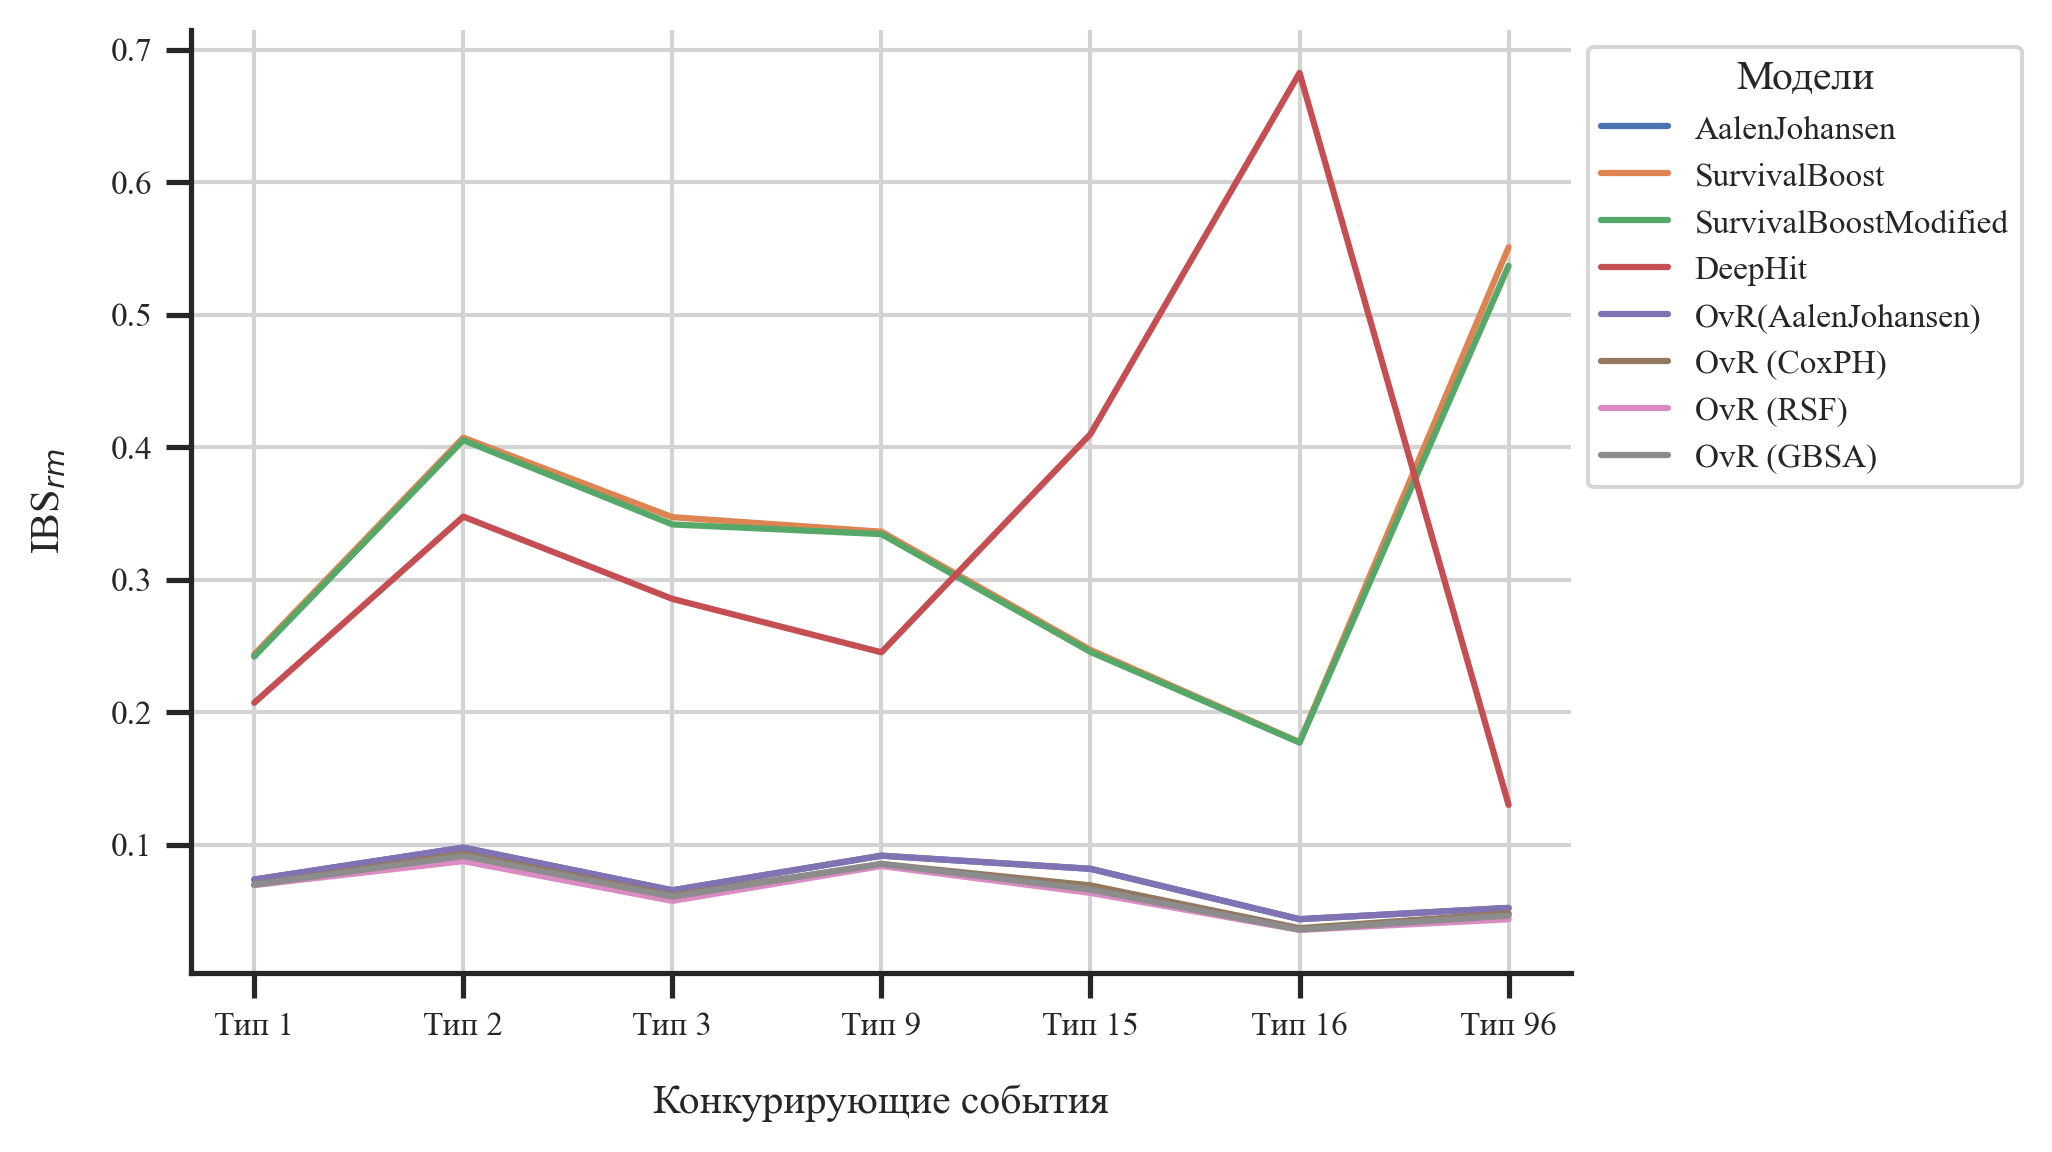

In [55]:
df = pd.DataFrame([[0.0738, 0.0979, 0.0657, 0.0918, 0.0819, 0.0439, 0.0524],
                 [0.2437, 0.4073, 0.3473, 0.3363, 0.2471, 0.1775, 0.5510],
                 [0.2421, 0.4054, 0.3418, 0.3345, 0.2456, 0.1772, 0.5370],
                 [0.2072, 0.3477, 0.2856, 0.2453, 0.4100, 0.6826, 0.1301],
                 [0.0738, 0.0979, 0.0657, 0.0918, 0.0819, 0.0439, 0.0524],
                 [0.0700, 0.0933, 0.0618, 0.0855, 0.0694, 0.0371, 0.0483],
                 [0.0696, 0.0877, 0.0577, 0.0840, 0.0637, 0.0358, 0.0438],
                 [0.0699, 0.0916, 0.0609, 0.0856, 0.0662, 0.0360, 0.0466]],
index = ['AalenJohansen', 'SurvivalBoost', 'SurvivalBoostModified', 
          'DeepHit', 'OvR(AalenJohansen)', 'OvR (CoxPH)', 'OvR (RSF)', 'OvR (GBSA)'],
columns = ['Тип 1', 'Тип 2', 'Тип 3', 'Тип 9', 'Тип 15', 'Тип 16', 'Тип 96'])

mpl.pyplot.rcdefaults()
custom_params = {"axes.spines.right": False, 'grid.color': 'lightgray', 'axes.grid': True, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(7, 4), dpi=300)
df_reset = df.reset_index().rename(columns={'index': 'Модель'})
df_long = df_reset.melt(id_vars='Модель', var_name='Тип события', value_name='IBS')
sns.lineplot(data=df_long, x='Тип события', y='IBS', hue='Модель', linewidth=1.5, palette='deep', style = "Модель", dashes = False)


# Стилизация

plt.tick_params(axis='both', labelsize=8)
plt.xlabel("Конкурирующие события", fontsize=10, labelpad=10)
plt.ylabel(r"IBS$\mathrm{}_{rm}$", fontsize=10, labelpad=10)
plt.legend(title="Модели", bbox_to_anchor=(1, 1), loc='upper left', title_fontsize=10, fontsize=8)

plt.tight_layout()
plt.savefig(r"D:\SurvivalAnalysis\CompetingRisk\tab_4_line.pdf", format="pdf", dpi=300)

plt.show()

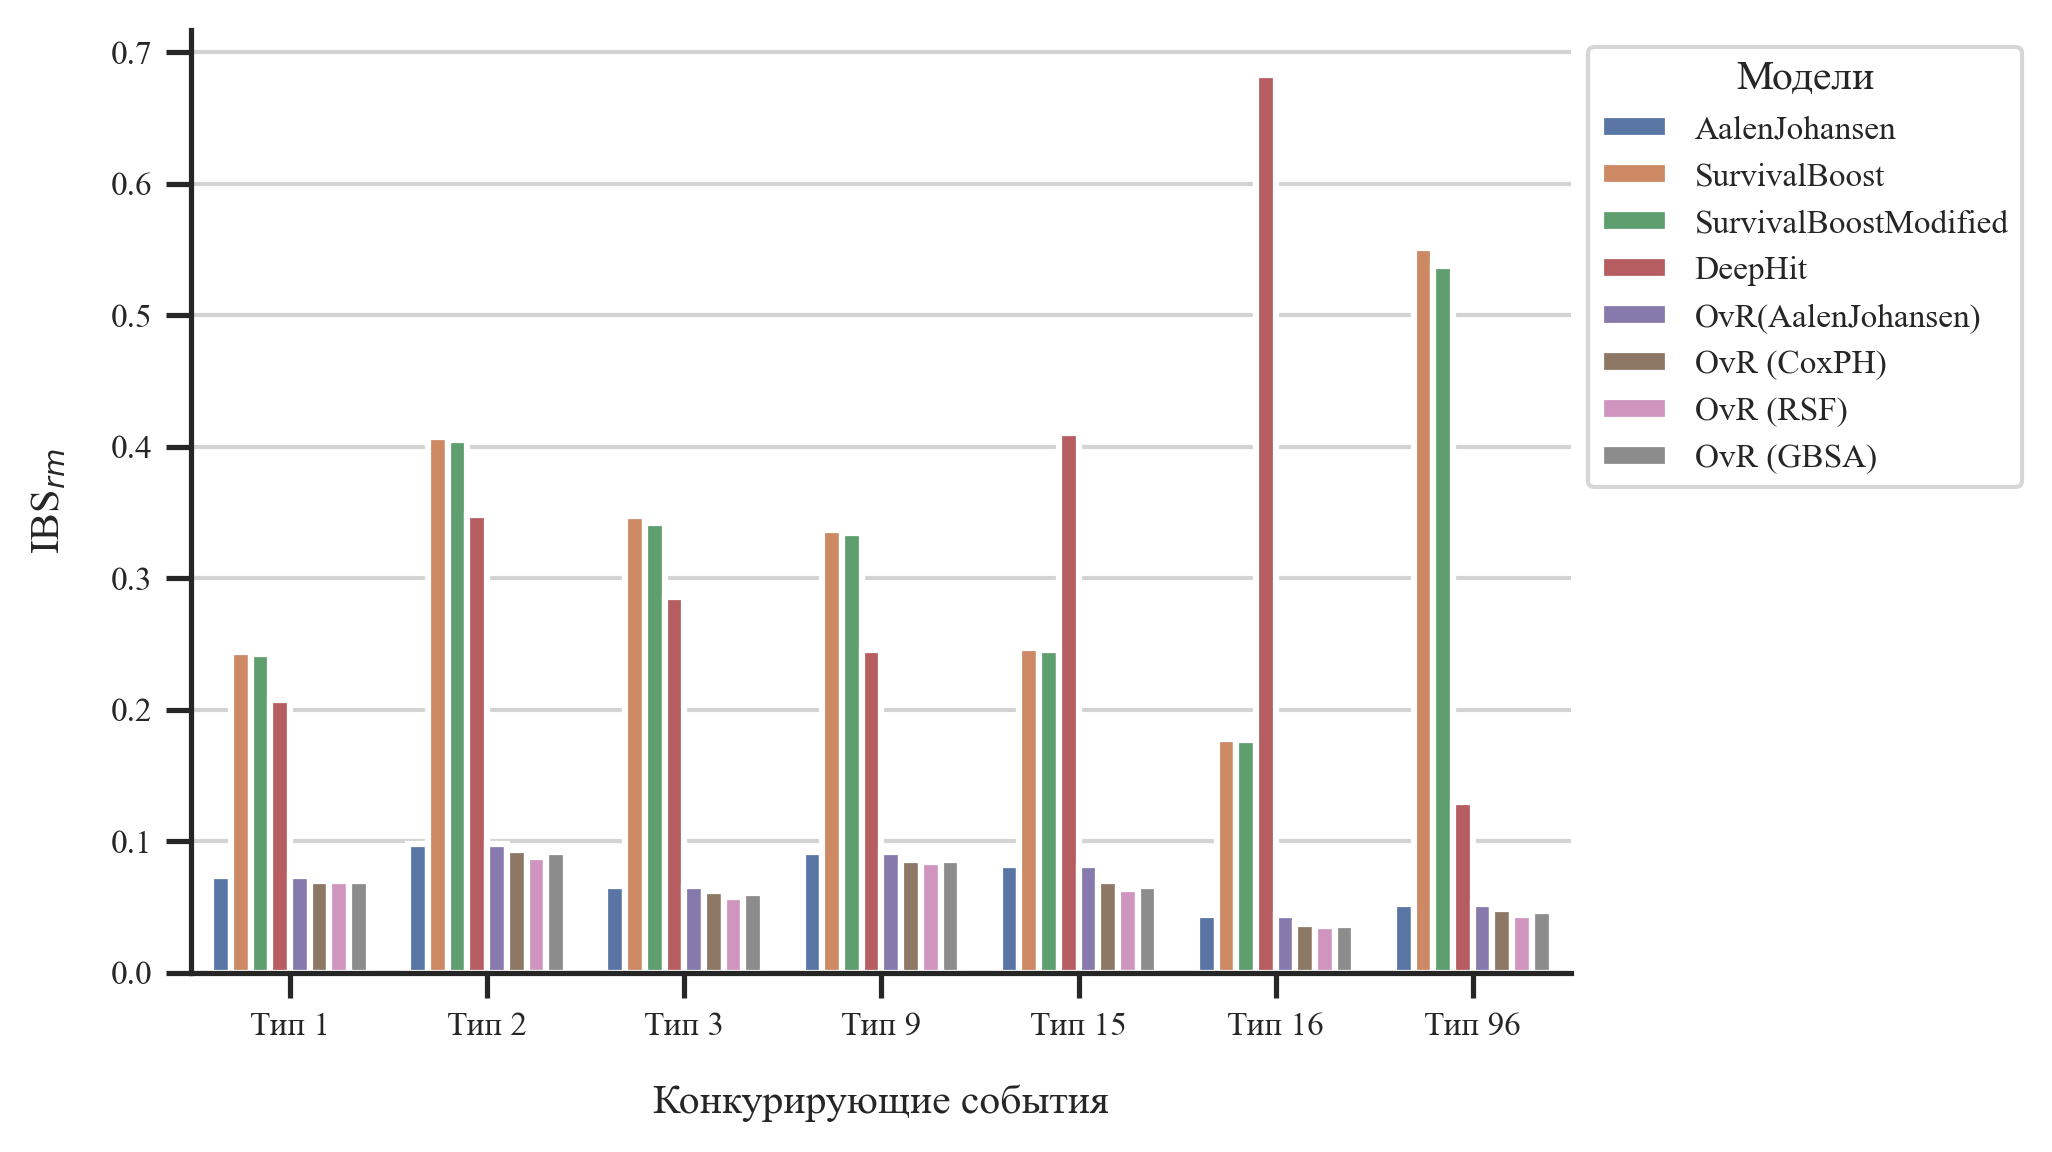

In [57]:
df = pd.DataFrame([[0.0738, 0.0979, 0.0657, 0.0918, 0.0819, 0.0439, 0.0524],
                 [0.2437, 0.4073, 0.3473, 0.3363, 0.2471, 0.1775, 0.5510],
                 [0.2421, 0.4054, 0.3418, 0.3345, 0.2456, 0.1772, 0.5370],
                 [0.2072, 0.3477, 0.2856, 0.2453, 0.4100, 0.6826, 0.1301],
                 [0.0738, 0.0979, 0.0657, 0.0918, 0.0819, 0.0439, 0.0524],
                 [0.0700, 0.0933, 0.0618, 0.0855, 0.0694, 0.0371, 0.0483],
                 [0.0696, 0.0877, 0.0577, 0.0840, 0.0637, 0.0358, 0.0438],
                 [0.0699, 0.0916, 0.0609, 0.0856, 0.0662, 0.0360, 0.0466]],
index = ['AalenJohansen', 'SurvivalBoost', 'SurvivalBoostModified', 
          'DeepHit', 'OvR(AalenJohansen)', 'OvR (CoxPH)', 'OvR (RSF)', 'OvR (GBSA)'],
columns = ['Тип 1', 'Тип 2', 'Тип 3', 'Тип 9', 'Тип 15', 'Тип 16', 'Тип 96'])


mpl.pyplot.rcdefaults()
custom_params = {"axes.spines.right": False, 'grid.color': 'lightgray', 'axes.grid': True, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(7, 4), dpi=300)
df_reset = df.reset_index().rename(columns={'index': 'Модель'})
df_long = df_reset.melt(id_vars='Модель', var_name='Тип события', value_name='IBS')
sns.barplot(data=df_long, x='Тип события', y='IBS', hue='Модель', linewidth=1.5, palette='deep')#, style = "level_0", dashes = False)


# Стилизация

plt.tick_params(axis='both', labelsize=8)
plt.xlabel("Конкурирующие события", fontsize=10, labelpad=10)
plt.ylabel(r"IBS$\mathrm{}_{rm}$", fontsize=10, labelpad=10)
plt.legend(title="Модели", bbox_to_anchor=(1, 1), loc='upper left', title_fontsize=10, fontsize=8)

plt.tight_layout()
plt.savefig(r"D:\SurvivalAnalysis\CompetingRisk\tab_4_bar.pdf", format="pdf", dpi=300)

plt.show()

In [ ]:
df = pd.DataFrame([
[0.0566, 0.1899, 0.1614, 0.1086, 0.1269, 0.2944, 0.1219],
[0.0605, 0.1274, 0.1197, 0.0972, 0.1060, 0.2269, 0.0976],
[0.0560, 0.1886, 0.1580, 0.1091, 0.1260, 0.2989, 0.1181],
[0.0607, 0.1262, 0.1165, 0.0976, 0.1068, 0.2331, 0.0942]],
    columns= ['Тип 1', 'Тип 2', 'Тип 3', 'Тип 9', 'Тип 15', 'Тип 16', 'Тип 96'],
    index=[r'Meta${}_{b}$(OvR(CoxPH))',
           r'Meta${}_{w}$(OvR(CoxPH))',
           r'Meta${}_{b}$(OvR(RSF))',
           r'Meta${}_{w}$(OvR(RSF))'])

best_weight = ['#4C78A8', '#A6CEE3', '#E45756', '#F4A582']

mpl.pyplot.rcdefaults()
custom_params = {"axes.spines.right": False, 'grid.color': 'lightgray', 'axes.grid': True, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(7, 4), dpi=300)
df_reset = df.reset_index().rename(columns={'index': 'Модель'})
df_long = df_reset.melt(id_vars='Модель', var_name='Тип события', value_name='IBS')
sns.lineplot(data=df_long, x='Тип события', y='IBS', hue='Модель', linewidth=1.5, palette=best_weight, marker='.', markersize=6,
    markeredgewidth=0)#, style = "level_0", dashes = False)


# Стилизация
plt.tick_params(axis='both', labelsize=8)
plt.xlabel("Конкурирующие события", fontsize=10, labelpad=10)
plt.ylabel(r"IBS$\mathrm{}_{rm}$", fontsize=10, labelpad=10)
plt.legend(title="Модели", bbox_to_anchor=(1, 1), loc='upper left', title_fontsize=10, fontsize=8)
# plt.arrow(-0.5, 0, 0, 0.6, width=0.01, color='black', length_includes_head=True, head_width=0.2, head_length=0.1)
plt.tight_layout()
plt.savefig(r"D:\SurvivalAnalysis\CompetingRisk\tab_89_line.pdf", format="pdf", dpi=300)

plt.show()

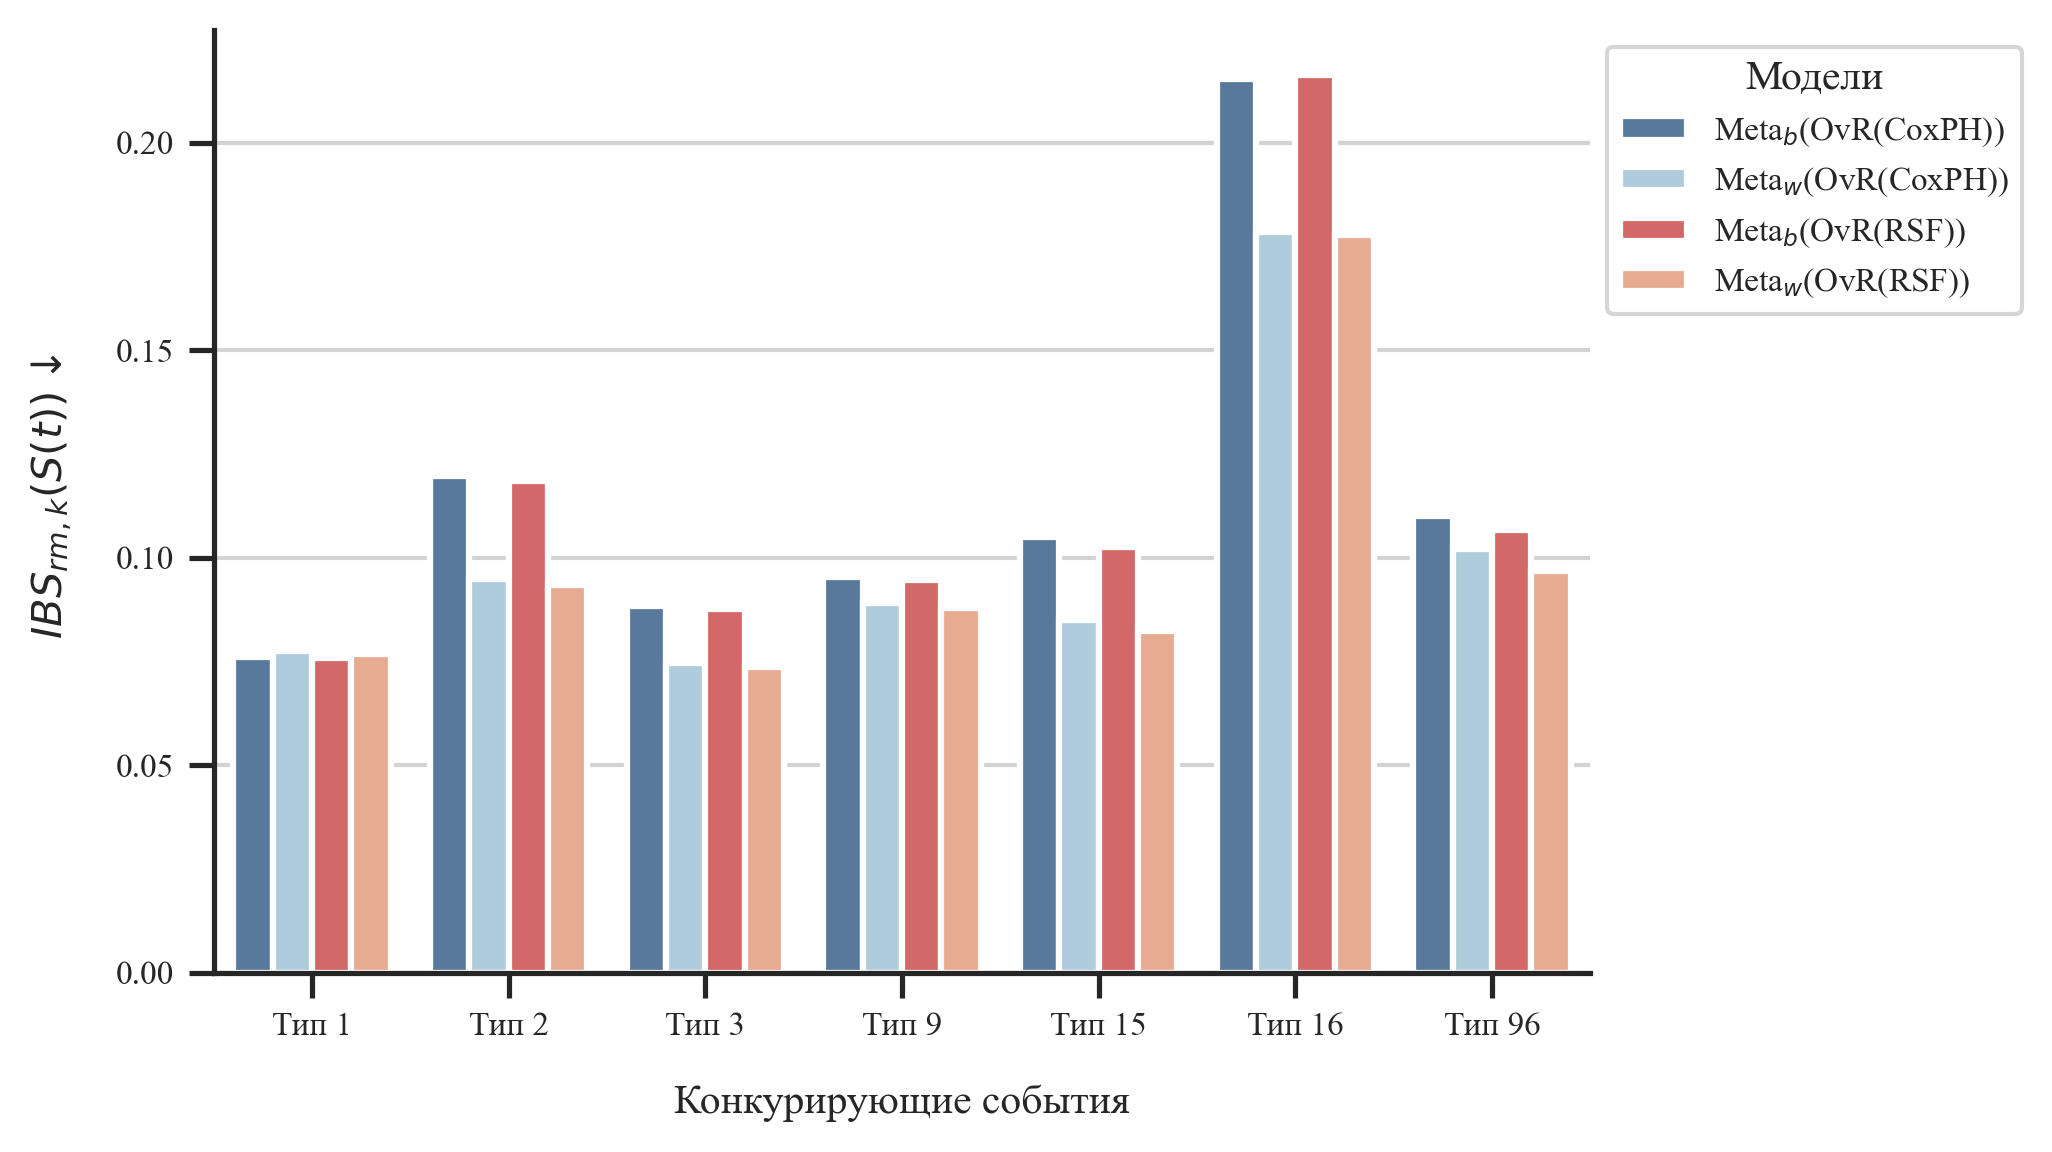

In [54]:
df = pd.DataFrame([
    [0.0762, 0.1197, 0.0884, 0.0954, 0.1051, 0.2154, 0.1101],
    [0.0776, 0.0949, 0.0746, 0.0891, 0.0851, 0.1786, 0.1021],
    [0.0759, 0.1185, 0.0877, 0.0947, 0.1025, 0.2164, 0.1066],
    [0.0769, 0.0934, 0.0736, 0.0878, 0.0823, 0.1779, 0.0969]],
    columns= ['Тип 1', 'Тип 2', 'Тип 3', 'Тип 9', 'Тип 15', 'Тип 16', 'Тип 96'],
    index=[r'Meta${}_{b}$(OvR(CoxPH))',
           r'Meta${}_{w}$(OvR(CoxPH))',
           r'Meta${}_{b}$(OvR(RSF))',
           r'Meta${}_{w}$(OvR(RSF))'])

mpl.pyplot.rcdefaults()
custom_params = {"axes.spines.right": False, 'grid.color': 'lightgray', 'axes.grid': True, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['axes.unicode_minus'] = False

best_weight = ['#4C78A8', '#A6CEE3', '#E45756', '#F4A582']

plt.figure(figsize=(7, 4), dpi=300)
df_reset = df.reset_index().rename(columns={'index': 'Модель'})
df_long = df_reset.melt(id_vars='Модель', var_name='Тип события', value_name='IBS')
sns.barplot(data=df_long, x='Тип события', y='IBS', hue='Модель', linewidth=1.5, palette=best_weight)
ax = plt.gca()

# Стилизация
plt.tick_params(axis='both', labelsize=8)
plt.xlabel("Конкурирующие события", fontsize=10, labelpad=10)
plt.ylabel(r" $IBS_{rm, k} (S(t)) \downarrow$", fontsize=10, labelpad=10)
plt.legend(title="Модели", bbox_to_anchor=(1, 1), loc='upper left', title_fontsize=10, fontsize=8)

plt.tight_layout()
plt.savefig(r"D:\SurvivalAnalysis\CompetingRisk\tab_89_bar_.pdf", format="pdf", dpi=300)

plt.show()

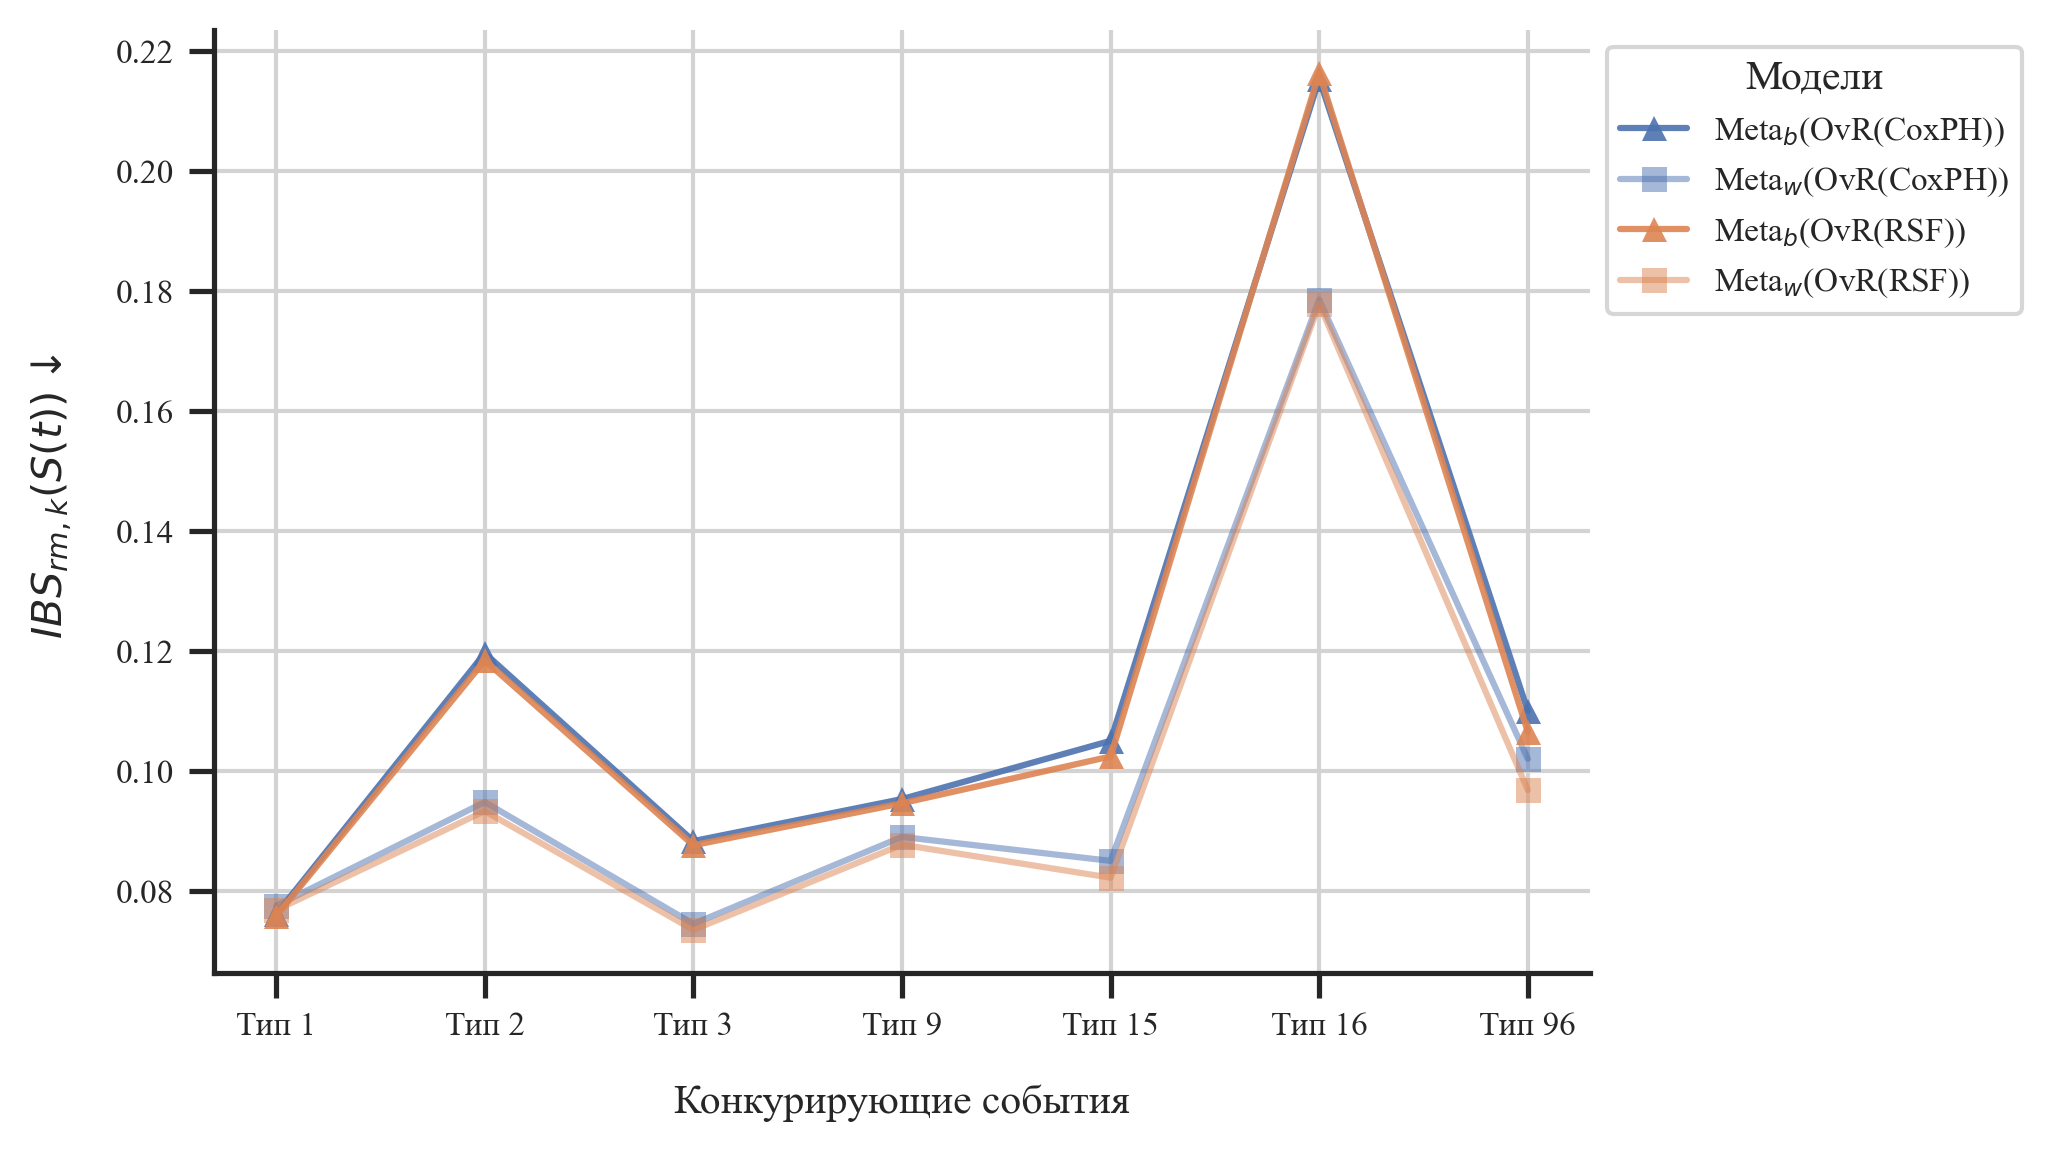

In [53]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd

df = pd.DataFrame([
    [0.0762, 0.1197, 0.0884, 0.0954, 0.1051, 0.2154, 0.1101],
    [0.0776, 0.0949, 0.0746, 0.0891, 0.0851, 0.1786, 0.1021],
    [0.0759, 0.1185, 0.0877, 0.0947, 0.1025, 0.2164, 0.1066],
    [0.0769, 0.0934, 0.0736, 0.0878, 0.0823, 0.1779, 0.0969]],
    columns=['Тип 1', 'Тип 2', 'Тип 3', 'Тип 9', 'Тип 15', 'Тип 16', 'Тип 96'],
    index=[r'Meta${}_{b}$(OvR(CoxPH))',
           r'Meta${}_{w}$(OvR(CoxPH))',
           r'Meta${}_{b}$(OvR(RSF))',
           r'Meta${}_{w}$(OvR(RSF))']
)


best_weight = ['#4c72b0','#4c72b0', '#dd8452', '#dd8452']
alphas = [0.9, 0.5, 0.9, 0.5]
markers = ['^', 's', '^', 's']

# plt.figure(figsize=(7, 4), dpi=300)
fig, ax = plt.subplots(figsize=(7, 4), dpi=300)

df_reset = df.reset_index().rename(columns={'index': 'Модель'})
df_long = df_reset.melt(id_vars='Модель', var_name='Тип события', value_name='IBS')

for i, model in enumerate(df.index):
    model_name = df.index[i]
    color = best_weight[i]
    alpha = alphas[i]
    marker = markers[i]

    y = df.iloc[i].values
    x = df.columns
    plt.plot(x, y, label=model_name, color=color, alpha=alpha,
             linewidth=1.5, marker=marker, markersize=6, markeredgewidth=0)

plt.tick_params(axis='both', labelsize=8)
plt.xlabel("Конкурирующие события", fontsize=10, labelpad=10)
plt.ylabel(r" $IBS_{rm, k} (S(t)) \downarrow$", fontsize=10, labelpad=10)

plt.legend(title="Модели", bbox_to_anchor=(1, 1), loc='upper left',
           title_fontsize=10, fontsize=8)


fig.canvas.draw()
ax = plt.gca()
bbox = ax.get_position()

plt.tight_layout()
plt.savefig(r"D:\SurvivalAnalysis\CompetingRisk\tab_89_line.pdf", format="pdf", dpi=300)
plt.show()
